In [1]:
#%matplotlib notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
from plotly.subplots import make_subplots
from sklearn.neighbors import KNeighborsClassifier

from keras.datasets import mnist
import seaborn as sns
import pandas as pd
from collections import Counter, OrderedDict

from sklearn.mixture import GaussianMixture
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import random
from sklearn.cluster import KMeans
from itertools import chain

from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats

Using TensorFlow backend.


In [2]:
X_train = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST5_new_train_x.npy')
Y_train = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST5_new_train_y.npy')
X_test = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST5_new_test_x.npy')
Y_test = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST5_new_test_y.npy')
print(X_train.shape, Y_train.shape);print(X_test.shape, Y_test.shape)

(30226, 784) (30226,)
(5059, 784) (5059,)


In [3]:
latent_space_train = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST5_train_latent_space_z5.npy')
print(latent_space_train.shape, Y_train.shape)

(30226, 5) (30226,)


In [4]:
latent_space_test = np.load('/home/dsarkar/compute_canada/MNIST/dataset/MNIST5_test_latent_space_z5.npy')
print(latent_space_test.shape,Y_test.shape)

(5059, 5) (5059,)


In [5]:
tuned_parameters = [{'kernel': ['rbf'], 'C' : [0.1, 1, 10, 100]},
                    {'kernel': ['linear'], 'C' : [0.1, 1, 10, 100]}]
# ,
#                    {'kernel': ['poly'], 'C' : [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001]},
#                    {'kernel': ['sigmoid'], 'C' : [0.1, 1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}]
score = 'accuracy'
clf = GridSearchCV(SVC(), tuned_parameters, scoring=score, n_jobs=-1,refit=True,verbose=2)

# z=5

In [12]:
uniform_is = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_rs_MNIST5_input_space.npy')
uniform_is_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_rs_MNIST5_input_space.npy')

uniform_ls = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_rs_MNIST5_z5.npy')
uniform_ls_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_rs_MNIST5_z5.npy')

random_coreset_is40 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_cs_MNIST5_input_space_K40.npy')
random_coreset_is40_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_cs_MNIST5_input_space_K40.npy')

random_coreset_ls40 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_cs_MNIST5_z5_K40.npy')
random_coreset_ls40_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_cs_MNIST5_z5_K40.npy')

sensitivity_ls40 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_Kraus_cs1000_MNIST5_z5_K40.npy')
sensitivity_ls40_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_Kraus_cs1000_MNIST5_z5_K40.npy')


In [24]:
# uniform_ls

In [25]:
# [uniform_ls[4*i+3] for i in range(5)]

Text(0.5, 1.0, 'Accuracy comparison for 500 labeled points')

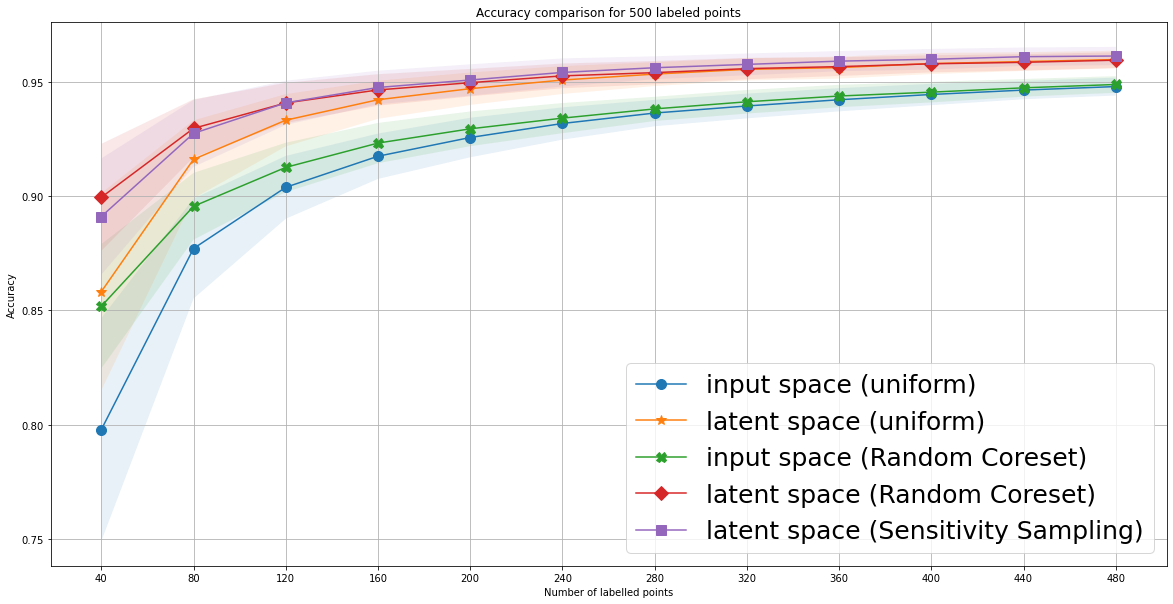

In [26]:
number_of_labeled_data = range(40,501,40)
plt.figure(figsize=(20,10))


plt.plot(number_of_labeled_data,uniform_is, marker='o', markersize=10)
plt.plot(number_of_labeled_data,uniform_ls, marker='*', markersize=10)
plt.plot(number_of_labeled_data,random_coreset_is40, marker='X', markersize=10)
plt.plot(number_of_labeled_data,random_coreset_ls40, marker='D', markersize=10) 
plt.plot(number_of_labeled_data,sensitivity_ls40, marker='s', markersize=10)


plt.fill_between(number_of_labeled_data, (uniform_is - uniform_is_sd), (uniform_is + uniform_is_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (uniform_ls - uniform_ls_sd), (uniform_ls + uniform_ls_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (random_coreset_is40 - random_coreset_is40_sd), (random_coreset_is40 + random_coreset_is40_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (random_coreset_ls40 - random_coreset_ls40_sd), (random_coreset_ls40 + random_coreset_ls40_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (sensitivity_ls40 - sensitivity_ls40_sd), (sensitivity_ls40 + sensitivity_ls40_sd), alpha=.1)





plt.legend(['input space (uniform)',         
            'latent space (uniform)',
          'input space (Random Coreset)',
            'latent space (Random Coreset)'\
           ,'latent space (Sensitivity Sampling)'
           ], loc = 4, fontsize=25)
plt.grid()
plt.xticks(number_of_labeled_data)
plt.xlabel("Number of labelled points")
plt.ylabel("Accuracy")
plt.title("Accuracy comparison for 500 labeled points")

# UT

# Z=5

In [ ]:
n_components = np.arange(1, 161)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(latent_space_train) #z=7
          for n in n_components]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(n_components, [m.bic(latent_space_train) for m in models], label='BIC')
plt.plot(n_components, [m.aic(latent_space_train) for m in models], label='AIC')
plt.legend(loc='best')

plt.xlabel('n_components');

In [ ]:
np.argmin([m.bic(latent_space_train) for m in models])

In [ ]:
np.argmin([m.aic(latent_space_train) for m in models])

# GMM + UT

In [6]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats

In [83]:
# gmm = GaussianMixture(n_components=20).fit(latent_space_train)
gmm = GaussianMixture(n_components=80).fit(latent_space_train)
labels = gmm.predict(latent_space_train)

In [84]:
print(Counter(labels))

Counter({23: 1244, 64: 1149, 41: 801, 28: 735, 44: 726, 42: 707, 2: 679, 61: 674, 49: 664, 53: 644, 3: 621, 60: 611, 57: 583, 39: 578, 18: 538, 1: 527, 55: 517, 17: 510, 5: 487, 16: 487, 48: 480, 31: 455, 10: 443, 27: 424, 32: 419, 8: 415, 72: 413, 13: 382, 12: 379, 58: 377, 7: 376, 70: 373, 68: 373, 11: 363, 38: 357, 43: 356, 29: 349, 79: 340, 20: 340, 21: 332, 9: 328, 6: 325, 46: 324, 47: 323, 51: 321, 69: 311, 25: 310, 50: 309, 26: 305, 4: 299, 15: 292, 62: 289, 74: 267, 36: 267, 59: 263, 30: 257, 34: 253, 14: 242, 35: 236, 54: 235, 45: 231, 67: 222, 66: 220, 0: 218, 73: 204, 37: 201, 40: 200, 56: 179, 33: 164, 76: 163, 65: 163, 22: 154, 24: 143, 71: 139, 75: 131, 52: 125, 19: 123, 77: 111, 78: 90, 63: 61})


In [85]:
gmm.covariances_.shape

(80, 5, 5)

In [86]:
gmm.means_.shape

(80, 5)

In [87]:
all_sigmas = []
for i in range(80):#range(20):
    mean = gmm.means_[i]
    p = gmm.covariances_[i]
    points = MerweScaledSigmaPoints(n=5, alpha=0.1, beta=2., kappa=(3-5))
    sigmas = points.sigma_points(mean, p)
    all_sigmas.append(sigmas)
    #print(sigmas)

In [88]:
points

MerweScaledSigmaPoints object
n = 5
alpha = 0.1
beta = 2.0
kappa = -2
Wm = [-165.66666667   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667]
Wc = [-162.67666667   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667   16.66666667   16.66666667   16.66666667   16.66666667
        16.66666667]
subtract = <ufunc 'subtract'>
sqrt = <function cholesky at 0x2aaaf5aa6670>

In [89]:
all_sigmas = np.array(all_sigmas, dtype=np.float32)
all_sigmas.shape

(80, 11, 5)

In [90]:
sigma_points = all_sigmas.reshape(80*11,5)
sigma_points.shape

(880, 5)

In [91]:
# REMOVE DUPLICATE SIGMA POINTS
sigma_points = np.unique(sigma_points, axis=0)
sigma_points.shape

(880, 5)

In [92]:
# fig = go.Figure()

# fig.add_trace(go.Scatter3d(x=sigma_points[:,0], y=sigma_points[:,1], \
#                                    z=sigma_points[:,2], mode='markers',\
#                                   marker=dict(
#         size=2,
#         color='black',                # set color to an array/list of desired values
#        # colorscale='Viridis',   # choose a colorscale
#         opacity=1.0
#     )))

# fig.add_trace(go.Scatter3d(x=latent_space_train[:,0], y=latent_space_train[:,1], z=latent_space_train[:,2], mode='markers',\
#                                   marker=dict(
#         size=1,
#         color='yellow',#kmeans.labels_,                # set color to an array/list of desired values
#        # colorscale='Viridis',   # choose a colorscale
#         opacity=0.5
#     )))


# fig.update_layout(
#     autosize=False,
#     width=1000,
#     height=1000)

# fig.show()

In [93]:
# def closest_node(node, nodes):
#     dist_2 = np.sum((nodes - node)**2, axis=1)
#     return np.argmin(dist_2)

## Find class of sigma point
In order to find the class of sigma points we use KNN with Squared Euclidean Distance.

In [94]:
neigh = KNeighborsClassifier(n_neighbors=1,weights='distance')
neigh.fit(latent_space_train, Y_train)

KNeighborsClassifier(n_neighbors=1, weights='distance')

In [95]:
prediction = neigh.predict(sigma_points)

In [96]:
print(Counter(prediction))

Counter({0: 204, 3: 181, 7: 176, 2: 165, 9: 154})


# Random

In [97]:
mean_random = []
sd_random = []


for coreset_size in range(40,501,40):
    print("*********************** Training on {} points ***********************".format(coreset_size))
    accuracy = [] # calculate accuracy of 500 iterations
    c = list(zip(sigma_points,prediction))
    iterations = 0
    while iterations < 500: # run 500 simulations and take average 
        train_data = []
        train_labels = []
        for (data,label) in random.sample(c,coreset_size):
            train_data.append(data)
            train_labels.append(label)  
        train_x = np.array(train_data)
        train_y = np.array(train_labels)
        
        print()
        print("Distribution of data in the training points")
        print(Counter(train_y)) 

        clf.fit(train_x, train_y)
        print("Best parameters set found on {} data points:".format(coreset_size))
        print(clf.best_params_)
        print()
        y_true, y_pred = Y_test, clf.predict(latent_space_test)
        accuracy.append(accuracy_score(y_true, y_pred))
        iterations += 1
    accuracy = np.asarray(accuracy)
    mean_accuracy = accuracy.mean()
    sd_accuracy = accuracy.std()
    
    mean_random.append(mean_accuracy)
    sd_random.append(sd_accuracy)
    
mean_random = np.array(mean_random)
sd_random = np.array(sd_random)

*********************** Training on 40 points ***********************

Distribution of data in the training points
Counter({7: 11, 0: 8, 9: 8, 3: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   20.8s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 0: 10, 7: 7, 3: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 0: 10, 2: 8, 7: 6, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 2: 8, 7: 7, 9: 6, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 0: 9, 2: 7, 3: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks     

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 2: 11, 7: 8, 3: 6, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 7: 9, 2: 7, 3: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 2: 10, 7: 9, 3: 7, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 0: 9, 7: 8, 9: 7, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 9: 10, 0: 7, 2: 6, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 8, 2: 8, 9: 7, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 17, 7: 9, 3: 8, 2: 3, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 9: 7, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
C

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 12, 7: 9, 2: 7, 3: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 2: 9, 0: 8, 9: 7, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 13, 2: 8, 3: 7, 9: 7, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 9: 10, 3: 9, 7: 6, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 12, 9: 10, 3: 9, 0: 5, 7: 4})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks     

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 9: 10, 0: 8, 7: 7, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 10, 2: 9, 9: 9, 3: 8, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 13, 0: 9, 7: 7, 9: 6, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 9: 10, 7: 7, 2: 7, 3: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks     

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 13, 3: 11, 2: 7, 7: 6, 0: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 9, 7: 9, 9: 8, 2: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 7: 9, 9: 7, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 7: 10, 0: 9, 2: 8, 3: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
C

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an



Distribution of data in the training points
Counter({2: 10, 7: 9, 0: 8, 9: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 7: 9, 2: 8, 9: 7, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 0: 11, 7: 7, 2: 7, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 0: 9, 9: 7, 3: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 7: 9, 9: 9, 2: 6, 3: 5})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[


Distribution of data in the training points
Counter({0: 11, 7: 9, 2: 8, 9: 8, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 10, 0: 9, 9: 8, 3: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 9, 7: 9, 9: 7, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 2: 10, 7: 6, 9: 6, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 2: 9, 7: 7, 9: 7, 0: 6})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 9, 7: 9, 9: 8, 0: 7, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 9, 9: 8, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 16, 0: 9, 2: 8, 3: 5, 9: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 13, 0: 10, 2: 9, 3: 4, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter(

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyB

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 7: 9, 9: 7, 2: 7, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 7: 10, 3: 9, 2: 7, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 9: 8, 0: 7, 2: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 11, 7: 7, 2: 5, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 9, 3: 9, 0: 9, 7: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 10, 9: 10, 2: 8, 0: 6, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 7: 13, 9: 7, 2: 4, 3: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 8, 7: 8, 2: 7, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training p

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyB

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 3: 9, 9: 8, 2: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 2: 10, 7: 9, 3: 6, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 2: 9, 7: 7, 3: 5, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 11, 2: 7, 7: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 0: 9, 2: 7, 7: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 2: 9, 9: 6, 0: 6, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 7: 10, 3: 6, 9: 6, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 3: 11, 7: 8, 2: 4, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40


Distribution of data in the training points
Counter({3: 11, 7: 11, 0: 9, 9: 5, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 13, 2: 9, 9: 8, 0: 7, 3: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 11, 7: 8, 2: 7, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 10, 9: 9, 2: 8, 3: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 11, 9: 8, 2: 6, 7: 4})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 2: 8, 3: 7, 7: 7, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 3: 9, 0: 8, 7: 6, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 13, 0: 11, 3: 8, 7: 6, 9: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 9: 7, 3: 7, 2: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)


Distribution of data in the training points
Counter({2: 16, 0: 11, 7: 5, 3: 5, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 7: 8, 9: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 16, 7: 8, 2: 7, 0: 5, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 2: 9, 9: 7, 7: 6, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 7: 9, 9: 8, 0: 8, 2: 4})
Fitting 5 folds for each of 8 candi

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyB


Distribution of data in the training points
Counter({7: 12, 3: 9, 0: 7, 2: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 9: 9, 0: 8, 2: 7, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 10, 3: 9, 2: 9, 7: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 11, 0: 11, 2: 7, 7: 7, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 2: 12, 0: 6, 7: 5, 9: 3})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks     

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 2: 10, 3: 9, 9: 7, 7: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 11, 0: 9, 9: 7, 7: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 3: 10, 0: 10, 2: 5, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 3: 9, 9: 8, 0: 8, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 14, 7: 7, 2: 7, 9: 6, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 0: 10, 3: 8, 7: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 7: 10, 0: 10, 2: 5, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 7: 9, 3: 8, 2: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 10, 2: 8, 7: 6, 0: 4})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 10, 7: 8, 0: 8, 3: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 7: 9, 3: 9, 2: 6, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 12, 0: 10, 3: 7, 9: 6, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 7: 9, 9: 9, 2: 7, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 3: 10, 0: 9, 7: 7, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 8, 2: 7, 9: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 9, 2: 9, 7: 7, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 9, 3: 9, 0: 8, 9: 7, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Coun

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 3: 9, 0: 8, 9: 7, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 2: 8, 3: 8, 7: 7, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 11, 2: 7, 7: 7, 0: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 2: 9, 9: 6, 0: 6, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 9, 9: 9, 7: 9, 3: 7, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 8, 2: 7, 7: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 10, 2: 9, 7: 7, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 9, 9: 9, 7: 6, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 9: 8, 7: 8, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 2: 8, 9: 8, 0: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 7: 11, 3: 8, 2: 6, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 3: 9, 9: 8, 2: 7, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 12, 0: 10, 9: 8, 7: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 2: 10, 7: 7, 0: 7, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 9: 10, 2: 9, 3: 6, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 10, 0: 8, 7: 8, 2: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 2: 8, 9: 7, 7: 7, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 10, 2: 9, 0: 8, 3: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 7: 9, 9: 9, 2: 5, 3: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 10, 0: 9, 7: 7, 3: 7, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 0: 9, 3: 8, 2: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 0: 9, 2: 8, 3: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 10, 3: 9, 9: 8, 7: 7, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 7: 9, 9: 8, 3: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 9: 8, 2: 8, 3: 7, 7: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 10, 3: 9, 0: 8, 2: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 3: 11, 7: 7, 2: 6, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 2: 10, 9: 10, 7: 5, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyB


Distribution of data in the training points
Counter({3: 11, 9: 9, 0: 8, 2: 7, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 0: 11, 2: 8, 3: 6, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 16, 7: 8, 9: 7, 3: 6, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 13, 7: 10, 0: 7, 2: 5, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 10, 3: 10, 7: 8, 2: 7, 9: 5})
Fitting 5 folds for each of 8 candid

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(


Distribution of data in the training points
Counter({2: 11, 9: 9, 0: 8, 3: 6, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 10, 9: 10, 0: 8, 7: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 13, 7: 10, 2: 7, 3: 5, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 7: 9, 3: 8, 2: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 2: 9, 3: 8, 7: 6, 9: 5})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 10, 9: 9, 2: 8, 0: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 12, 9: 9, 0: 9, 3: 6, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 0: 10, 2: 9, 9: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 9, 0: 9, 9: 8, 3: 7, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an


Distribution of data in the training points
Counter({9: 11, 0: 10, 2: 9, 3: 6, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 9: 9, 7: 7, 2: 7, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 3: 8, 2: 8, 0: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 7: 8, 2: 6, 9: 6, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 10, 7: 10, 9: 7, 0: 7, 3: 6})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 9: 9, 2: 7, 0: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 0: 10, 9: 8, 2: 5, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 10, 2: 9, 9: 9, 3: 7, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 9: 9, 0: 9, 2: 7, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 9, 3: 9, 0: 8, 9: 7, 7: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 10, 0: 9, 3: 7, 9: 7, 7: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 0: 9, 3: 7, 9: 7, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 2: 9, 9: 7, 7: 7, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 0: 10, 2: 7, 3: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 0: 9, 9: 8, 2: 7, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 2: 11, 9: 8, 0: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 11, 9: 10, 7: 4, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training poin

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 2: 8, 7: 8, 9: 8, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 10, 0: 9, 7: 8, 9: 8, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 7: 9, 2: 9, 0: 6, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 8, 0: 8, 2: 7, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 10, 2: 9, 7: 7, 9: 7, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 9, 9: 9, 0: 8, 3: 7, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 9, 7: 8, 0: 8, 2: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 13, 2: 9, 3: 8, 0: 6, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training po

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 7: 8, 2: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 10, 7: 8, 2: 8, 0: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 7: 9, 3: 8, 9: 8, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 9, 7: 9, 0: 9, 2: 8, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 9: 8, 2: 7, 3: 6, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 3: 9, 0: 9, 9: 7, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 3: 11, 7: 9, 2: 5, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 13, 7: 8, 3: 7, 9: 6, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
C

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks     

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 14, 0: 8, 7: 7, 3: 6, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 12, 7: 11, 9: 8, 0: 5, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 7: 8, 9: 7, 2: 7, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 7: 11, 3: 9, 9: 6, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 10, 7: 7, 2: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 2: 8, 7: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 9: 9, 3: 8, 2: 7, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 2: 8, 9: 7, 3: 6, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training poi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 10, 7: 10, 3: 9, 0: 7, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 9, 7: 9, 3: 8, 9: 8, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 2: 9, 9: 8, 0: 6, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 0: 8, 3: 8, 9: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 7: 8, 9: 8, 0: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 7: 8, 0: 8, 2: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 2: 9, 7: 9, 3: 7, 9: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 3: 9, 7: 8, 2: 8, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
C

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 7: 10, 2: 8, 3: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 10, 9: 9, 2: 8, 0: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 10, 7: 8, 2: 8, 3: 7, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 3: 11, 0: 9, 2: 5, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the traini

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 7: 11, 2: 8, 9: 6, 3: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 11, 7: 9, 2: 6, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 14, 3: 8, 0: 7, 2: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 3: 9, 9: 8, 2: 8, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs


Distribution of data in the training points
Counter({7: 10, 0: 9, 3: 8, 9: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 14, 0: 9, 2: 8, 9: 6, 3: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 9: 10, 7: 7, 2: 5, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 2: 8, 7: 8, 3: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 9, 2: 9, 9: 9, 0: 8, 3: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 13, 3: 9, 2: 6, 9: 6, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 12, 7: 9, 0: 7, 3: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 0: 8, 9: 7, 2: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 11, 0: 9, 7: 9, 3: 7, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyB

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 7: 9, 0: 7, 2: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 7: 9, 2: 8, 9: 5, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 18, 2: 8, 7: 5, 9: 5, 0: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 0: 10, 9: 10, 2: 6, 7: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({2: 9, 7: 8, 9: 8, 3: 8, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 2: 10, 3: 8, 7: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 2: 8, 9: 8, 7: 7, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 9: 10, 7: 8, 0: 7, 2: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 9: 10, 3: 6, 2: 5, 7: 5})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 9: 10, 7: 7, 0: 6, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 9: 12, 7: 8, 3: 4, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 10, 9: 9, 2: 6, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 10, 7: 9, 2: 8, 3: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training poin

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({3: 11, 0: 9, 7: 8, 9: 6, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 0: 10, 3: 7, 9: 6, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 9, 2: 8, 0: 8, 9: 8, 7: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 0: 8, 2: 7, 9: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 9: 10, 0: 9, 3: 8, 7: 2})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40


Distribution of data in the training points
Counter({7: 12, 3: 10, 0: 9, 2: 5, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 0: 10, 9: 9, 2: 5, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 0: 9, 9: 8, 2: 6, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 0: 10, 3: 8, 9: 6, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 3: 11, 2: 8, 0: 6, 7: 3})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_s


Distribution of data in the training points
Counter({3: 12, 2: 11, 0: 7, 7: 5, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 12, 7: 12, 3: 8, 0: 5, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 13, 3: 12, 9: 8, 0: 4, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 7: 9, 3: 8, 2: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 12, 3: 11, 0: 10, 7: 4, 9: 3})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 10, 9: 9, 0: 9, 2: 7, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 10, 3: 10, 0: 9, 9: 8, 7: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 0: 10, 2: 8, 9: 6, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 10, 9: 9, 7: 9, 3: 7, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 0: 11, 3: 7, 2: 6, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 13, 3: 11, 0: 7, 9: 6, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 7: 11, 9: 7, 0: 7, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 7: 8, 3: 8, 2: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_s

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 9: 10, 0: 7, 7: 6, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 3: 10, 2: 9, 7: 5, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 9: 9, 3: 8, 7: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 7: 9, 2: 8, 0: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 2: 9, 3: 6, 7: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 2: 9, 0: 8, 9: 7, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 0: 8, 2: 7, 3: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 7: 11, 2: 6, 3: 5, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter(

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 9: 8, 2: 6, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 9: 8, 7: 8, 3: 7, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 9: 11, 3: 7, 7: 7, 2: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 10, 9: 10, 7: 8, 0: 8, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training point

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 10, 0: 10, 7: 7, 2: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 0: 10, 2: 8, 3: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 0: 10, 2: 8, 9: 6, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 9, 0: 8, 9: 8, 2: 8, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 7: 9, 2: 7, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs


Distribution of data in the training points
Counter({3: 13, 0: 9, 7: 8, 2: 5, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 9: 9, 7: 7, 0: 6, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 7: 9, 2: 8, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 0: 10, 7: 10, 9: 5, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 0: 10, 7: 10, 9: 5, 2: 5})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 3: 9, 2: 9, 7: 6, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 16, 3: 9, 2: 7, 7: 7, 9: 1})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 10, 0: 10, 3: 9, 9: 8, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 10, 7: 9, 9: 5, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training poin

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_s


Distribution of data in the training points
Counter({2: 11, 3: 8, 7: 8, 0: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 12, 2: 10, 0: 7, 9: 7, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 9, 9: 9, 7: 8, 2: 7, 3: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 9, 2: 9, 9: 8, 7: 8, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 9: 10, 2: 7, 0: 7, 3: 4})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 3: 10, 9: 9, 0: 6, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 8, 2: 8, 7: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 0: 10, 7: 10, 9: 6, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 7: 9, 0: 8, 2: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Count

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 2: 11, 0: 8, 3: 5, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 7: 9, 3: 7, 9: 6, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 10, 0: 10, 3: 8, 9: 6, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 18, 3: 9, 9: 5, 7: 5, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training point

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 3: 10, 7: 9, 9: 6, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 2: 10, 0: 8, 3: 8, 9: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 9, 7: 8, 9: 6, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 3: 10, 0: 9, 7: 7, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Coun

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 2: 9, 9: 8, 7: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 2: 8, 7: 7, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 10, 7: 9, 9: 6, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 9, 2: 9, 7: 8, 3: 8, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 2: 8, 9: 6, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 3: 10, 0: 7, 9: 6, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 7: 10, 3: 7, 2: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 7: 11, 9: 6, 0: 4, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[


Distribution of data in the training points
Counter({3: 11, 7: 10, 9: 7, 2: 6, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 7: 9, 3: 8, 9: 5, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 11, 7: 10, 0: 8, 3: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 9, 3: 8, 0: 8, 9: 8, 7: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 0: 12, 2: 8, 7: 5, 9: 2})
Fitting 5 folds for each of 8 c

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 10, 0: 9, 3: 9, 2: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 10, 0: 9, 3: 7, 7: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 3: 9, 7: 9, 9: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 7: 7, 9: 7, 3: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 9: 8, 3: 7, 7: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 7: 10, 2: 7, 9: 7, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 9: 8, 2: 7, 7: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 0: 9, 3: 8, 9: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated cl

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 0: 9, 7: 8, 2: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 16, 0: 9, 3: 8, 2: 5, 9: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 10, 2: 10, 9: 8, 0: 8, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 7: 8, 2: 7, 9: 7, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Coun

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs


Distribution of data in the training points
Counter({3: 12, 2: 9, 9: 8, 0: 6, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 0: 11, 7: 8, 2: 5, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 7: 11, 2: 7, 3: 5, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 2: 10, 7: 8, 3: 6, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 10, 0: 9, 2: 9, 3: 6, 9: 6})
Fitting 5 folds for each o

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 9: 9, 0: 8, 2: 7, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 0: 8, 9: 6, 2: 6, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 9: 8, 2: 8, 3: 8, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 0: 7, 9: 7, 7: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyB


Distribution of data in the training points
Counter({0: 11, 9: 9, 3: 9, 2: 7, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 2: 9, 7: 7, 9: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 2: 10, 3: 8, 9: 6, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 9, 2: 7, 7: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 0: 10, 7: 9, 3: 7, 2: 3})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 9, 0: 9, 2: 8, 7: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 10, 9: 9, 7: 9, 0: 8, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 2: 9, 0: 9, 3: 8, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 3: 8, 7: 8, 9: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counte

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[


Distribution of data in the training points
Counter({0: 13, 2: 9, 9: 9, 7: 6, 3: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 9, 0: 9, 7: 8, 3: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 14, 7: 9, 9: 7, 0: 6, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 13, 7: 9, 9: 6, 0: 6, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 12, 7: 10, 0: 8, 9: 5, 3: 5})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 9: 10, 7: 7, 2: 5, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 14, 9: 8, 0: 8, 2: 7, 7: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 3: 9, 2: 9, 7: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 2: 9, 3: 7, 7: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 8, 9: 7, 7: 7, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 11, 0: 8, 7: 8, 3: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 7: 10, 9: 7, 2: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 10, 0: 10, 7: 8, 2: 7, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training poi

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 12, 0: 9, 3: 8, 2: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 0: 10, 9: 8, 3: 6, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 9, 2: 9, 7: 9, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 2: 10, 7: 9, 9: 6, 0: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
C

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs


Distribution of data in the training points
Counter({7: 11, 3: 10, 2: 8, 0: 7, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 0: 8, 3: 8, 2: 8, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 14, 9: 11, 2: 9, 3: 5, 7: 1})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 16, 7: 7, 9: 7, 2: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 0: 10, 9: 7, 2: 6, 3: 6})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 7: 9, 2: 8, 0: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 14, 7: 9, 9: 6, 3: 6, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 2: 8, 0: 8, 3: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 10, 3: 9, 7: 9, 9: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 12, 9: 9, 2: 8, 7: 7, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 7: 9, 2: 8, 9: 6, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 15, 0: 7, 9: 7, 3: 6, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 13, 0: 9, 9: 9, 3: 5, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 15, 2: 10, 3: 6, 9: 6, 7: 3})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 2: 9, 7: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 9: 10, 7: 9, 2: 8, 3: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 10, 7: 8, 2: 7, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 0: 8, 2: 8, 9: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 7: 11, 2: 7, 0: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 9: 9, 0: 7, 2: 7, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 10, 3: 10, 0: 10, 9: 5, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 7: 11, 9: 8, 0: 6, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Cou

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 0: 9, 2: 9, 9: 8, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 9, 0: 9, 7: 8, 3: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 10, 9: 9, 7: 8, 3: 8, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 12, 2: 10, 7: 6, 3: 6, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 9: 9, 2: 7, 7: 7, 3: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 3: 12, 0: 8, 2: 4, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 9, 7: 9, 9: 8, 2: 7, 0: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 3: 8, 9: 8, 0: 8, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 7: 9, 0: 8, 9: 5, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 11, 3: 10, 2: 9, 0: 6, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 7: 9, 9: 8, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 14, 3: 8, 2: 7, 9: 6, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 9: 9, 2: 8, 7: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 11, 0: 8, 9: 7, 3: 7, 7: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 12, 0: 12, 3: 8, 7: 4, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 9: 9, 2: 9, 7: 5, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks     

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 11, 3: 10, 2: 7, 0: 6, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 14, 0: 9, 3: 7, 7: 6, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 0: 10, 9: 9, 3: 7, 7: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 8, 9: 8, 7: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 0: 11, 7: 9, 9: 4, 2: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 10, 3: 9, 2: 8, 7: 7, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 0: 10, 3: 7, 9: 6, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 12, 3: 8, 9: 8, 7: 7, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 12, 7: 11, 0: 7, 2: 5, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 3: 11, 2: 7, 9: 5, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 7, 9: 7, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 13, 7: 10, 2: 6, 9: 6, 0: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 9, 7: 9, 9: 7, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 11, 7: 10, 3: 8, 0: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 2: 9, 9: 9, 7: 8, 3: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_s

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 10, 7: 9, 0: 9, 9: 8, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 10, 0: 9, 3: 9, 9: 7, 7: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 12, 0: 12, 9: 7, 2: 5, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 10, 9: 10, 7: 9, 3: 7, 2: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks     

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 12, 2: 10, 9: 8, 0: 7, 3: 3})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 13, 9: 10, 7: 7, 2: 5, 3: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 9, 0: 9, 3: 9, 9: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 9, 0: 9, 3: 9, 7: 7, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 11, 3: 9, 2: 8, 7: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 13, 0: 8, 9: 8, 7: 6, 2: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 13, 3: 10, 0: 9, 7: 6, 9: 2})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 3: 10, 2: 8, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 11, 9: 10, 3: 8, 2: 7, 7: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 3: 9, 9: 7, 0: 7, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 13, 0: 12, 2: 7, 3: 4, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 9: 8, 0: 7, 7: 7, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 7: 8, 2: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 11, 0: 11, 9: 8, 2: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 10, 0: 9, 9: 9, 7: 6, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 14, 3: 13, 7: 7, 9: 5, 2: 1})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 15, 7: 7, 0: 7, 2: 6, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 11, 0: 9, 9: 7, 2: 7, 7: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 10, 2: 9, 0: 9, 9: 8, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 10, 7: 10, 2: 8, 9: 6, 0: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 13, 9: 9, 7: 8, 2: 6, 3: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
/home/dsarkar/an

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 80 points ***********************

Distribution of data in the training points
Counter({9: 18, 2: 18, 0: 16, 7: 16, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 20, 2: 17, 3: 15, 7: 15, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 2: 17, 3: 15, 7: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished



Distribution of data in the training points
Counter({0: 21, 9: 16, 2: 15, 7: 14, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 19, 3: 18, 7: 16, 2: 14, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 7: 17, 0: 16, 2: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 24, 3: 16, 0: 14, 7: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 2: 19, 3: 16, 7: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 9: 16, 3: 16, 2: 13, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 16, 9: 15, 7: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 9: 18, 3: 18, 7: 13, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 9: 20, 3: 12, 7: 12, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 7: 17, 9: 14, 2: 13, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 25, 9: 15, 3: 15, 7: 14, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 22, 0: 20, 3: 19, 2: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 0: 18, 7: 16, 2: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 23, 0: 19, 7: 15, 9: 13, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the trai

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24, 2: 17, 9: 16, 7: 12, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 18, 9: 17, 0: 17, 7: 15, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 17, 9: 16, 2: 13, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 17, 9: 16, 2: 16, 3: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.0s


Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 7: 23, 3: 15, 2: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 18, 3: 17, 2: 17, 9: 15, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 17, 9: 17, 0: 16, 2: 15, 7: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 16, 7: 15, 9: 15, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 7: 16, 3: 16, 9: 12, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 2: 15, 9: 15, 7: 15, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 0: 18, 9: 17, 3: 13, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 16, 7: 15, 2: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 21, 7: 17, 3: 16, 2: 13, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 0: 20, 9: 14, 2: 14, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 19, 3: 17, 0: 16, 7: 15, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 0: 18, 3: 16, 2: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24, 7: 16, 3: 15, 9: 13, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 3: 18, 7: 17, 0: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 18, 9: 18, 0: 17, 3: 15, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 19, 9: 18, 0: 15, 2: 14, 7: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 21, 0: 19, 3: 16, 2: 12, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 19, 2: 18, 9: 15, 3: 15, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 28, 7: 17, 9: 16, 2: 11, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 23, 2: 17, 3: 15, 7: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 3: 16, 0: 15, 9: 15, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 21, 7: 17, 9: 15, 3: 14, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 3: 19, 0: 16, 7: 13, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  40 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | e


Distribution of data in the training points
Counter({0: 31, 3: 16, 7: 14, 2: 12, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 9: 19, 2: 17, 0: 12, 7: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 7: 19, 9: 16, 3: 15, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 3: 21, 7: 14, 9: 13, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s


Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 7: 17, 9: 16, 3: 15, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 17, 0: 17, 3: 16, 2: 16, 7: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 2: 19, 3: 18, 7: 12, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 22, 7: 16, 0: 16, 3: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 7: 18, 9: 16, 2: 15, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 21, 3: 19, 7: 16, 9: 13, 0: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 21, 3: 17, 0: 17, 2: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elaps


Distribution of data in the training points
Counter({3: 24, 7: 16, 0: 16, 2: 13, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 18, 2: 16, 3: 16, 9: 15, 7: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 7: 18, 2: 13, 3: 13, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 20, 2: 17, 0: 16, 3: 15, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    0.0s


Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 19, 2: 17, 0: 15, 9: 15, 7: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 17, 7: 15, 2: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 17, 2: 17, 0: 17, 7: 15, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 0: 17, 7: 17, 3: 13, 2: 10})


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 17, 0: 17, 2: 16, 9: 16, 7: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 18, 2: 15, 7: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 0: 17, 9: 15, 7: 15, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 27, 2: 16, 3: 15, 9: 13, 7: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 25, 3: 18, 9: 14, 0: 14, 7: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 2: 18, 7: 17, 3: 17, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 19, 9: 15, 7: 12, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 22, 2: 15, 7: 11, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 19, 9: 16, 7: 12, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 19, 2: 18, 3: 12, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 0: 21, 7: 18, 9: 10, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 0: 19, 3: 19, 2: 11, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 9: 18, 7: 18, 3: 13, 0: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 18, 9: 17, 2: 13, 7: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 2: 17, 7: 16, 9: 14, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the trai

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 18, 0: 18, 2: 16, 9: 14, 7: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 9: 19, 2: 16, 0: 13, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 21, 3: 19, 0: 19, 9: 12, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 3: 18, 2: 17, 7: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 2: 18, 9: 14, 7: 14, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 20, 2: 20, 9: 14, 7: 14, 0: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 22, 3: 18, 0: 18, 9: 11, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 9: 16, 2: 15, 0: 15, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 tasks      | elaps


Distribution of data in the training points
Counter({9: 21, 2: 18, 3: 17, 0: 12, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 3: 19, 0: 15, 9: 14, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 17, 2: 17, 7: 16, 3: 16, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 3: 21, 9: 13, 7: 13, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 20, 3: 18, 2: 18, 9: 13, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 0: 19, 3: 18, 2: 12, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 3: 17, 2: 14, 7: 11, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 9: 19, 3: 13, 7: 12, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 18, 2: 18, 9: 15, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 2: 18, 9: 15, 7: 14, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 3: 18, 7: 18, 9: 16, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 19, 7: 16, 2: 12, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training p

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 17, 0: 17, 3: 17, 7: 16, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 7: 15, 2: 15, 9: 14, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 3: 19, 2: 12, 7: 12, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 18, 0: 18, 2: 16, 7: 15, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the t

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 9: 16, 2: 16, 7: 13, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 16, 9: 15, 2: 13, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 21, 0: 18, 2: 15, 3: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 20, 7: 18, 0: 17, 9: 15, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 21, 7: 18, 2: 17, 9: 12, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 17, 3: 17, 0: 16, 7: 15, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 22, 7: 15, 2: 12, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 7: 18, 9: 16, 2: 12, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 20, 0: 16, 2: 16, 3: 15, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 24, 3: 18, 7: 15, 2: 13, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 17, 3: 17, 0: 16, 9: 15, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 21, 7: 18, 2: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 3: 18, 7: 15, 0: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 20, 7: 17, 2: 13, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 0: 21, 7: 15, 3: 12, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 17, 7: 17, 3: 16, 9: 16, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the trainin

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 21, 0: 16, 2: 16, 3: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 3: 18, 7: 12, 2: 12, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 2: 19, 3: 17, 9: 12, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 19, 3: 19, 0: 16, 7: 15, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 21, 3: 17, 7: 15, 9: 14, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 23, 0: 21, 3: 15, 9: 11, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 20, 3: 19, 2: 16, 7: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 7: 20, 9: 13, 2: 12, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 2: 18, 9: 15, 7: 15, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 19, 3: 18, 0: 18, 7: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 19, 3: 18, 0: 17, 2: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 23, 3: 20, 2: 14, 0: 13, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 9: 19, 7: 17, 2: 13, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 22, 7: 18, 0: 16, 3: 13, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 2: 19, 7: 17, 3: 15, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 9: 16, 2: 15, 3: 14, 7: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 18, 7: 17, 9: 16, 0: 15, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24, 2: 21, 9: 16, 3: 11, 7: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 7: 18, 3: 16, 9: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 22, 0: 17, 3: 15, 2: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({3: 19, 7: 17, 0: 17, 9: 15, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 0: 19, 7: 14, 3: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 9: 19, 7: 13, 3: 12, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 18, 9: 15, 3: 15, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9: 20, 0: 15, 7: 12, 2: 10})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend 

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 19, 2: 18, 9: 16, 0: 16, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 22, 7: 18, 3: 17, 2: 16, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 23, 0: 21, 3: 12, 7: 12, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 19, 0: 18, 9: 16, 3: 15, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 22, 0: 19, 3: 19, 2: 13, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 18, 7: 17, 9: 17, 0: 16, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 18, 2: 17, 3: 17, 7: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 18, 7: 17, 3: 16, 2: 15, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the tr

[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 17, 7: 15, 2: 12, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 7: 21, 3: 16, 2: 13, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 7: 15, 2: 14, 0: 14, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 19, 2: 16, 7: 16, 9: 15, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 21, 0: 17, 3: 15, 9: 14, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 7: 18, 0: 17, 9: 14, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 18, 7: 18, 2: 17, 0: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 19, 7: 17, 0: 17, 9: 15, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 20, 0: 20, 7: 17, 3: 14, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 18, 0: 17, 7: 16, 2: 15, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 17, 7: 15, 2: 13, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 3: 21, 7: 15, 2: 13, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  40 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 3: 20, 7: 14, 2: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 20, 3: 17, 7: 16, 9: 14, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 17, 7: 14, 9: 12, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 0: 18, 3: 16, 2: 14, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s fin

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 3: 19, 7: 14, 2: 10, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 20, 3: 17, 7: 16, 9: 16, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 19, 0: 19, 2: 18, 7: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 0: 22, 2: 13, 7: 13, 3: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 20, 9: 16, 2: 16, 7: 15, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 7: 16, 9: 15, 2: 13, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 19, 2: 17, 3: 17, 0: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 15, 7: 15, 9: 15, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 17, 7: 16, 2: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 24, 0: 21, 2: 13, 3: 12, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 2: 15, 9: 14, 7: 14, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 18, 9: 17, 3: 17, 7: 14, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 20, 7: 17, 9: 16, 3: 14, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 21, 7: 13, 2: 12, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 20, 9: 17, 0: 16, 7: 14, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 23, 3: 18, 9: 15, 0: 12, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 23, 0: 18, 9: 13, 2: 13, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 27, 7: 15, 0: 15, 2: 14, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 23, 0: 15, 9: 15, 2: 14, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 0: 19, 2: 18, 7: 12, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 16, 7: 15, 2: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9: 18, 2: 17, 0: 12, 7: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 2: 17, 7: 16, 3: 13, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 25, 2: 16, 7: 14, 9: 14, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 19, 2: 17, 3: 17, 0: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 16, 9: 14, 7: 14, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 9: 17, 3: 14, 2: 13, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 7: 17, 9: 16, 2: 13, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 23, 7: 17, 0: 17, 9: 13, 3: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 2: 17, 7: 16, 9: 13, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 23, 3: 18, 0: 14, 2: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 2: 19, 3: 16, 7: 13, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 19, 3: 17, 2: 16, 9: 14, 7: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 21, 3: 18, 0: 16, 7: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 20, 9: 17, 7: 15, 0: 14, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 3: 19, 2: 16, 9: 13, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 7: 15, 3: 15, 2: 15, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 2: 18, 0: 17, 7: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 18, 7: 16, 9: 15, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the trainin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  40 | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 2: 17, 3: 16, 9: 13, 7: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 24, 2: 19, 9: 13, 7: 12, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 2: 16, 9: 16, 3: 14, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 19, 0: 17, 7: 17, 3: 15, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the trainin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 2: 17, 3: 16, 7: 13, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 3: 20, 9: 14, 0: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 18, 2: 17, 0: 17, 7: 14, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  40 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 19, 0: 19, 2: 16, 9: 15, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 21, 2: 16, 9: 15, 0: 15, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 7: 17, 2: 16, 3: 14, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 3: 19, 7: 16, 2: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 7: 16, 9: 16, 3: 14, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 23, 0: 20, 3: 15, 2: 13, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 19, 2: 19, 9: 12, 7: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 2: 18, 3: 18, 7: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 3: 18, 7: 16, 2: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 25, 3: 17, 2: 16, 0: 14, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 3: 18, 0: 18, 7: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 19, 2: 18, 7: 17, 9: 16, 0: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elaps


Distribution of data in the training points
Counter({7: 22, 0: 20, 3: 16, 2: 12, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 20, 7: 17, 2: 16, 0: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 3: 17, 0: 17, 9: 14, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 2: 18, 3: 16, 7: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 21, 0: 17, 3: 16, 9: 15, 7: 11})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 0: 17, 3: 17, 2: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 22, 3: 20, 2: 16, 7: 11, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 24, 0: 18, 9: 16, 3: 13, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 22, 3: 16, 2: 15, 9: 14, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 20, 0: 17, 2: 16, 3: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 0: 17, 2: 15, 7: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 7: 20, 0: 16, 9: 14, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 0: 22, 7: 15, 9: 10, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 3: 18, 9: 16, 2: 14, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 18, 2: 16, 3: 16, 9: 16, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 18, 3: 18, 9: 16, 2: 15, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 0: 17, 2: 17, 7: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training po

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 2: 19, 0: 14, 7: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 0: 20, 3: 16, 7: 11, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 24, 7: 18, 0: 14, 9: 13, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 21, 2: 17, 9: 15, 0: 14, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 18, 0: 18, 3: 17, 9: 15, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 9: 15, 0: 15, 7: 15, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 0: 20, 2: 16, 9: 14, 7: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 18, 7: 17, 3: 16, 9: 15, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 23, 3: 18, 0: 17, 9: 12, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 22, 2: 18, 0: 17, 3: 13, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 9: 21, 3: 14, 7: 14, 2: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 0: 20, 9: 17, 7: 12, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 0: 17, 9: 15, 2: 15, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 29, 2: 18, 7: 13, 9: 11, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 21, 3: 18, 9: 16, 7: 15, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 21, 0: 20, 3: 16, 2: 15, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 0: 18, 2: 15, 9: 14, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 19, 2: 17, 7: 16, 0: 14, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 3: 17, 2: 17, 7: 12, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 18, 0: 18, 3: 16, 2: 15, 7: 13})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 7: 17, 3: 16, 0: 14, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 2: 19, 3: 16, 7: 11, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 18, 2: 18, 0: 17, 7: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 0: 19, 7: 15, 9: 15, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 17, 2: 17, 7: 17, 3: 16, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 3: 15, 7: 14, 2: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 21, 9: 17, 7: 17, 3: 14, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 20, 0: 19, 9: 16, 3: 15, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 21, 0: 18, 9: 16, 7: 14, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 7: 17, 0: 15, 2: 14, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 23, 2: 23, 0: 13, 9: 11, 3: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 9: 16, 2: 16, 7: 15, 0: 12})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 25, 0: 17, 9: 13, 7: 13, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 18, 0: 18, 2: 17, 3: 15, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 7: 21, 3: 15, 9: 12, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 23, 9: 21, 3: 15, 0: 14, 2: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 9: 18, 7: 17, 3: 13, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 3: 17, 9: 15, 7: 15, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 9: 17, 2: 14, 7: 13, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 19, 0: 17, 3: 16, 9: 15, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the traini

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 9: 17, 7: 17, 0: 14, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 20, 3: 20, 0: 16, 7: 15, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 21, 3: 18, 0: 17, 9: 16, 2: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 18, 3: 15, 9: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 24, 3: 19, 0: 15, 7: 11, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 18, 0: 17, 9: 16, 2: 15, 7: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 9: 13, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 7: 18, 9: 15, 0: 14, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 24, 3: 17, 2: 14, 0: 14, 9: 11})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 20, 7: 16, 2: 11, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 18, 3: 17, 0: 17, 7: 16, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 18, 7: 16, 3: 16, 2: 15, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 20, 3: 17, 9: 17, 2: 13, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 0: 19, 7: 18, 2: 17, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 22, 0: 20, 3: 16, 2: 11, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 20, 7: 19, 0: 19, 3: 14, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 18, 9: 17, 3: 17, 7: 15, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 0: 23, 7: 13, 2: 13, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 18, 9: 17, 3: 17, 7: 16, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 21, 2: 16, 9: 12, 3: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 20, 0: 20, 7: 15, 3: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({3: 21, 7: 18, 0: 15, 9: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 20, 0: 18, 9: 16, 7: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 3: 20, 0: 17, 9: 14, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 2: 20, 0: 17, 3: 14, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 0: 19, 7: 17, 2: 13, 9: 10})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 21, 7: 18, 3: 18, 0: 13, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 18, 2: 15, 3: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 19, 7: 18, 0: 17, 2: 13, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 23, 3: 17, 2: 15, 7: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the train

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 18, 2: 17, 7: 16, 3: 15, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 7: 18, 2: 17, 9: 14, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 7: 18, 0: 16, 3: 13, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 21, 9: 19, 7: 16, 0: 12, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 9: 20, 7: 13, 3: 12, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 20, 2: 17, 9: 17, 3: 16, 7: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 21, 2: 19, 9: 16, 3: 15, 7: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 18, 2: 16, 9: 13, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the tr

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 17, 9: 15, 7: 12, 2: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 18, 2: 18, 7: 16, 0: 14, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 2: 18, 9: 16, 7: 13, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 24, 2: 16, 0: 14, 3: 13, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 22, 0: 22, 9: 13, 7: 12, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 2: 19, 3: 16, 9: 13, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 7: 20, 9: 14, 3: 13, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 29, 3: 16, 7: 13, 2: 13, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 3: 17, 0: 16, 2: 15, 7: 11})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 0: 18, 2: 16, 7: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 7: 19, 2: 18, 9: 10, 3: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 0: 18, 2: 15, 3: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 7: 18, 9: 17, 0: 15, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 22, 3: 15, 7: 15, 9: 14, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 19, 3: 19, 0: 16, 2: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 7: 19, 2: 15, 3: 13, 0: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 19, 7: 18, 3: 15, 2: 14, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 2: 18, 3: 16, 7: 14, 9: 12})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 7: 18, 9: 18, 2: 15, 0: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 18, 9: 16, 3: 16, 2: 15, 7: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 20, 0: 19, 9: 15, 3: 14, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 22, 0: 21, 2: 20, 3: 9, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 22, 2: 19, 3: 17, 0: 16, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 9: 19, 0: 17, 2: 11, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 3: 17, 7: 16, 9: 15, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 3: 19, 7: 18, 9: 14, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 7: 19, 3: 15, 2: 14, 9: 12})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 18, 9: 17, 3: 17, 0: 16, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 2: 20, 3: 14, 9: 13, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 3: 19, 0: 16, 9: 13, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 0: 19, 9: 17, 7: 13, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 23, 3: 17, 2: 16, 7: 14, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 21, 2: 16, 3: 15, 7: 14, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 18, 7: 17, 0: 16, 9: 15, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 19, 2: 17, 7: 16, 0: 15, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 0: 17, 9: 15, 7: 14, 2: 11})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 22, 0: 20, 2: 14, 9: 13, 3: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 3: 20, 2: 18, 7: 11, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 3: 18, 2: 17, 7: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 18, 0: 18, 2: 15, 3: 15, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 23, 3: 19, 0: 17, 2: 15, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 18, 9: 16, 3: 13, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 19, 0: 19, 2: 18, 9: 13, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 3: 17, 7: 17, 2: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 3: 17, 7: 16, 9: 13, 2: 13})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 18, 9: 17, 3: 17, 7: 15, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 9: 17, 3: 16, 7: 16, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 0: 16, 7: 16, 9: 16, 3: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 18, 7: 17, 9: 16, 3: 15, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 27, 9: 19, 2: 13, 3: 12, 7: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 2: 18, 7: 14, 9: 14, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 18, 2: 18, 0: 15, 3: 15, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 7: 17, 3: 15, 2: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 18, 3: 17, 9: 16, 7: 16, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 23, 3: 20, 9: 14, 0: 12, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 7: 16, 3: 16, 2: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 2: 18, 0: 16, 3: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 23, 7: 17, 3: 15, 9: 14, 2: 11})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 21, 3: 19, 0: 18, 7: 16, 2: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 21, 3: 19, 7: 16, 9: 13, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 3: 20, 2: 15, 9: 13, 0: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 9: 17, 7: 17, 2: 14, 0: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the train

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 18, 0: 17, 3: 17, 7: 17, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 3: 17, 0: 16, 7: 14, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 2: 18, 9: 14, 7: 14, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 19, 2: 19, 3: 18, 7: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the tr

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 7: 15, 2: 14, 9: 14, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 9: 16, 3: 16, 7: 15, 0: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 0: 18, 9: 17, 2: 16, 7: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 7: 17, 2: 16, 3: 14, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 23, 0: 19, 2: 15, 9: 13, 3: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 17, 2: 16, 9: 16, 3: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 22, 0: 17, 3: 16, 7: 15, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 23, 9: 18, 7: 15, 0: 14, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 7: 22, 2: 16, 9: 12, 3: 8})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 20, 2: 17, 0: 16, 3: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 21, 3: 19, 9: 16, 0: 15, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 17, 9: 17, 2: 17, 0: 16, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 19, 0: 18, 3: 18, 2: 13, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 19, 3: 18, 7: 16, 2: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 9: 20, 7: 15, 2: 13, 3: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 25, 0: 17, 2: 14, 9: 14, 7: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 19, 0: 18, 7: 16, 2: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 20, 3: 17, 2: 16, 9: 14, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 19, 7: 17, 3: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 3: 18, 2: 16, 7: 14, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 9: 19, 2: 18, 0: 14, 3: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 22, 2: 21, 3: 18, 7: 10, 9: 9})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 17, 3: 17, 7: 17, 0: 15, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 7: 18, 3: 13, 9: 10, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 17, 7: 17, 2: 17, 3: 16, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 19, 3: 19, 2: 18, 0: 14, 7: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 2: 18, 0: 17, 9: 14, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 16, 7: 15, 9: 12, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 3: 19, 7: 17, 2: 13, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 3: 17, 7: 16, 2: 13, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 17, 0: 17, 7: 16, 2: 16, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 24, 9: 17, 3: 15, 7: 13, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 20, 3: 20, 7: 15, 9: 14, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 3: 24, 9: 13, 2: 9, 7: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 2: 17, 7: 16, 9: 13, 0: 11})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 19, 3: 18, 9: 15, 7: 15, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 22, 7: 17, 2: 15, 0: 14, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 21, 2: 17, 3: 15, 0: 15, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 21, 0: 19, 3: 15, 7: 14, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Counter({3: 17, 0: 16, 9: 16, 7: 16, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 18, 3: 17, 9: 16, 0: 16, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 24, 9: 15, 7: 15, 0: 14, 2: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 3: 18, 9: 14, 7: 12, 2: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({2: 24, 3: 16, 0: 16, 9: 13, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 7: 16, 2: 15, 9: 15, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 20, 9: 19, 7: 17, 0: 13, 2: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 19, 0: 19, 2: 19, 9: 14, 3: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 23, 0: 17, 3: 15, 7: 13, 2: 12})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 20, 7: 18, 3: 17, 9: 15, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 24, 0: 21, 3: 15, 2: 13, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 20, 0: 20, 9: 17, 2: 13, 3: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 22, 3: 18, 7: 14, 2: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 20, 0: 17, 2: 16, 3: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 18, 7: 17, 2: 16, 3: 15, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 19, 2: 18, 3: 17, 7: 13, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 0: 20, 9: 17, 7: 12, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 22, 0: 20, 2: 15, 7: 13, 9: 10})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 21, 3: 17, 2: 15, 9: 14, 0: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 25, 2: 19, 3: 14, 9: 14, 7: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 20, 7: 18, 3: 17, 9: 15, 2: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 22, 7: 17, 9: 15, 2: 14, 3: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of d

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 25, 3: 21, 7: 12, 2: 12, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 18, 2: 17, 9: 14, 3: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 21, 7: 18, 3: 15, 9: 13, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 20, 0: 19, 9: 14, 7: 14, 2: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 20, 3: 18, 7: 16, 2: 13, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 22, 0: 20, 2: 16, 7: 13, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 23, 7: 18, 2: 17, 0: 14, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 21, 7: 20, 0: 18, 2: 14, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 20, 2: 19, 3: 15, 7: 14, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 120 points ***********************

Distribution of data in the training points
Counter({0: 27, 7: 27, 2: 25, 9: 21, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 2: 26, 9: 25, 0: 23, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 28, 2: 25, 7: 22, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 2: 23, 3: 22, 7: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 9: 25, 7: 25, 3: 23, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 9: 27, 7: 24, 3: 22, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 9: 25, 0: 24, 3: 23, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 2: 28, 9: 24, 3: 23, 7: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 27, 2: 24, 7: 22, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 27, 2: 26, 3: 24, 0: 23, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 29, 9: 28, 3: 26, 0: 19, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 32, 3: 31, 2: 23, 0: 17, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 3: 28, 2: 24, 7: 24, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 2: 24, 9: 23, 7: 21, 0: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 31, 0: 28, 9: 23, 7: 21, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 33, 9: 26, 3: 21, 0: 20, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 7: 27, 9: 20, 2: 20, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 7: 26, 3: 23, 2: 22, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 28, 0: 25, 9: 24, 7: 22, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 31, 9: 26, 0: 23, 3: 21, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 3: 27, 7: 26, 0: 21, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 31, 0: 26, 9: 22, 2: 21, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 9: 30, 3: 21, 2: 18, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 27, 2: 27, 3: 26, 9: 21, 0: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 7: 26, 9: 24, 2: 22, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 28, 9: 27, 2: 20, 7: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 3: 24, 9: 23, 7: 22, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 30, 3: 24, 7: 23, 9: 22, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 9: 25, 3: 23, 7: 22, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 2: 27, 3: 23, 7: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 2: 27, 0: 24, 9: 21, 7: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 31, 3: 28, 7: 25, 2: 22, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 2: 24, 7: 23, 3: 22, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 3: 29, 7: 23, 2: 21, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 0: 26, 3: 24, 9: 24, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 27, 0: 26, 3: 25, 2: 25, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 30, 9: 22, 7: 17, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 2: 30, 7: 22, 0: 18, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 3: 27, 7: 25, 2: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 31, 0: 29, 7: 22, 3: 22, 9: 16})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 7: 28, 3: 25, 2: 22, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 9: 27, 3: 24, 7: 23, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 9: 24, 7: 22, 3: 21, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({7: 26, 2: 25, 0: 25, 9: 24, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 0: 30, 9: 20, 2: 20, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 29, 3: 27, 2: 25, 7: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 25, 0: 25, 7: 24, 9: 24, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 7: 26, 0: 23, 2: 23, 9: 17})
Fitting 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 7: 27, 9: 23, 3: 21, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 29, 2: 27, 3: 24, 9: 22, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 29, 7: 25, 3: 23, 0: 23, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 3: 27, 2: 22, 9: 22, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({3: 35, 0: 28, 2: 25, 7: 17, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 2: 27, 9: 21, 7: 21, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 33, 9: 26, 7: 23, 3: 22, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 7: 25, 9: 22, 3: 22, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 7: 27, 3: 24, 9: 24, 2: 17})


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 7: 23, 2: 22, 3: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 30, 3: 29, 0: 22, 2: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 7: 25, 9: 24, 3: 24, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 35, 7: 26, 9: 23, 3: 20, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 7: 26, 9: 23, 0: 22, 3: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 27, 2: 26, 9: 25, 3: 22, 0: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 23, 9: 21, 7: 20, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 27, 2: 26, 3: 26, 7: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 32, 0: 26, 3: 22, 2: 21, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 29, 3: 28, 2: 28, 9: 23, 7: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 29, 3: 26, 9: 23, 2: 23, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 31, 3: 27, 7: 23, 2: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 7: 25, 9: 23, 2: 20, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 30, 7: 20, 9: 19, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 34, 2: 20, 9: 16, 7: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 34, 3: 29, 0: 22, 7: 19, 9: 16})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 26, 7: 25, 9: 22, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 27, 3: 26, 0: 24, 2: 22, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 7: 26, 2: 22, 9: 18, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 2: 25, 7: 24, 0: 24, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 9: 25, 2: 25, 3: 25, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 28, 2: 22, 7: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 32, 3: 31, 0: 25, 2: 20, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 2: 26, 0: 24, 9: 22, 7: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 9: 26, 3: 23, 2: 22, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 7: 25, 2: 24, 3: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 30, 7: 25, 0: 24, 2: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 7: 30, 3: 26, 9: 20, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e



Distribution of data in the training points
Counter({3: 27, 0: 26, 9: 24, 7: 22, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 2: 28, 9: 24, 3: 21, 7: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 28, 9: 25, 7: 21, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 9: 25, 0: 24, 3: 23, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 30, 0: 27, 3: 24, 7: 22, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 27, 7: 26, 3: 24, 9: 24, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 7: 26, 9: 24, 0: 23, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 7: 27, 0: 24, 2: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 3: 29, 2: 22, 9: 22, 7: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 31, 3: 25, 0: 24, 2: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 30, 0: 28, 7: 24, 3: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 29, 0: 26, 3: 23, 7: 23, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 7: 28, 9: 26, 2: 20, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 27, 7: 26, 3: 25, 0: 22, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 7: 24, 9: 23, 3: 22, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 26, 7: 23, 9: 22, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 2: 27, 3: 24, 7: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 25, 7: 24, 2: 23, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 27, 7: 21, 9: 20, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 3: 29, 2: 25, 9: 19, 7: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 30, 0: 29, 9: 23, 2: 19, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 28, 7: 22, 9: 19, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 9: 25, 3: 24, 7: 23, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 27, 9: 21, 2: 21, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 27, 0: 27, 3: 24, 9: 24, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 2: 27, 7: 22, 3: 22, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 29, 3: 26, 7: 25, 2: 22, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 31, 7: 25, 3: 23, 9: 21, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({0: 26, 7: 26, 2: 25, 3: 22, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 9: 26, 3: 23, 7: 22, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 7: 28, 2: 25, 9: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 33, 3: 27, 0: 23, 7: 22, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 29, 0: 28, 2: 25, 3: 25, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 33, 0: 32, 9: 21, 2: 18, 7: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 2: 26, 3: 25, 9: 18, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 26, 7: 25, 0: 25, 3: 24, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 26, 9: 24, 2: 21, 7: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 32, 3: 25, 7: 24, 9: 21, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 2: 26, 3: 23, 7: 21, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 30, 7: 29, 2: 26, 0: 24, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 2: 25, 7: 22, 9: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 31, 0: 29, 2: 23, 9: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 9: 25, 7: 24, 3: 22, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 27, 0: 26, 2: 24, 3: 23, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 25, 2: 24, 9: 23, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 2: 26, 7: 23, 9: 23, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 26, 0: 25, 7: 24, 3: 23, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 2: 25, 9: 25, 3: 22, 0: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 0: 27, 9: 26, 3: 23, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 23, 7: 22, 9: 21, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 31, 0: 27, 7: 26, 3: 24, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 30, 0: 28, 7: 23, 2: 21, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 0: 26, 7: 26, 3: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 24, 2: 23, 7: 22, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 29, 7: 27, 0: 26, 9: 20, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 29, 2: 28, 9: 16, 7: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 27, 7: 27, 9: 26, 3: 20, 0: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 7: 26, 2: 23, 3: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 34, 0: 31, 9: 23, 3: 18, 7: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 27, 2: 25, 7: 24, 9: 22, 3: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 33, 9: 26, 3: 22, 2: 20, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 2: 27, 3: 23, 7: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 7: 25, 9: 25, 2: 22, 0: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 9: 26, 2: 23, 7: 23, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 2: 28, 0: 27, 7: 25, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 31, 0: 28, 9: 23, 2: 23, 7: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 30, 0: 24, 9: 23, 7: 22, 3: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 26, 0: 26, 7: 25, 3: 22, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 29, 3: 27, 7: 22, 0: 22, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 26, 7: 24, 2: 23, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 2: 25, 9: 24, 7: 24, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 28, 7: 25, 2: 19, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 2: 26, 7: 23, 9: 22, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 30, 7: 28, 0: 25, 2: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 2: 29, 7: 23, 9: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 7: 29, 2: 20, 9: 18, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 29, 3: 25, 0: 25, 2: 22, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 2: 26, 7: 25, 9: 22, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 2: 26, 7: 25, 0: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 7: 24, 0: 24, 9: 23, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 29, 2: 27, 0: 24, 7: 24, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 2: 29, 3: 25, 7: 21, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 27, 0: 27, 2: 22, 3: 22, 7: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 32, 0: 26, 9: 22, 3: 21, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 27, 3: 26, 2: 25, 9: 23, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 3: 24, 2: 24, 9: 22, 0: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 25, 9: 23, 7: 17, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 7: 27, 9: 26, 3: 20, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 31, 2: 28, 0: 22, 3: 22, 9: 17})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 28, 0: 25, 2: 25, 7: 23, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 0: 31, 9: 23, 7: 19, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 34, 3: 27, 2: 24, 7: 21, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 9: 27, 3: 26, 7: 20, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 7: 26, 2: 26, 3: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 30, 2: 24, 0: 24, 3: 22, 7: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 35, 2: 26, 3: 26, 0: 19, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 7: 26, 3: 23, 9: 21, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 9: 27, 3: 24, 7: 21, 0: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 0: 30, 7: 23, 2: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 0: 26, 3: 24, 9: 22, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 3: 28, 7: 21, 9: 20, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 3: 27, 7: 25, 2: 25, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 7: 27, 3: 26, 9: 16, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 30, 3: 24, 7: 23, 0: 22, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 7: 25, 2: 23, 3: 22, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({2: 28, 0: 27, 3: 24, 9: 21, 7: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 26, 2: 21, 9: 20, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 32, 3: 26, 0: 25, 2: 21, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 3: 25, 9: 24, 7: 23, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 29, 3: 29, 7: 23, 9: 20, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 7: 26, 3: 25, 9: 23, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 3: 25, 7: 25, 2: 25, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 31, 0: 29, 3: 23, 7: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 33, 3: 28, 7: 22, 9: 19, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 7: 27, 3: 23, 2: 21, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 7: 24, 2: 24, 0: 24, 3: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 9: 27, 2: 24, 7: 21, 0: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 28, 7: 27, 9: 23, 0: 22, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 7: 26, 2: 23, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 2: 27, 3: 25, 7: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 7: 24, 3: 21, 2: 19, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 29, 0: 27, 3: 24, 7: 21, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 7: 24, 0: 23, 2: 23, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 31, 7: 21, 2: 21, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 30, 7: 26, 0: 23, 2: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 2: 27, 7: 25, 3: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 9: 26, 7: 25, 2: 23, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 7: 30, 3: 25, 2: 17, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 31, 9: 24, 0: 23, 7: 22, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 2: 27, 3: 23, 9: 22, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 25, 7: 24, 2: 21, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 7: 30, 9: 24, 2: 18, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 27, 0: 26, 3: 26, 9: 21, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 24, 9: 23, 2: 23, 7: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 0: 28, 9: 24, 2: 21, 7: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 28, 7: 27, 9: 25, 2: 21, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 2: 27, 3: 22, 7: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 33, 9: 24, 0: 24, 3: 22, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 2: 24, 0: 23, 7: 23, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 3: 30, 7: 21, 2: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 9: 26, 0: 26, 7: 24, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Counter({3: 29, 0: 29, 9: 24, 2: 20, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 9: 27, 7: 21, 3: 21, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 26, 9: 23, 7: 23, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 35, 3: 25, 2: 25, 9: 18, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 2: 26, 3: 26, 7: 21, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 31, 7: 28, 2: 23, 3: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 29, 9: 20, 2: 18, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 29, 0: 28, 9: 23, 3: 21, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 30, 0: 29, 2: 26, 3: 20, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 27, 7: 25, 2: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 35, 2: 19, 7: 15, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 3: 27, 2: 24, 7: 23, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 2: 25, 7: 25, 3: 23, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 29, 2: 29, 7: 26, 3: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 36, 3: 26, 2: 22, 9: 21, 7: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 32, 2: 27, 0: 23, 3: 21, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 33, 0: 27, 3: 22, 9: 21, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 2: 26, 3: 25, 7: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 7: 26, 0: 23, 9: 22, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 31, 9: 27, 3: 23, 0: 20, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 3: 26, 0: 25, 7: 22, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 29, 7: 28, 2: 23, 3: 21, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 27, 0: 26, 7: 26, 9: 22, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 37, 0: 22, 3: 22, 7: 22, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 29, 0: 24, 3: 24, 7: 22, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 9: 26, 3: 24, 2: 23, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 3: 27, 7: 22, 9: 21, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 37, 7: 25, 2: 24, 9: 20, 3: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 7: 27, 2: 23, 9: 22, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 30, 0: 29, 7: 23, 2: 21, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 7: 25, 9: 22, 0: 21, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 0: 25, 7: 23, 2: 22, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 0: 26, 9: 25, 7: 21, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 9: 25, 2: 24, 3: 23, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 2: 27, 7: 24, 3: 22, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 28, 7: 23, 2: 17, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 28, 0: 27, 7: 25, 3: 22, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 9: 24, 7: 24, 0: 21, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 29, 2: 25, 7: 21, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 23, 9: 22, 2: 21, 7: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 0: 25, 3: 25, 7: 21, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 7: 27, 3: 26, 2: 18, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 26, 0: 26, 3: 25, 2: 25, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 7: 30, 3: 25, 2: 18, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 27, 0: 27, 7: 24, 9: 21, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 27, 0: 26, 9: 26, 2: 24, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 2: 26, 9: 25, 0: 22, 7: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 29, 7: 22, 2: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 35, 9: 32, 0: 18, 2: 18, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 2: 26, 7: 23, 3: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 7: 26, 2: 24, 0: 24, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 26, 0: 25, 2: 25, 7: 23, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 2: 28, 7: 20, 3: 20, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 26, 7: 26, 0: 23, 9: 23, 3: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 3: 27, 7: 26, 2: 19, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 3: 29, 2: 23, 7: 19, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 26, 2: 24, 7: 23, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 0: 25, 9: 24, 2: 21, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 26, 3: 25, 2: 24, 0: 24, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 7: 26, 3: 24, 9: 23, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 27, 9: 26, 7: 23, 2: 22, 3: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 7: 24, 2: 24, 3: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 2: 27, 3: 23, 7: 22, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 7: 29, 3: 22, 2: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 32, 7: 25, 3: 22, 2: 22, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 30, 0: 28, 2: 23, 7: 21, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 3: 30, 2: 20, 9: 20, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 9: 26, 0: 24, 2: 22, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 29, 7: 26, 2: 23, 3: 21, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 7: 26, 0: 26, 2: 22, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 0: 28, 2: 25, 3: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 26, 7: 24, 2: 23, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 29, 7: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 26, 0: 26, 7: 24, 3: 23, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 7: 26, 3: 24, 9: 21, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 27, 9: 25, 0: 25, 3: 24, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 27, 0: 27, 2: 25, 3: 23, 9: 18})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 7: 26, 9: 25, 0: 24, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 2: 29, 9: 21, 7: 20, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 9: 25, 2: 24, 7: 24, 3: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 27, 2: 23, 7: 21, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 25, 7: 21, 9: 21, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 26, 7: 23, 9: 22, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 3: 25, 2: 24, 0: 23, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 26, 7: 22, 9: 21, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 7: 25, 2: 23, 9: 23, 3: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 26, 0: 25, 9: 24, 2: 23, 3: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 30, 7: 28, 9: 21, 0: 21, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 32, 0: 26, 3: 23, 2: 22, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 9: 25, 3: 25, 2: 23, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 3: 28, 9: 22, 2: 21, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 2: 26, 0: 25, 7: 22, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 35, 3: 27, 2: 25, 7: 19, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 2: 29, 3: 21, 9: 20, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 7: 27, 2: 21, 9: 20, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 28, 7: 27, 2: 26, 0: 21, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 29, 7: 26, 0: 25, 9: 22, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 3: 25, 0: 25, 2: 24, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 22, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 27, 2: 26, 9: 24, 7: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 35, 0: 28, 3: 23, 7: 18, 9: 16})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 27, 0: 27, 7: 23, 9: 22, 3: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 7: 28, 2: 24, 9: 21, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 7: 27, 3: 24, 9: 21, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 27, 7: 27, 2: 19, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 7: 25, 0: 24, 2: 22, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 7: 25, 9: 22, 2: 20, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 7: 24, 2: 23, 9: 21, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 30, 0: 28, 9: 23, 2: 20, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 9: 26, 3: 23, 0: 23, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 34, 0: 22, 9: 22, 2: 22, 7: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 28, 9: 24, 2: 19, 7: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 33, 3: 25, 7: 23, 2: 22, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 30, 3: 25, 9: 23, 7: 21, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 3: 24, 7: 22, 2: 22, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 2: 26, 3: 25, 7: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 3: 25, 9: 25, 7: 21, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 26, 9: 25, 3: 25, 7: 22, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 2: 26, 7: 24, 3: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 7: 27, 0: 25, 3: 25, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 7: 25, 2: 23, 3: 23, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 28, 0: 28, 7: 27, 2: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 7: 25, 2: 24, 9: 22, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 32, 0: 26, 3: 26, 2: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 29, 2: 27, 3: 25, 9: 24, 7: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 27, 7: 25, 2: 24, 3: 24, 0: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 9: 26, 2: 25, 0: 24, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 29, 2: 26, 0: 25, 3: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 29, 2: 28, 0: 22, 3: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 27, 3: 24, 0: 23, 9: 23, 7: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 3: 27, 7: 24, 9: 23, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 31, 3: 28, 0: 22, 9: 20, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 25, 2: 25, 0: 25, 7: 24, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 29, 9: 25, 3: 25, 7: 21, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 29, 9: 25, 0: 25, 3: 21, 7: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 7: 24, 3: 23, 2: 22, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 26, 2: 23, 7: 22, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 27, 2: 27, 3: 24, 7: 21, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 28, 7: 26, 0: 24, 2: 23, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 27, 0: 25, 2: 24, 7: 22, 3: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 30, 0: 29, 2: 23, 7: 22, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 27, 0: 25, 2: 25, 3: 24, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 7: 28, 9: 25, 3: 23, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 3: 26, 7: 24, 9: 23, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 33, 3: 30, 9: 23, 0: 20, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 29, 2: 26, 7: 24, 9: 21, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 0: 25, 2: 23, 7: 21, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 30, 3: 28, 2: 23, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 0: 32, 2: 20, 9: 19, 7: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 2: 25, 7: 23, 3: 18, 9: 16})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 26, 7: 25, 9: 24, 3: 23, 0: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 2: 30, 9: 21, 7: 19, 3: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 3: 26, 0: 25, 7: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 0: 24, 2: 22, 9: 22, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 28, 9: 21, 2: 20, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 2: 26, 7: 24, 3: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 3: 27, 7: 25, 2: 22, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 9: 26, 2: 22, 7: 21, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 9: 25, 2: 23, 7: 22, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 33, 7: 26, 0: 24, 3: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 30, 0: 29, 2: 25, 9: 18, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 3: 25, 0: 25, 9: 24, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 9: 26, 7: 23, 2: 23, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 2: 26, 7: 25, 3: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 31, 7: 27, 3: 23, 2: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 9: 26, 2: 23, 7: 22, 3: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 28, 9: 26, 0: 24, 7: 23, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 27, 9: 27, 7: 22, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 9: 30, 3: 24, 2: 18, 7: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 25, 9: 24, 7: 23, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({9: 31, 7: 24, 3: 22, 0: 22, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 38, 7: 29, 0: 21, 2: 21, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 2: 27, 9: 23, 3: 21, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 28, 3: 24, 9: 24, 2: 24, 7: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 2: 27, 0: 24, 7: 20, 9: 20})
Fitting

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 29, 0: 28, 3: 27, 2: 21, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 30, 0: 29, 9: 22, 3: 21, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 28, 7: 26, 3: 25, 2: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 7: 29, 2: 25, 3: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 28, 2: 27, 7: 27, 3: 22, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 7: 25, 2: 24, 3: 23, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 31, 2: 27, 7: 23, 3: 20, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 31, 0: 31, 2: 22, 3: 18, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 9: 24, 7: 22, 2: 22, 3: 21})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 26, 7: 23, 9: 21, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 2: 27, 3: 25, 7: 21, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 26, 7: 24, 9: 22, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 0: 25, 3: 25, 2: 24, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 27, 7: 22, 9: 20, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 29, 0: 27, 7: 25, 9: 24, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 28, 7: 25, 9: 25, 2: 22, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 33, 7: 25, 9: 25, 3: 22, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 25, 3: 25, 0: 25, 2: 24, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 27, 7: 26, 2: 19, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 7: 27, 2: 27, 9: 20, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 7: 26, 3: 23, 2: 21, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 27, 3: 26, 0: 25, 9: 25, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 9: 27, 3: 24, 2: 21, 7: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 0: 29, 2: 22, 7: 21, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 9: 28, 0: 24, 7: 22, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 30, 3: 28, 2: 24, 7: 22, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 31, 0: 28, 3: 22, 2: 20, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 32, 2: 28, 9: 23, 0: 21, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 3: 30, 2: 22, 9: 18, 7: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 29, 0: 27, 3: 26, 9: 20, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 7: 26, 9: 24, 2: 22, 3: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 32, 3: 26, 0: 22, 2: 21, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 7: 27, 3: 26, 2: 18, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 7: 23, 3: 23, 9: 22, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 28, 7: 28, 3: 26, 0: 21, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 3: 26, 7: 26, 2: 25, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 29, 3: 29, 0: 23, 9: 20, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 3: 27, 9: 22, 2: 22, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 3: 26, 2: 23, 9: 21, 7: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 26, 3: 26, 0: 25, 7: 23, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 29, 7: 27, 9: 24, 3: 23, 0: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 33, 7: 26, 2: 22, 0: 22, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 7: 27, 3: 26, 9: 24, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 7: 29, 3: 23, 9: 21, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 27, 7: 21, 9: 20, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 34, 3: 24, 2: 23, 7: 22, 9: 17})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 0: 27, 3: 26, 7: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 9: 25, 7: 22, 3: 20, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 29, 3: 29, 0: 23, 9: 22, 7: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 7: 26, 3: 23, 9: 20, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 32, 9: 25, 0: 25, 3: 21, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 35, 0: 26, 2: 23, 9: 20, 3: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 32, 7: 27, 2: 25, 3: 19, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 3: 28, 7: 21, 2: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 2: 24, 7: 21, 3: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 2: 26, 7: 24, 3: 23, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 31, 9: 26, 2: 23, 7: 21, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 9: 25, 3: 25, 2: 24, 7: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 2: 25, 7: 25, 0: 24, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 7: 25, 2: 24, 3: 22, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 2: 26, 7: 25, 9: 23, 0: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 3: 26, 0: 25, 2: 21, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 28, 7: 25, 0: 23, 3: 22, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 26, 2: 24, 7: 24, 3: 23, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 7: 28, 9: 25, 2: 20, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 0: 25, 9: 24, 3: 23, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 26, 3: 26, 0: 24, 9: 23, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 33, 0: 26, 2: 24, 3: 20, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 39, 2: 23, 7: 22, 3: 22, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 7: 24, 9: 24, 2: 23, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 25, 7: 25, 3: 24, 0: 23, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 27, 3: 26, 7: 26, 9: 24, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 27, 9: 21, 2: 20, 7: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 27, 0: 24, 7: 24, 9: 23, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 31, 7: 27, 9: 23, 2: 23, 0: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 29, 3: 25, 9: 24, 0: 24, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 27, 0: 25, 3: 24, 2: 23, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 28, 2: 26, 3: 23, 9: 22, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 31, 7: 28, 3: 24, 2: 22, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 28, 0: 27, 2: 23, 7: 22, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 28, 0: 28, 3: 26, 9: 22, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 32, 7: 28, 2: 24, 0: 20, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({2: 30, 7: 27, 0: 26, 9: 19, 3: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 2: 27, 0: 25, 3: 25, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 29, 9: 26, 3: 24, 7: 23, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 32, 3: 27, 2: 23, 7: 21, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 30, 9: 29, 3: 25, 7: 20, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 28, 0: 26, 2: 23, 3: 23, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 30, 7: 30, 9: 24, 3: 22, 2: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 29, 7: 25, 0: 24, 9: 22, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 29, 3: 27, 7: 25, 9: 22, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 27, 0: 26, 7: 24, 2: 22, 3: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 30, 0: 26, 7: 25, 3: 24, 2: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 30, 7: 30, 0: 21, 9: 21, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 33, 7: 27, 2: 25, 3: 18, 9: 17})
Fitting

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 29, 9: 23, 0: 23, 3: 23, 7: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 29, 3: 28, 0: 24, 9: 22, 2: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 30, 3: 28, 0: 26, 9: 18, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

*********************** Training on 160 points ***********************

Distribution of data in the training points
Counter({0: 40, 2: 33, 7: 31, 9: 30, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 42, 2: 27, 9: 25, 7: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 9: 35, 2: 33, 7: 29, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 3: 36, 7: 35, 9: 24, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 37, 2: 30, 7: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 37, 0: 36, 3: 30, 9: 29, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 32, 2: 31, 3: 31, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 36, 2: 35, 9: 31, 0: 30, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 2: 32, 3: 31, 9: 28, 7: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 34, 0: 33, 3: 33, 7: 31, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 38, 3: 38, 0: 34, 9: 25, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 7: 33, 2: 32, 9: 30, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 35, 7: 33, 2: 32, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 40, 0: 36, 3: 30, 2: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 7: 33, 2: 32, 3: 29, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 37, 9: 31, 3: 27, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 37, 3: 35, 9: 31, 0: 29, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 3: 38, 7: 34, 2: 27, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9: 34, 7: 32, 0: 32, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 2: 35, 0: 33, 9: 29, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 37, 3: 36, 9: 30, 7: 30, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 33, 9: 32, 0: 32, 7: 32, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 34, 7: 33, 2: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 36, 3: 32, 2: 31, 9: 31, 0: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 35, 7: 33, 2: 33, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 9: 35, 3: 31, 2: 31, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 7: 36, 9: 31, 3: 27, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 2: 31, 3: 27, 9: 26, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 43, 3: 38, 9: 31, 2: 25, 7: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 3: 37, 0: 31, 9: 31, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 9: 34, 3: 32, 2: 31, 7: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 34, 7: 32, 9: 31, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 7: 33, 2: 32, 9: 30, 0: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 3: 32, 7: 32, 2: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 38, 0: 33, 2: 32, 7: 31, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 36, 2: 32, 9: 29, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 36, 2: 34, 0: 34, 3: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 33, 9: 30, 3: 29, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 7: 34, 0: 31, 2: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 0: 33, 2: 32, 7: 31, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 9: 33, 7: 32, 3: 31, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 3: 36, 0: 35, 2: 28, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 35, 7: 31, 2: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 7: 35, 3: 31, 9: 29, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 37, 0: 35, 3: 34, 9: 32, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 36, 7: 34, 9: 26, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 2: 39, 9: 29, 0: 27, 7: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 7: 34, 0: 33, 9: 32, 3: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 7: 35, 9: 30, 0: 30, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 9: 35, 7: 32, 3: 32, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 3: 38, 2: 28, 9: 27, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 34, 7: 27, 9: 24, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 7: 33, 0: 33, 2: 26, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 36, 0: 36, 3: 33, 2: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 37, 2: 31, 9: 30, 7: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 7: 37, 3: 33, 9: 28, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 36, 0: 34, 7: 31, 3: 31, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 7: 35, 9: 31, 2: 30, 3: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 9: 36, 3: 30, 7: 29, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 35, 9: 35, 7: 34, 0: 34, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 33, 7: 31, 2: 24, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 33, 7: 33, 2: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 9: 33, 2: 29, 7: 27, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 3: 33, 9: 31, 2: 30, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 35, 7: 31, 2: 30, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 31, 7: 30, 2: 28, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 9: 34, 0: 32, 2: 28, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 7: 32, 2: 29, 3: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 9: 34, 2: 30, 7: 28, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 2: 34, 9: 32, 7: 32, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 7: 35, 3: 30, 2: 28, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 39, 0: 35, 2: 31, 7: 31, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 38, 9: 30, 7: 28, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 41, 0: 40, 7: 35, 3: 24, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 34, 3: 32, 9: 28, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 9: 34, 3: 34, 2: 33, 7: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 7: 31, 9: 30, 2: 30, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data i

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 35, 0: 35, 3: 31, 9: 31, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 2: 36, 3: 34, 7: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 2: 33, 3: 32, 9: 30, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 7: 35, 3: 34, 9: 30, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 3: 38, 0: 36, 9: 27, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 36, 7: 34, 9: 27, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 41, 0: 39, 2: 33, 9: 25, 3: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 7: 34, 2: 32, 3: 31, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 38, 0: 36, 9: 32, 2: 30, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 41, 3: 36, 2: 32, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 41, 3: 34, 0: 32, 2: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({2: 36, 7: 33, 0: 32, 3: 30, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 2: 37, 3: 31, 7: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 40, 3: 36, 0: 33, 7: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 7: 34, 0: 32, 9: 31, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 2: 33, 7: 32, 9: 30, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 43, 3: 33, 7: 30, 9: 27, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 37, 3: 35, 9: 31, 0: 30, 7: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 7: 35, 2: 31, 3: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 41, 7: 37, 2: 31, 3: 28, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 7: 34, 3: 33, 2: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 7: 34, 0: 33, 3: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 46, 0: 36, 7: 31, 2: 27, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 40, 9: 33, 3: 33, 7: 32, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 7: 36, 3: 35, 2: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 2: 33, 9: 32, 0: 30, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 35, 3: 33, 2: 29, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({7: 41, 0: 36, 3: 30, 2: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 36, 0: 36, 3: 35, 2: 28, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 7: 33, 0: 32, 2: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 7: 38, 2: 30, 9: 28, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 37, 2: 34, 0: 32, 7: 31, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 34, 2: 29, 7: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 40, 7: 32, 0: 30, 3: 29, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 3: 36, 2: 32, 7: 27, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 36, 0: 34, 3: 33, 9: 29, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 37, 7: 34, 3: 30, 2: 30, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 2: 38, 7: 30, 3: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 44, 3: 39, 2: 29, 9: 26, 7: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 35, 7: 34, 2: 31, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 34, 7: 32, 2: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 7: 32, 9: 30, 3: 28, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 38, 0: 36, 3: 31, 2: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 3: 36, 9: 28, 7: 26, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 7: 33, 2: 31, 3: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 9: 33, 3: 31, 2: 30, 7: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 42, 0: 37, 9: 30, 3: 26, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 0: 34, 7: 31, 3: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 7: 34, 3: 32, 2: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 7: 37, 3: 30, 9: 29, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 33, 7: 31, 9: 30, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 39, 0: 39, 7: 36, 3: 24, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 37, 0: 35, 7: 32, 9: 29, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 36, 2: 35, 7: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 34, 2: 29, 9: 27, 3: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 42, 0: 35, 3: 33, 2: 28, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 34, 2: 31, 7: 28, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 7: 34, 9: 32, 2: 29, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 35, 3: 35, 0: 33, 9: 29, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 35, 0: 33, 7: 32, 3: 31, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 35, 7: 31, 9: 29, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 7: 36, 2: 35, 9: 29, 3: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 35, 7: 31, 9: 30, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 36, 2: 33, 9: 25, 7: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 7: 39, 3: 30, 2: 24, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 2: 33, 9: 31, 3: 30, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 7: 34, 2: 27, 9: 25, 3: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 42, 9: 36, 3: 29, 7: 28, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 35, 7: 34, 2: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 7: 36, 2: 32, 9: 28, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 0: 34, 3: 31, 9: 29, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 7: 35, 0: 34, 2: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 36, 7: 31, 9: 29, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 35, 9: 31, 2: 30, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 42, 2: 28, 9: 25, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 44, 7: 36, 3: 30, 2: 25, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 42, 0: 38, 3: 31, 2: 27, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 41, 0: 36, 2: 32, 9: 28, 3: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 43, 3: 34, 0: 31, 9: 28, 7: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 2: 38, 9: 31, 7: 26, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 33, 7: 32, 9: 29, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 35, 7: 32, 2: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 40, 0: 39, 3: 33, 9: 27, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 0: 35, 2: 33, 3: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 34, 3: 34, 7: 33, 0: 31, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 34, 7: 34, 2: 33, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 2: 33, 9: 31, 3: 27, 7: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 33, 9: 32, 2: 28, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 38, 0: 38, 9: 31, 2: 28, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 37, 3: 36, 7: 34, 9: 28, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 40, 0: 32, 3: 32, 2: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 9: 34, 3: 31, 2: 29, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 7: 34, 3: 34, 2: 33, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 36, 0: 36, 2: 33, 3: 33, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 32, 2: 31, 3: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 37, 0: 33, 2: 33, 7: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 9: 34, 7: 32, 2: 25, 3: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 42, 7: 35, 0: 30, 2: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 33, 2: 29, 7: 28, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 35, 3: 33, 0: 32, 7: 31, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 38, 3: 33, 0: 32, 7: 30, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 34, 9: 34, 7: 31, 2: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 34, 0: 34, 2: 32, 3: 31, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 32, 9: 30, 7: 29, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 40, 2: 33, 0: 31, 3: 30, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 40, 0: 33, 3: 33, 9: 32, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 2: 34, 7: 31, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 41, 0: 37, 3: 36, 9: 25, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 39, 3: 37, 2: 35, 7: 25, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 3: 35, 2: 33, 9: 27, 7: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 7: 33, 3: 32, 9: 29, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 36, 7: 31, 2: 31, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 39, 0: 37, 2: 30, 7: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 7: 31, 3: 31, 2: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 38, 3: 37, 0: 34, 2: 26, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 9: 33, 0: 32, 7: 32, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 49, 7: 33, 3: 29, 2: 29, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 7: 36, 3: 32, 2: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 9: 33, 3: 32, 7: 31, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 36, 9: 35, 3: 33, 0: 32, 7: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 7: 36, 3: 34, 9: 26, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 34, 9: 30, 7: 30, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 41, 0: 34, 7: 30, 3: 29, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 35, 0: 34, 7: 33, 2: 33, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 2: 38, 7: 34, 9: 28, 0: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 39, 0: 37, 2: 33, 7: 26, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 33, 9: 32, 2: 31, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 37, 9: 31, 7: 28, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 38, 2: 31, 7: 27, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 43, 3: 32, 7: 30, 2: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 40, 0: 33, 7: 32, 3: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 42, 0: 32, 2: 30, 3: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 37, 0: 34, 3: 33, 2: 28, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 2: 34, 3: 32, 7: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 36, 0: 36, 9: 36, 3: 28, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 2: 32, 9: 31, 7: 27, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 34, 7: 27, 2: 26, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 7: 35, 2: 31, 0: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 41, 7: 34, 3: 31, 2: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 41, 0: 35, 3: 33, 2: 29, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 7: 35, 0: 35, 9: 29, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 34, 2: 31, 9: 31, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 9: 34, 2: 33, 7: 31, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 0: 34, 7: 32, 3: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 9: 34, 7: 31, 3: 29, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 0: 37, 7: 31, 3: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 9: 36, 7: 29, 3: 27, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 41, 0: 38, 3: 28, 2: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 7: 38, 2: 30, 3: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 9: 31, 3: 31, 2: 28, 7: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 39, 0: 36, 3: 30, 2: 29, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 38, 3: 34, 0: 32, 2: 32, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 34, 9: 32, 3: 30, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 36, 7: 34, 9: 26, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 35, 7: 34, 9: 29, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 36, 9: 28, 3: 28, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 2: 35, 3: 32, 7: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 36, 0: 34, 3: 31, 9: 30, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 37, 9: 30, 7: 28, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 34, 7: 33, 2: 33, 9: 30, 3: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 34, 7: 34, 9: 33, 0: 32, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 37, 2: 31, 7: 31, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 7: 36, 9: 30, 2: 29, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 35, 2: 32, 7: 28, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 7: 33, 3: 30, 9: 28, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 43, 3: 39, 0: 29, 9: 26, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 7: 34, 9: 33, 3: 27, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 0: 36, 3: 33, 9: 27, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 9: 35, 3: 30, 7: 23, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 7: 33, 2: 32, 3: 32, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 7: 38, 9: 29, 0: 25, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 36, 2: 32, 7: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 7: 33, 9: 32, 3: 31, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 35, 2: 33, 9: 29, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 3: 38, 7: 28, 2: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 34, 7: 32, 2: 32, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 40, 0: 38, 9: 31, 2: 26, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 35, 2: 31, 7: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 48, 2: 32, 7: 29, 3: 26, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 35, 9: 35, 0: 34, 3: 29, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 34, 2: 29, 7: 26, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 34, 2: 31, 7: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 42, 3: 33, 9: 32, 7: 28, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 2: 31, 9: 31, 3: 30, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 40, 0: 37, 3: 34, 2: 26, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 7: 36, 3: 31, 2: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9: 34, 0: 33, 2: 32, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 40, 0: 35, 2: 29, 3: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 31, 3: 31, 2: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 34, 3: 34, 0: 33, 7: 30, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 36, 3: 33, 0: 32, 2: 30, 7: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 36, 7: 34, 2: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 35, 3: 34, 2: 34, 0: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 36, 2: 36, 7: 34, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 2: 33, 3: 32, 7: 31, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 2: 38, 9: 32, 7: 31, 3: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 41, 0: 41, 3: 29, 7: 27, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 3: 34, 7: 30, 9: 30, 2: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 31, 7: 31, 9: 28, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 2: 34, 3: 32, 9: 30, 7: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 0: 37, 7: 35, 2: 27, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 41, 2: 34, 7: 31, 3: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 2: 34, 3: 32, 7: 29, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 34, 7: 34, 2: 30, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 37, 7: 36, 2: 28, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 2: 37, 3: 29, 9: 29, 7: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 36, 9: 30, 2: 28, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 31, 7: 31, 2: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 37, 2: 37, 3: 32, 9: 30, 0: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 41, 9: 31, 2: 31, 3: 29, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 41, 0: 38, 2: 29, 3: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 36, 7: 28, 9: 28, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 35, 0: 33, 7: 32, 2: 32, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 7: 33, 3: 32, 2: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 42, 0: 37, 2: 33, 7: 29, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 35, 7: 31, 2: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 3: 36, 7: 34, 2: 28, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 31, 7: 31, 2: 26, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 40, 2: 38, 9: 28, 3: 27, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 36, 7: 33, 2: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 0: 33, 9: 32, 7: 28, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 40, 7: 34, 0: 30, 9: 30, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 7: 33, 3: 32, 9: 31, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 7: 33, 9: 32, 2: 30, 0: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 37, 2: 33, 7: 26, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 2: 33, 0: 33, 7: 27, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 3: 33, 9: 31, 7: 28, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 0: 33, 9: 33, 3: 29, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 34, 0: 34, 3: 33, 2: 32, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 9: 32, 2: 26, 7: 26, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 33, 9: 32, 7: 32, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 37, 0: 34, 9: 32, 3: 30, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 38, 0: 34, 3: 31, 2: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 7: 37, 3: 34, 2: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 7: 36, 2: 34, 3: 28, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 0: 36, 9: 30, 2: 27, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 0: 38, 7: 33, 3: 30, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 7: 36, 3: 32, 2: 29, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 34, 3: 33, 0: 32, 7: 32, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 9: 36, 0: 35, 2: 25, 7: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 43, 3: 41, 7: 31, 2: 28, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 0: 41, 2: 28, 9: 23, 7: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 35, 3: 31, 9: 30, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 33, 2: 31, 3: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 41, 0: 37, 7: 28, 9: 27, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 3: 34, 2: 33, 7: 29, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 35, 7: 33, 2: 25, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 39, 3: 35, 9: 31, 2: 29, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 40, 9: 32, 2: 32, 3: 31, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 9: 32, 2: 32, 3: 32, 7: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 44, 9: 32, 3: 31, 7: 29, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 2: 37, 7: 32, 3: 28, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({2: 37, 3: 34, 0: 33, 7: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 40, 0: 37, 7: 32, 9: 27, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 46, 0: 37, 9: 29, 3: 28, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 47, 3: 34, 7: 32, 9: 31, 2: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 40, 7: 38, 2: 30, 0: 29, 9: 23})
Fitting 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 0: 38, 2: 29, 3: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 7: 36, 2: 28, 3: 25, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 36, 9: 32, 7: 29, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 39, 9: 35, 2: 35, 3: 28, 0: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 2: 34, 3: 30, 9: 29, 7: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 2: 39, 7: 33, 9: 25, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 41, 0: 39, 7: 31, 2: 27, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 37, 3: 36, 9: 24, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 2: 34, 7: 30, 9: 26, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 0: 38, 3: 35, 9: 25, 7: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 41, 3: 38, 0: 37, 9: 24, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 35, 3: 34, 2: 32, 7: 31, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 3: 36, 0: 34, 2: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 40, 2: 33, 3: 31, 9: 29, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 9: 33, 7: 28, 3: 27, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 7: 32, 2: 31, 0: 31, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 40, 0: 38, 7: 31, 2: 30, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 3: 33, 2: 30, 9: 30, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 34, 2: 30, 3: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 0: 36, 7: 32, 9: 29, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 35, 3: 30, 2: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 9: 32, 7: 32, 3: 31, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 2: 32, 9: 32, 0: 29, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 37, 2: 33, 7: 29, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 0: 36, 7: 31, 2: 27, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 7: 33, 9: 33, 3: 28, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 3: 40, 7: 32, 9: 26, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 40, 7: 36, 2: 33, 9: 26, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 7: 34, 3: 32, 2: 26, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 38, 2: 36, 0: 29, 7: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 36, 0: 35, 9: 34, 3: 32, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 3: 35, 2: 30, 9: 28, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 39, 0: 35, 9: 32, 3: 27, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 7: 32, 9: 31, 2: 27, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 33, 2: 32, 7: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 36, 0: 35, 7: 35, 3: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 41, 2: 35, 9: 29, 7: 28, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 42, 0: 33, 3: 33, 2: 27, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 46, 2: 34, 3: 33, 7: 31, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 34, 3: 32, 9: 27, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 41, 3: 38, 0: 28, 7: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 7: 39, 9: 30, 2: 26, 3: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 2: 33, 9: 32, 3: 31, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 37, 0: 35, 3: 32, 9: 29, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 2: 36, 7: 28, 9: 28, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 0: 37, 3: 31, 9: 30, 7: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 2: 35, 0: 31, 7: 30, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 35, 9: 32, 7: 29, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 7: 36, 3: 35, 2: 29, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 33, 7: 33, 2: 32, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 7: 36, 2: 31, 0: 30, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 32, 7: 32, 9: 29, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 32, 9: 31, 2: 28, 7: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 7: 34, 9: 31, 2: 31, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 7: 36, 3: 35, 9: 26, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 36, 7: 36, 3: 36, 9: 27, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 40, 3: 35, 7: 33, 2: 28, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 40, 0: 36, 7: 33, 2: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 9: 32, 2: 31, 3: 30, 7: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({3: 35, 7: 34, 0: 32, 9: 30, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 9: 36, 7: 33, 3: 28, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 37, 2: 34, 3: 33, 9: 29, 7: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 42, 3: 37, 7: 31, 2: 26, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 38, 2: 27, 7: 26, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 40, 0: 39, 2: 27, 9: 27, 7: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 36, 9: 35, 0: 31, 7: 29, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 42, 0: 37, 7: 30, 2: 29, 9: 22})
Fitting 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 38, 0: 32, 3: 32, 9: 30, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 7: 34, 3: 33, 2: 31, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 3: 36, 7: 31, 9: 27, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 3: 32, 2: 32, 7: 30, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 3: 32, 0: 32, 9: 30, 2: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 7: 35, 3: 33, 9: 30, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 37, 0: 37, 3: 30, 2: 28, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 40, 0: 37, 7: 32, 9: 28, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 9: 33, 7: 33, 3: 31, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 3: 38, 9: 28, 2: 27, 7: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 2: 32, 3: 31, 9: 31, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 36, 2: 36, 7: 31, 9: 30, 0: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 37, 0: 37, 9: 31, 3: 31, 7: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 7: 33, 2: 31, 0: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 2: 34, 0: 32, 7: 32, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 32, 7: 29, 2: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 35, 3: 33, 7: 33, 9: 30, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 39, 7: 39, 3: 37, 2: 25, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 36, 0: 34, 3: 32, 2: 30, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 36, 7: 36, 3: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 3: 35, 2: 35, 7: 26, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 41, 7: 35, 0: 29, 9: 29, 3: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 36, 7: 34, 9: 31, 3: 30, 0: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 7: 34, 0: 30, 2: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 37, 3: 36, 7: 32, 2: 30, 0: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 3: 34, 9: 32, 7: 32, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 37, 7: 36, 3: 30, 2: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 2: 31, 9: 31, 7: 31, 3: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 38, 3: 37, 7: 32, 2: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 2: 32, 3: 30, 9: 29, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 34, 3: 32, 2: 26, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 41, 2: 34, 3: 33, 7: 30, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 41, 3: 36, 0: 30, 9: 27, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 7: 37, 3: 28, 9: 26, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 41, 0: 34, 2: 31, 3: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 35, 0: 34, 7: 32, 9: 31, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 36, 7: 36, 0: 33, 3: 31, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 38, 3: 36, 0: 35, 7: 30, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({7: 40, 3: 35, 0: 32, 2: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 42, 7: 37, 3: 28, 2: 27, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 0: 39, 2: 28, 3: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 37, 0: 36, 2: 35, 7: 26, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 2: 32, 7: 32, 3: 26, 9: 25})
Fitting 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 35, 9: 33, 0: 32, 7: 32, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 38, 0: 35, 2: 33, 3: 33, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 39, 0: 38, 7: 35, 9: 26, 2: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 7: 35, 2: 34, 3: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 39, 0: 35, 3: 32, 7: 30, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 9: 34, 7: 29, 2: 27, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 2: 32, 7: 32, 0: 29, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 9: 34, 7: 32, 3: 27, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 38, 0: 36, 7: 32, 9: 31, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 37, 0: 36, 9: 32, 7: 30, 3: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 40, 0: 38, 7: 35, 9: 27, 2: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 38, 7: 35, 3: 30, 0: 29, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({9: 36, 0: 33, 7: 31, 3: 30, 2: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 7: 40, 2: 29, 9: 24, 3: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 7: 37, 2: 33, 3: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 3: 35, 7: 31, 2: 29, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 40, 3: 32, 0: 32, 2: 32, 7: 24})
Fit

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 2: 36, 7: 30, 3: 30, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 36, 3: 36, 9: 34, 7: 32, 0: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 36, 7: 35, 0: 33, 9: 29, 3: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 2: 37, 7: 32, 3: 30, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 39, 0: 33, 7: 33, 2: 29, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 40, 2: 38, 3: 29, 9: 28, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 35, 2: 28, 9: 27, 7: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 39, 3: 37, 0: 33, 2: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 36, 2: 29, 7: 26, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 37, 0: 35, 3: 34, 2: 29, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 41, 0: 32, 7: 31, 9: 29, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 34, 7: 28, 9: 28, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 39, 3: 37, 0: 31, 2: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 49, 7: 33, 9: 30, 2: 28, 3: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 43, 0: 41, 9: 29, 3: 28, 2: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 41, 0: 35, 3: 31, 2: 30, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 37, 0: 36, 9: 35, 3: 28, 2: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 39, 3: 34, 2: 33, 7: 28, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 33, 2: 33, 7: 31, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 36, 2: 35, 9: 31, 3: 30, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 39, 7: 33, 3: 32, 9: 31, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 7: 35, 9: 32, 3: 30, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 38, 3: 32, 7: 30, 2: 30, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 7: 37, 3: 27, 2: 26, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 33, 3: 32, 9: 30, 2: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 38, 7: 35, 2: 32, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 36, 0: 35, 3: 30, 2: 30, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 34, 7: 27, 2: 27, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 37, 3: 33, 2: 31, 7: 30, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 34, 3: 34, 7: 33, 2: 30, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 37, 2: 36, 3: 31, 7: 31, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 200 points ***********************

Distribution of data in the training points
Counter({3: 43, 7: 42, 2: 39, 0: 39, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 54, 7: 42, 3: 39, 9: 33, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 2: 49, 9: 34, 3: 34, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 9: 46, 3: 35, 2: 35, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 48, 7: 41, 9: 40, 3: 37, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 2: 41, 9: 41, 7: 35, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 44, 2: 43, 3: 40, 9: 39, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 7: 46, 9: 43, 3: 31, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 7: 41, 2: 38, 3: 37, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 55, 7: 46, 0: 44, 9: 29, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 47, 7: 41, 2: 36, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 48, 3: 44, 9: 36, 0: 36, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 46, 0: 44, 2: 38, 9: 37, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 43, 2: 40, 3: 40, 0: 40, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 38, 9: 36, 2: 36, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 9: 39, 7: 39, 3: 38, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 40, 7: 40, 9: 39, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 2: 41, 9: 41, 7: 40, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 7: 43, 9: 39, 0: 38, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 44, 9: 37, 2: 36, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 2: 40, 9: 39, 7: 39, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 42, 9: 39, 7: 38, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 2: 41, 7: 40, 9: 37, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 2: 40, 3: 39, 7: 39, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 50, 9: 41, 3: 38, 7: 37, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 49, 3: 48, 9: 38, 7: 35, 0: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps



Distribution of data in the training points
Counter({2: 48, 7: 43, 0: 38, 3: 38, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 49, 2: 39, 7: 32, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 44, 2: 38, 7: 35, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 42, 7: 39, 2: 35, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 43, 7: 40, 2: 34, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 52, 3: 44, 0: 41, 2: 32, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 2: 41, 7: 38, 3: 34, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 2: 44, 7: 42, 3: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 2: 41, 7: 39, 3: 37, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 47, 0: 45, 3: 38, 9: 35, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 56, 2: 44, 7: 40, 3: 38, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 45, 3: 40, 2: 36, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 51, 0: 45, 3: 45, 2: 31, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 42, 7: 42, 9: 41, 3: 40, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({2: 43, 3: 42, 0: 42, 7: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 50, 7: 44, 3: 41, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 43, 3: 43, 0: 41, 9: 38, 7: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 2: 39, 7: 38, 0: 37, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 44, 2: 42, 9: 39, 3: 38, 0: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 52, 0: 43, 2: 39, 3: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 9: 42, 3: 38, 7: 34, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 49, 3: 47, 9: 37, 7: 34, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 47, 3: 43, 9: 41, 7: 37, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 43, 3: 37, 9: 36, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 0: 42, 2: 40, 9: 38, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 49, 3: 42, 0: 40, 2: 38, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 9: 42, 2: 39, 3: 38, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 9: 39, 7: 39, 3: 38, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 49, 0: 48, 3: 40, 2: 32, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 7: 42, 3: 38, 2: 37, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 49, 2: 41, 0: 41, 3: 40, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 46, 9: 37, 7: 36, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 47, 3: 45, 9: 38, 7: 38, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 9: 41, 0: 40, 7: 36, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 42, 7: 39, 2: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 50, 2: 44, 3: 43, 7: 33, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 40, 2: 39, 7: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 44, 7: 42, 3: 41, 0: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 50, 3: 42, 7: 42, 2: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 43, 3: 43, 0: 39, 9: 38, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 43, 7: 40, 9: 36, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 7: 43, 2: 42, 3: 37, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 9: 42, 2: 40, 7: 38, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 0: 47, 7: 37, 9: 36, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 0: 45, 3: 41, 2: 38, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 47, 2: 38, 9: 34, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 65, 3: 40, 2: 35, 9: 32, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 41, 9: 40, 7: 39, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 43, 3: 41, 7: 41, 2: 40, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 46, 3: 42, 7: 40, 2: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem



Distribution of data in the training points
Counter({0: 49, 3: 43, 2: 38, 7: 36, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 44, 0: 42, 2: 42, 7: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 44, 3: 44, 0: 38, 2: 37, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 45, 7: 41, 9: 35, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 45, 7: 37, 9: 35, 2: 31})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 2: 43, 3: 39, 7: 34, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 2: 42, 9: 39, 3: 37, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 42, 2: 41, 3: 40, 0: 39, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 7: 45, 3: 37, 9: 36, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 56, 0: 44, 3: 35, 7: 34, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 46, 7: 43, 3: 39, 9: 38, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 50, 0: 46, 3: 43, 9: 32, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 9: 46, 3: 41, 7: 33, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 44, 3: 43, 0: 43, 2: 42, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 39, 0: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 47, 2: 39, 7: 33, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 7: 44, 3: 43, 9: 35, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 50, 3: 45, 7: 38, 2: 37, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 7: 42, 2: 36, 3: 35, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 43, 7: 42, 9: 39, 0: 39, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16


Distribution of data in the training points
Counter({0: 60, 3: 43, 9: 35, 2: 31, 7: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 42, 7: 36, 2: 36, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 44, 0: 44, 7: 43, 2: 36, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 48, 7: 44, 9: 36, 2: 36, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 49, 7: 49, 3: 43, 9: 31, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 41, 3: 39, 9: 35, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 7: 45, 0: 41, 9: 38, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 53, 0: 50, 9: 38, 3: 33, 2: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 44, 2: 40, 7: 36, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 49, 2: 42, 3: 38, 7: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 43, 9: 43, 3: 42, 0: 40, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 44, 3: 42, 2: 41, 0: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 2: 48, 3: 41, 7: 34, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 52, 2: 39, 9: 38, 3: 38, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 47, 2: 47, 9: 41, 7: 33, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 2: 42, 7: 39, 3: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 49, 3: 40, 7: 39, 9: 38, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 39, 9: 38, 3: 38, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 43, 2: 41, 3: 41, 9: 39, 7: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 48, 2: 39, 7: 34, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 47, 7: 37, 2: 33, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 55, 3: 40, 2: 37, 7: 36, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 7: 44, 2: 41, 3: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 48, 0: 47, 3: 46, 9: 34, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 47, 7: 39, 2: 37, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 45, 9: 39, 2: 37, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 42, 2: 40, 7: 35, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 48, 3: 43, 0: 43, 9: 33, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 46, 7: 39, 2: 35, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 2: 42, 0: 42, 7: 41, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 7: 42, 3: 40, 9: 37, 2: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 2: 44, 7: 37, 3: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({9: 45, 7: 44, 0: 42, 3: 36, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 3: 42, 7: 41, 9: 39, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 43, 0: 43, 3: 40, 2: 37, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 43, 9: 42, 0: 40, 3: 39, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 7: 46, 3: 45, 2: 36, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 42, 3: 42, 2: 40, 7: 39, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 50, 3: 41, 0: 38, 2: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 2: 43, 7: 41, 3: 38, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 7: 43, 2: 37, 9: 37, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 41, 2: 40, 7: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 52, 2: 43, 3: 42, 7: 34, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 46, 7: 38, 2: 32, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 2: 39, 3: 39, 9: 38, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 7: 44, 9: 40, 2: 36, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 0: 44, 3: 40, 9: 36, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 2: 44, 7: 39, 3: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 50, 0: 42, 3: 38, 9: 38, 7: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 40, 7: 39, 9: 39, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 9: 41, 0: 38, 2: 37, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 9: 39, 2: 37, 7: 37, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 42, 2: 37, 9: 36, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 47, 0: 42, 7: 39, 2: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 46, 0: 45, 3: 39, 9: 38, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 7: 38, 2: 37, 9: 37, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 2: 43, 3: 38, 7: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 2: 40, 3: 40, 7: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 2: 41, 3: 41, 7: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 45, 7: 44, 0: 40, 3: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 43, 2: 37, 7: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 43, 2: 37, 7: 37, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 7: 41, 9: 40, 3: 40, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 41, 9: 38, 2: 35, 7: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 47, 0: 46, 3: 44, 2: 35, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 9: 45, 2: 39, 3: 33, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 47, 0: 46, 2: 37, 9: 35, 7: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 2: 41, 3: 38, 7: 37, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 2: 48, 7: 39, 3: 32, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 43, 7: 43, 2: 38, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 44, 7: 39, 2: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 48, 9: 40, 2: 38, 0: 37, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 7: 41, 0: 39, 9: 37, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 7: 47, 2: 43, 3: 32, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 2: 48, 0: 45, 7: 30, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 7: 43, 9: 40, 0: 39, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 9: 38, 7: 35, 2: 34, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 50, 3: 41, 2: 39, 0: 36, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 49, 0: 45, 7: 38, 9: 34, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 7: 43, 3: 40, 2: 36, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 42, 2: 39, 9: 35, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 3: 43, 2: 39, 9: 38, 7: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 48, 3: 42, 0: 41, 2: 36, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 49, 3: 41, 7: 39, 9: 36, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 7: 39, 3: 39, 2: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 41, 2: 41, 7: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 51, 0: 46, 3: 40, 7: 34, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 43, 7: 41, 2: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 52, 3: 42, 0: 40, 9: 35, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 2: 43, 9: 38, 3: 37, 7: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 0: 43, 2: 42, 3: 35, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 45, 7: 42, 2: 36, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 7: 43, 0: 42, 2: 39, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 52, 3: 40, 9: 39, 7: 36, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 7: 49, 2: 40, 3: 32, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 2: 43, 7: 41, 3: 40, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 46, 0: 43, 3: 40, 9: 38, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 47, 9: 36, 7: 36, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 47, 0: 41, 7: 40, 3: 36, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 3: 43, 0: 43, 9: 37, 2: 32})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 42, 9: 42, 7: 40, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 3: 44, 0: 43, 2: 36, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 46, 0: 43, 3: 38, 2: 37, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 7: 44, 0: 40, 2: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 41, 3: 39, 2: 35, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 45, 2: 39, 9: 33, 3: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 50, 3: 41, 2: 40, 9: 35, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 2: 41, 3: 40, 7: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 44, 2: 40, 9: 33, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 49, 2: 42, 3: 40, 7: 36, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 2: 37, 9: 37, 7: 36, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 9: 39, 3: 38, 7: 36, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 53, 7: 44, 9: 38, 3: 34, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 7: 42, 3: 41, 2: 36, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 46, 0: 43, 7: 41, 3: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 43, 9: 39, 2: 35, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 43, 9: 43, 3: 43, 0: 39, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 42, 3: 41, 2: 38, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 39, 9: 38, 3: 35, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 2: 43, 3: 37, 7: 35, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 46, 2: 43, 0: 42, 7: 40, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 0: 44, 7: 43, 9: 42, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 42, 7: 40, 2: 36, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 7: 42, 2: 40, 3: 35, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 44, 7: 39, 9: 39, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 48, 0: 44, 3: 40, 2: 37, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 47, 3: 41, 2: 33, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 55, 3: 51, 9: 33, 2: 31, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 2: 44, 7: 38, 3: 34, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 2: 42, 7: 42, 3: 37, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 2: 44, 9: 41, 0: 35, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 7: 43, 0: 42, 9: 34, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 9: 43, 7: 41, 3: 39, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 41, 0: 41, 9: 40, 3: 40, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 45, 2: 39, 7: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 44, 2: 35, 7: 34, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 0: 44, 3: 43, 2: 39, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 43, 3: 43, 7: 42, 9: 36, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 38, 7: 37, 9: 37, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 43, 7: 41, 9: 34, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 42, 2: 40, 7: 38, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 7: 41, 3: 40, 2: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 40, 2: 40, 7: 38, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 57, 7: 40, 0: 40, 2: 36, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 42, 7: 42, 2: 35, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 3: 45, 0: 42, 9: 35, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 41, 7: 39, 9: 37, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 52, 0: 40, 2: 39, 3: 38, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 45, 7: 42, 2: 35, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 39, 2: 39, 3: 37, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 54, 0: 43, 3: 35, 9: 35, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 47, 3: 45, 0: 38, 7: 36, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 53, 7: 45, 2: 38, 3: 37, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 7: 47, 0: 43, 2: 32, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 40, 9: 40, 7: 37, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 39, 2: 37, 7: 36, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 50, 2: 46, 0: 40, 3: 36, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 48, 3: 45, 2: 43, 9: 33, 7: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 44, 3: 43, 9: 41, 0: 36, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 9: 40, 0: 39, 7: 37, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 45, 0: 44, 2: 40, 3: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 48, 3: 47, 7: 43, 9: 33, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 49, 2: 43, 3: 38, 7: 36, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 42, 2: 36, 7: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 7: 44, 0: 40, 2: 39, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 43, 7: 42, 0: 41, 9: 37, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 2: 43, 7: 38, 9: 37, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 51, 3: 47, 2: 38, 9: 36, 7: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 49, 3: 46, 2: 38, 7: 37, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 44, 7: 40, 2: 33, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 3: 42, 9: 40, 7: 33, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 2: 39, 3: 39, 7: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 42, 9: 39, 2: 36, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 45, 7: 42, 3: 41, 0: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 2: 44, 3: 41, 7: 36, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 7: 45, 3: 44, 9: 31, 2: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 7: 43, 3: 41, 9: 35, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 41, 3: 38, 2: 33, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 51, 3: 39, 7: 39, 2: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 40, 2: 37, 7: 36, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 44, 7: 38, 2: 33, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 50, 7: 42, 9: 38, 3: 35, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 7: 42, 2: 41, 9: 40, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 46, 2: 42, 3: 41, 0: 37, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 44, 2: 41, 9: 36, 3: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 3: 39, 9: 38, 7: 36, 2: 34})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 0: 42, 7: 37, 2: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 43, 9: 39, 7: 36, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 41, 3: 38, 9: 36, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 45, 3: 43, 7: 38, 0: 37, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 44, 7: 42, 0: 42, 2: 40, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 7: 43, 2: 39, 3: 34, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 2: 41, 3: 37, 9: 36, 7: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 47, 0: 44, 7: 40, 3: 39, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 42, 7: 41, 9: 37, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 7: 48, 0: 39, 2: 35, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 43, 2: 41, 9: 36, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 2: 45, 3: 36, 9: 34, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 44, 7: 39, 2: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 2: 41, 3: 40, 9: 39, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 41, 9: 36, 7: 36, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 38, 7: 38, 9: 38, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 7: 41, 2: 41, 3: 36, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 3: 42, 0: 40, 9: 38, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 47, 0: 47, 3: 38, 7: 36, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 44, 7: 38, 2: 38, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 45, 7: 39, 9: 36, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 45, 7: 38, 2: 33, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 39, 3: 36, 9: 34, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 46, 0: 42, 2: 39, 9: 39, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 49, 2: 39, 7: 36, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 45, 3: 41, 7: 40, 0: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 44, 7: 41, 2: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 42, 7: 41, 2: 38, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 42, 2: 39, 7: 37, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 7: 43, 9: 37, 2: 35, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 2: 42, 3: 38, 7: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 44, 3: 43, 0: 42, 2: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 43, 9: 38, 7: 37, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 45, 2: 40, 7: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 48, 7: 48, 3: 39, 2: 37, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 44, 9: 38, 2: 32, 7: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 2: 45, 7: 43, 3: 37, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 44, 7: 43, 2: 36, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 50, 3: 48, 7: 37, 9: 34, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 2: 41, 0: 41, 9: 40, 7: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 43, 3: 42, 2: 35, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 43, 2: 41, 7: 37, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem



Distribution of data in the training points
Counter({0: 50, 2: 42, 9: 37, 3: 36, 7: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 47, 0: 43, 9: 38, 7: 38, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 7: 44, 2: 43, 3: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 42, 7: 41, 2: 37, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 45, 2: 42, 3: 36, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 9: 43, 2: 39, 7: 38, 3: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 45, 2: 37, 9: 36, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 45, 7: 45, 9: 32, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 44, 7: 44, 0: 41, 9: 36, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 46, 7: 41, 9: 39, 3: 38, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 0: 44, 7: 42, 2: 37, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 3: 42, 9: 40, 7: 39, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 45, 7: 41, 2: 41, 3: 41, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 2: 42, 7: 40, 3: 36, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 46, 7: 43, 9: 31, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 42, 2: 39, 7: 37, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 0: 43, 7: 42, 9: 36, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 45, 3: 36, 9: 35, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 9: 43, 3: 42, 2: 34, 7: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 2: 45, 3: 37, 7: 36, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 47, 7: 40, 2: 34, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 2: 40, 9: 38, 3: 33, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 55, 7: 42, 2: 39, 3: 33, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 43, 0: 42, 9: 39, 7: 39, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 49, 0: 41, 3: 41, 2: 38, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 7: 45, 2: 40, 9: 36, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 51, 0: 42, 3: 37, 9: 35, 7: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 3: 40, 7: 38, 2: 37, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 42, 7: 42, 0: 41, 9: 39, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 48, 7: 45, 3: 42, 2: 33, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 46, 7: 42, 2: 38, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 51, 2: 46, 3: 40, 7: 33, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 0: 42, 9: 41, 2: 37, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 50, 7: 44, 2: 40, 9: 36, 3: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 41, 7: 41, 2: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 44, 3: 43, 0: 41, 2: 40, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 47, 3: 41, 2: 38, 7: 37, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 2: 43, 7: 40, 0: 37, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 47, 7: 46, 0: 42, 2: 33, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 52, 2: 42, 3: 37, 9: 35, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 42, 3: 42, 7: 40, 2: 38, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 3: 44, 7: 39, 9: 37, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 49, 3: 45, 2: 38, 9: 35, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 44, 3: 43, 9: 41, 2: 37, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 2: 43, 7: 36, 9: 35, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 55, 7: 43, 2: 36, 3: 36, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 44, 7: 42, 2: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 7: 47, 0: 45, 9: 35, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 42, 0: 42, 3: 41, 2: 40, 7: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 43, 9: 39, 7: 35, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 7: 45, 0: 37, 2: 36, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 9: 38, 2: 35, 7: 35, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 50, 0: 47, 3: 39, 9: 32, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 2: 42, 9: 41, 7: 38, 0: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 46, 7: 39, 2: 37, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 44, 3: 43, 2: 41, 7: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 58, 2: 38, 9: 36, 7: 35, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 45, 0: 43, 9: 40, 2: 39, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 47, 0: 46, 2: 40, 7: 38, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({9: 42, 0: 42, 7: 41, 3: 41, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 42, 3: 39, 9: 37, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 9: 46, 7: 36, 3: 35, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 7: 44, 2: 40, 9: 36, 0: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 41, 2: 41, 7: 38, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 7: 46, 3: 40, 2: 34, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 0: 43, 2: 41, 9: 35, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 47, 0: 46, 3: 43, 2: 35, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 52, 3: 50, 7: 37, 2: 32, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 46, 3: 46, 7: 41, 2: 34, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 9: 40, 7: 37, 2: 36, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 50, 9: 33, 2: 32, 7: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 45, 2: 42, 3: 40, 0: 39, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 44, 7: 39, 2: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 50, 7: 42, 3: 38, 2: 36, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 45, 7: 39, 9: 35, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 47, 2: 38, 9: 34, 7: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 48, 0: 41, 2: 38, 9: 37, 7: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 47, 7: 42, 0: 38, 2: 37, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 7: 45, 2: 42, 3: 35, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 49, 0: 49, 3: 43, 2: 34, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 52, 2: 43, 7: 38, 3: 37, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 46, 9: 41, 2: 35, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 7: 43, 3: 36, 9: 35, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 51, 9: 43, 3: 41, 7: 40, 2: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 3: 42, 2: 40, 7: 38, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 43, 2: 40, 7: 40, 9: 39, 3: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 51, 3: 46, 2: 37, 7: 34, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 42, 2: 38, 7: 31, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 45, 3: 39, 9: 39, 2: 39, 7: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 42, 3: 42, 2: 36, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 3: 46, 7: 39, 9: 34, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 41, 3: 38, 9: 38, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 42, 9: 42, 7: 39, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 51, 0: 42, 9: 39, 7: 39, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 3: 46, 7: 41, 2: 33, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 45, 2: 43, 7: 41, 3: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 46, 3: 44, 2: 43, 7: 35, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 44, 2: 38, 7: 38, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 42, 7: 42, 0: 40, 2: 38, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 2: 42, 0: 41, 7: 38, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 42, 9: 40, 3: 38, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 2: 41, 7: 39, 9: 38, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 0: 50, 2: 38, 7: 32, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 50, 3: 42, 0: 41, 2: 37, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 7: 50, 0: 39, 9: 33, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 40, 2: 38, 3: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 2: 43, 7: 37, 3: 35, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 44, 7: 42, 2: 40, 0: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 7: 49, 3: 36, 2: 33, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 43, 0: 42, 9: 41, 7: 39, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 38, 9: 36, 2: 36, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 46, 7: 40, 2: 40, 3: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 7: 45, 2: 38, 9: 34, 3: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 49, 7: 39, 2: 31, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 53, 3: 41, 2: 38, 0: 38, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 9: 44, 3: 38, 2: 36, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 46, 0: 39, 2: 39, 3: 38, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 2: 40, 3: 38, 9: 36, 7: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 48, 3: 43, 7: 39, 9: 36, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 48, 0: 40, 3: 40, 2: 37, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 43, 7: 39, 2: 36, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 2: 46, 7: 38, 9: 33, 3: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 43, 2: 43, 9: 31, 7: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 49, 0: 41, 7: 39, 2: 38, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 46, 0: 46, 9: 39, 2: 38, 7: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 47, 9: 42, 7: 42, 3: 41, 2: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 46, 7: 41, 3: 39, 0: 38, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 3: 45, 9: 39, 0: 39, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 2: 39, 3: 37, 9: 36, 7: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 44, 9: 41, 2: 39, 3: 38, 0: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 48, 7: 44, 3: 39, 9: 38, 2: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 7: 43, 2: 43, 3: 37, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 45, 7: 45, 2: 40, 0: 37, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 47, 0: 45, 3: 38, 7: 36, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 38, 9: 37, 3: 36, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 45, 0: 43, 9: 39, 2: 37, 7: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 43, 9: 41, 2: 39, 0: 39, 3: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 46, 7: 44, 2: 41, 3: 38, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 2: 43, 7: 39, 3: 38, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 50, 0: 44, 9: 37, 2: 36, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 47, 2: 44, 7: 40, 3: 39, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 42, 7: 42, 2: 42, 0: 40, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({2: 45, 3: 43, 0: 42, 9: 36, 7: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 53, 7: 48, 2: 38, 3: 35, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 3: 43, 7: 42, 9: 37, 2: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 7: 42, 9: 41, 0: 38, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({2: 48, 3: 43, 9: 40, 0: 37, 7: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 45, 0: 45, 3: 43, 2: 34, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 48, 9: 43, 2: 40, 0: 39, 7: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 46, 2: 37, 7: 34, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 44, 7: 38, 2: 32, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 43, 3: 40, 2: 36, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 44, 0: 44, 2: 39, 9: 39, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 53, 3: 40, 7: 37, 2: 35, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 46, 2: 45, 0: 42, 7: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 46, 2: 36, 7: 33, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 49, 0: 49, 7: 39, 2: 37, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 49, 2: 40, 3: 38, 7: 38, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 46, 7: 45, 0: 38, 9: 38, 3: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({2: 48, 0: 48, 7: 41, 3: 34, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 240 points ***********************

Distribution of data in the training points
Counter({7: 58, 0: 49, 3: 47, 2: 44, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 59, 2: 46, 3: 42, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 55, 0: 54, 7: 50, 2: 44, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 50, 7: 49, 3: 49, 0: 48, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 3: 52, 7: 47, 2: 41, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 53, 3: 47, 9: 44, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 2: 48, 3: 48, 7: 47, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 53, 9: 50, 2: 47, 7: 46, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 9: 51, 7: 48, 0: 47, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 47, 2: 44, 3: 43, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 2: 53, 7: 46, 0: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 53, 3: 53, 2: 50, 0: 48, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 52, 2: 50, 9: 43, 7: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 7: 56, 3: 50, 2: 39, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 7: 50, 2: 49, 0: 47, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 54, 7: 49, 2: 42, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 51, 9: 46, 2: 45, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 56, 2: 55, 3: 50, 0: 42, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 52, 7: 50, 0: 50, 3: 48, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 52, 2: 50, 3: 50, 0: 47, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 60, 7: 51, 9: 47, 2: 42, 3: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 64, 0: 53, 3: 46, 2: 39, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 2: 50, 7: 45, 9: 42, 3: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 58, 2: 52, 3: 46, 9: 42, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 2: 49, 7: 48, 9: 46, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 9: 51, 7: 48, 2: 42, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 56, 0: 54, 3: 50, 2: 41, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 55, 3: 51, 2: 40, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 54, 2: 53, 7: 50, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 2: 51, 3: 44, 7: 42, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 2: 45, 7: 45, 3: 41, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 51, 0: 50, 3: 49, 2: 47, 7: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 55, 0: 51, 9: 51, 3: 46, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 56, 2: 48, 9: 41, 7: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 50, 7: 49, 9: 44, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 54, 0: 53, 2: 46, 3: 44, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 0: 50, 7: 50, 2: 49, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 52, 9: 44, 7: 44, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 7: 53, 2: 48, 0: 47, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 51, 3: 48, 2: 45, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 61, 0: 49, 9: 47, 3: 47, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 2: 53, 3: 46, 7: 42, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 7: 51, 2: 46, 0: 45, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 51, 7: 49, 9: 43, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 51, 0: 49, 3: 49, 2: 49, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 49, 7: 49, 9: 45, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 53, 9: 50, 7: 50, 2: 44, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 54, 2: 48, 7: 44, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 2: 52, 9: 47, 3: 46, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 62, 2: 53, 3: 45, 9: 42, 7: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 57, 0: 54, 3: 47, 7: 46, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 49, 2: 48, 7: 46, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 52, 9: 50, 7: 48, 0: 47, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 9: 49, 0: 48, 7: 47, 2: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 2: 49, 7: 48, 3: 46, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 54, 2: 45, 3: 43, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 53, 7: 49, 0: 48, 3: 46, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 55, 3: 50, 0: 47, 2: 46, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 56, 0: 55, 2: 50, 7: 43, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 53, 7: 51, 3: 47, 9: 45, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 51, 2: 49, 9: 41, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 9: 47, 3: 47, 7: 46, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 55, 0: 55, 3: 52, 9: 40, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 7: 54, 3: 45, 2: 45, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 61, 3: 47, 2: 46, 0: 44, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 54, 3: 40, 9: 39, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 54, 7: 50, 0: 47, 2: 45, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 52, 7: 47, 9: 44, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 53, 3: 46, 2: 44, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 2: 54, 3: 52, 7: 40, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 63, 7: 54, 9: 44, 3: 43, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 58, 9: 49, 2: 38, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 57, 7: 51, 3: 47, 9: 47, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 58, 3: 54, 2: 45, 7: 45, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 2: 53, 3: 51, 7: 45, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 7: 55, 3: 47, 9: 37, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 56, 7: 54, 3: 54, 2: 41, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 51, 3: 49, 9: 42, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 7: 48, 2: 48, 9: 47, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 56, 9: 48, 0: 48, 7: 47, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 9: 54, 0: 48, 7: 44, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 65, 2: 48, 3: 46, 9: 41, 7: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 60, 9: 39, 7: 38, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 9: 51, 7: 50, 3: 44, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 9: 48, 3: 47, 2: 43, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 52, 7: 51, 2: 43, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 57, 3: 52, 2: 48, 7: 43, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 53, 3: 52, 7: 50, 0: 48, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 7: 50, 3: 43, 9: 40, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 9: 47, 3: 46, 2: 45, 7: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 7: 56, 2: 50, 3: 40, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 9: 50, 3: 48, 2: 43, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 49, 3: 42, 2: 42, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 52, 7: 50, 2: 40, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 52, 3: 50, 0: 49, 9: 45, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 51, 3: 47, 2: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 56, 7: 45, 9: 43, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 0: 53, 7: 48, 2: 45, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 52, 2: 46, 7: 46, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 52, 0: 52, 7: 48, 3: 47, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 2: 50, 7: 49, 9: 42, 3: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 63, 7: 49, 9: 44, 3: 44, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 7: 50, 2: 48, 3: 46, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 49, 2: 48, 3: 44, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 9: 49, 3: 47, 7: 46, 2: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 61, 7: 53, 2: 45, 3: 43, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 69, 3: 57, 7: 44, 2: 39, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 2: 53, 3: 51, 9: 40, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 55, 2: 49, 3: 49, 0: 48, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 53, 3: 48, 9: 36, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 49, 3: 48, 9: 42, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 48, 7: 45, 2: 41, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 54, 7: 48, 2: 45, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 7: 51, 3: 47, 2: 47, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 7: 56, 9: 43, 3: 42, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 62, 7: 52, 3: 48, 9: 44, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 60, 0: 53, 3: 48, 2: 42, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 52, 3: 49, 9: 49, 7: 48, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 54, 2: 47, 9: 44, 7: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 7: 48, 2: 47, 9: 45, 3: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 56, 0: 51, 7: 48, 3: 45, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 53, 2: 45, 9: 45, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 53, 2: 49, 9: 42, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 65, 3: 53, 7: 53, 2: 35, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 56, 3: 50, 0: 47, 7: 44, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 0: 51, 2: 48, 7: 48, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 55, 7: 45, 9: 44, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 51, 7: 48, 9: 45, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({9: 58, 3: 49, 0: 48, 7: 47, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 51, 0: 50, 7: 50, 3: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 51, 3: 47, 9: 42, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 58, 3: 51, 2: 48, 7: 45, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 53, 7: 46, 2: 45, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 48, 3: 47, 2: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 56, 2: 47, 9: 42, 7: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 55, 2: 49, 7: 44, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 57, 2: 49, 9: 48, 3: 45, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 59, 2: 42, 7: 41, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 61, 3: 59, 9: 43, 2: 41, 7: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 2: 56, 7: 45, 3: 43, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 55, 7: 49, 2: 44, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 54, 2: 46, 7: 44, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 54, 9: 53, 3: 49, 7: 43, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 7: 48, 3: 47, 9: 45, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 52, 2: 48, 9: 43, 3: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 55, 3: 49, 2: 48, 7: 46, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 50, 9: 47, 2: 45, 7: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 50, 7: 48, 9: 46, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 61, 2: 47, 3: 45, 7: 44, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 53, 7: 42, 9: 41, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 53, 3: 48, 2: 45, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 51, 3: 51, 2: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 54, 7: 45, 2: 45, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 51, 2: 49, 9: 42, 7: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 56, 9: 44, 7: 43, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 54, 3: 53, 0: 52, 2: 41, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 55, 9: 45, 2: 43, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 55, 3: 49, 9: 38, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 9: 50, 2: 49, 7: 45, 3: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 49, 2: 47, 3: 47, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 7: 52, 3: 51, 9: 41, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 0: 51, 7: 47, 2: 47, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 58, 0: 51, 3: 47, 2: 46, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 7: 54, 2: 50, 9: 41, 3: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 7: 52, 9: 46, 2: 45, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 58, 3: 54, 0: 48, 7: 41, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 9: 50, 3: 45, 7: 44, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 55, 2: 50, 3: 48, 7: 44, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 50, 7: 47, 2: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 2: 52, 7: 52, 9: 44, 3: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 9: 51, 7: 45, 2: 44, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 53, 9: 47, 2: 44, 7: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 48, 9: 45, 2: 44, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 7: 52, 0: 52, 2: 45, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 48, 2: 47, 7: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 58, 7: 51, 3: 48, 0: 48, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 54, 2: 49, 3: 47, 7: 47, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 53, 2: 52, 0: 49, 3: 44, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 7: 50, 3: 50, 9: 40, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 9: 54, 3: 45, 2: 40, 7: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 56, 0: 54, 3: 54, 9: 38, 7: 38})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 64, 3: 56, 0: 45, 9: 40, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 50, 9: 50, 7: 41, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 53, 0: 51, 3: 51, 7: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 57, 7: 53, 3: 51, 2: 44, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 9: 50, 7: 49, 2: 42, 3: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 61, 3: 54, 2: 47, 0: 40, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 9: 50, 2: 47, 3: 45, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 50, 3: 48, 9: 46, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 2: 53, 7: 47, 3: 46, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 54, 0: 52, 7: 49, 3: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 57, 0: 56, 3: 46, 2: 42, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 2: 49, 7: 49, 3: 45, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 7: 49, 2: 46, 9: 46, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 56, 2: 48, 7: 43, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 7: 52, 0: 50, 9: 44, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 51, 7: 47, 2: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 7: 50, 2: 49, 0: 46, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 50, 3: 50, 2: 40, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 2: 53, 3: 52, 7: 46, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 2: 48, 9: 44, 7: 42, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 7: 52, 9: 50, 0: 46, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 56, 3: 53, 7: 48, 9: 45, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 9: 48, 3: 48, 7: 47, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 9: 50, 7: 47, 3: 46, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 50, 7: 49, 2: 48, 0: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 51, 2: 45, 9: 44, 7: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 58, 7: 50, 9: 40, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 7: 53, 0: 51, 9: 42, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 50, 7: 49, 9: 45, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 7: 50, 9: 47, 2: 46, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 54, 3: 52, 0: 47, 9: 45, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({2: 55, 0: 50, 7: 49, 3: 48, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 3: 50, 2: 47, 9: 43, 7: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 63, 0: 55, 7: 48, 2: 41, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 54, 7: 54, 3: 51, 9: 48, 2: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 57, 3: 51, 0: 47, 9: 46, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 50, 9: 45, 7: 44, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 50, 2: 49, 7: 48, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 55, 0: 52, 7: 51, 3: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 51, 9: 44, 2: 39, 7: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 0: 51, 9: 47, 7: 43, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 55, 3: 49, 9: 48, 2: 47, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 50, 2: 48, 9: 47, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 54, 0: 54, 3: 52, 9: 46, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 48, 7: 47, 2: 43, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 51, 7: 48, 2: 45, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 53, 3: 48, 2: 44, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 50, 2: 49, 9: 47, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 50, 7: 48, 2: 47, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 7: 52, 0: 52, 2: 43, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 52, 0: 51, 7: 49, 3: 45, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 51, 7: 51, 3: 47, 9: 47, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 59, 2: 43, 7: 38, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 53, 7: 45, 9: 40, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 2: 42, 3: 42, 9: 42, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 58, 2: 43, 7: 42, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 50, 7: 49, 2: 44, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 49, 2: 48, 9: 46, 7: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 51, 2: 49, 3: 49, 0: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 53, 9: 44, 2: 43, 7: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 52, 3: 49, 9: 45, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 7: 50, 3: 49, 2: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 53, 9: 47, 3: 44, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 9: 51, 3: 51, 7: 41, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 63, 3: 51, 2: 49, 7: 41, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 2: 49, 3: 48, 7: 47, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 2: 51, 0: 48, 7: 44, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 55, 7: 49, 9: 37, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 2: 48, 7: 43, 3: 40, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 0: 49, 2: 45, 9: 43, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 52, 7: 50, 2: 44, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 51, 2: 49, 7: 45, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 52, 3: 50, 0: 49, 2: 46, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 61, 3: 55, 0: 52, 2: 38, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 2: 48, 0: 47, 7: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 0: 49, 2: 47, 7: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 7: 47, 3: 46, 2: 46, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 51, 7: 48, 2: 48, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 7: 53, 3: 49, 9: 43, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 7: 51, 2: 47, 3: 46, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 53, 0: 52, 7: 49, 3: 48, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 63, 3: 53, 2: 45, 7: 41, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 2: 52, 0: 47, 7: 42, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 54, 2: 46, 7: 42, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 2: 50, 7: 49, 3: 45, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 54, 7: 51, 2: 51, 9: 45, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 9: 48, 7: 48, 3: 48, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 53, 2: 46, 9: 44, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 64, 7: 46, 9: 32, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 54, 9: 47, 2: 44, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 53, 9: 47, 3: 46, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 60, 0: 57, 2: 45, 3: 45, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 54, 2: 50, 7: 39, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 63, 7: 51, 3: 44, 2: 42, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 55, 3: 51, 2: 46, 0: 45, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 9: 50, 7: 45, 2: 42, 3: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 2: 52, 3: 48, 7: 46, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 52, 7: 48, 9: 45, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 50, 3: 48, 9: 47, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 60, 2: 49, 9: 48, 7: 45, 3: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 49, 7: 47, 9: 41, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 49, 7: 48, 9: 45, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 53, 2: 53, 3: 45, 7: 45, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 0: 52, 7: 50, 2: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 52, 3: 51, 2: 48, 0: 47, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 54, 7: 48, 0: 47, 9: 47, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 56, 0: 54, 2: 52, 3: 45, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 55, 7: 52, 2: 39, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 53, 7: 52, 2: 39, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 9: 47, 2: 46, 7: 46, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 59, 2: 52, 3: 51, 7: 41, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 7: 52, 9: 45, 3: 41, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 60, 0: 52, 7: 46, 3: 46, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 57, 2: 48, 3: 39, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 2: 51, 3: 49, 7: 45, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 54, 7: 48, 2: 45, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 51, 7: 47, 2: 44, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 55, 3: 51, 9: 43, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 7: 52, 2: 47, 9: 44, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 65, 7: 53, 2: 45, 3: 41, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 54, 7: 48, 2: 47, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 57, 2: 41, 9: 39, 3: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 9: 48, 7: 48, 3: 46, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 52, 2: 48, 7: 45, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 48, 9: 45, 2: 42, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 9: 52, 3: 48, 2: 45, 7: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 49, 7: 47, 9: 41, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 52, 3: 49, 2: 41, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 67, 9: 47, 3: 45, 2: 43, 7: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 57, 0: 54, 7: 52, 2: 42, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 2: 53, 7: 50, 3: 41, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 61, 3: 57, 7: 51, 2: 40, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 59, 7: 52, 0: 45, 2: 43, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 55, 3: 51, 0: 51, 7: 48, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 66, 2: 48, 3: 45, 9: 41, 7: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 52, 3: 51, 2: 50, 0: 46, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 7: 50, 0: 50, 9: 44, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 52, 7: 46, 9: 44, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 53, 7: 48, 2: 46, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 52, 7: 45, 2: 43, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 57, 7: 54, 2: 46, 3: 46, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 2: 52, 0: 51, 7: 46, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 53, 2: 46, 7: 44, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 55, 3: 52, 2: 50, 7: 42, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 54, 7: 48, 2: 43, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 58, 7: 52, 2: 36, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 57, 0: 49, 2: 47, 9: 45, 3: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 53, 2: 43, 9: 42, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 7: 54, 0: 47, 2: 42, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 58, 7: 57, 2: 46, 3: 43, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 2: 52, 7: 46, 3: 43, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 51, 3: 49, 0: 49, 7: 47, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 55, 0: 53, 2: 53, 7: 45, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 3: 48, 2: 44, 7: 44, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 9: 53, 7: 45, 3: 43, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({9: 53, 0: 50, 2: 49, 7: 45, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 57, 3: 56, 9: 50, 7: 42, 2: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 3: 51, 7: 50, 2: 42, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 55, 0: 51, 7: 46, 9: 44, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 54, 2: 49, 9: 41, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 57, 2: 51, 0: 49, 3: 49, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 51, 7: 48, 3: 47, 2: 47, 0: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 7: 50, 3: 49, 2: 44, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 60, 2: 48, 3: 46, 7: 45, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 2: 48, 7: 47, 3: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 50, 3: 49, 9: 44, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 52, 7: 47, 2: 40, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 53, 7: 46, 2: 41, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 51, 3: 50, 2: 39, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 7: 54, 2: 48, 3: 46, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 55, 7: 44, 2: 43, 9: 39})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 53, 2: 50, 7: 43, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 57, 7: 56, 0: 51, 9: 38, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 56, 3: 52, 2: 50, 9: 43, 7: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 7: 49, 2: 48, 3: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 49, 7: 46, 2: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 57, 2: 53, 7: 48, 3: 44, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 48, 9: 48, 2: 43, 3: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 55, 7: 46, 9: 45, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 47, 2: 46, 3: 46, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 55, 3: 53, 2: 50, 7: 47, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 51, 2: 47, 7: 45, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 51, 3: 50, 9: 50, 7: 47, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 64, 3: 51, 2: 44, 7: 41, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 52, 3: 50, 2: 50, 7: 46, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 52, 2: 51, 3: 51, 0: 49, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 61, 3: 53, 9: 45, 2: 42, 7: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 2: 50, 7: 46, 3: 45, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 7: 48, 2: 48, 9: 45, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 50, 7: 49, 2: 48, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 58, 0: 50, 2: 44, 9: 44, 3: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 57, 7: 53, 3: 48, 2: 44, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 54, 0: 53, 9: 50, 2: 43, 7: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 51, 2: 46, 9: 45, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 56, 3: 49, 7: 49, 9: 47, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 56, 9: 47, 2: 42, 7: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 9: 48, 2: 46, 7: 45, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 9: 52, 7: 51, 3: 41, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 51, 2: 48, 7: 48, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 58, 2: 48, 3: 45, 9: 45, 7: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 65, 3: 49, 2: 46, 9: 44, 7: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 52, 7: 51, 3: 47, 9: 46, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 54, 2: 47, 7: 42, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 50, 3: 50, 2: 49, 9: 46, 7: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 7: 52, 0: 52, 2: 41, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 9: 51, 2: 47, 7: 44, 3: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 3: 60, 7: 52, 2: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 7: 54, 3: 45, 9: 44, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 3: 52, 7: 51, 2: 44, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 3: 53, 2: 52, 9: 41, 7: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 53, 3: 49, 2: 42, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 3: 52, 7: 48, 9: 44, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 56, 0: 49, 9: 47, 3: 46, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 52, 7: 50, 2: 40, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 52, 2: 48, 9: 43, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 51, 2: 49, 9: 44, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 7: 50, 3: 49, 2: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 62, 2: 50, 7: 47, 3: 45, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 54, 3: 51, 9: 40, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 53, 0: 52, 2: 50, 3: 45, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 51, 2: 50, 3: 47, 7: 47, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 9: 49, 2: 47, 3: 42, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 51, 2: 46, 9: 40, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 57, 0: 52, 3: 48, 2: 47, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 49, 2: 46, 7: 43, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 7: 47, 2: 45, 9: 45, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 57, 3: 44, 9: 41, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 9: 50, 7: 49, 3: 48, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 51, 7: 48, 9: 45, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 53, 2: 47, 7: 44, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 7: 50, 0: 47, 2: 46, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 60, 2: 47, 7: 46, 3: 44, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 7: 54, 0: 53, 9: 42, 2: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 54, 7: 52, 9: 42, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 57, 0: 52, 3: 47, 9: 45, 7: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 48, 2: 47, 9: 44, 7: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 2: 55, 3: 47, 7: 42, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 49, 3: 43, 9: 43, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 55, 7: 50, 3: 49, 2: 45, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 3: 49, 9: 49, 7: 47, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 53, 9: 51, 7: 48, 2: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 56, 0: 52, 7: 49, 2: 42, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 57, 0: 56, 3: 50, 2: 41, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 9: 49, 2: 48, 7: 44, 0: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 54, 0: 54, 2: 49, 3: 46, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 53, 0: 49, 3: 48, 9: 47, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 51, 0: 51, 2: 48, 7: 46, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 52, 0: 50, 2: 48, 9: 45, 7: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 49, 7: 44, 2: 41, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 9: 53, 3: 49, 7: 43, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 52, 9: 50, 0: 49, 3: 45, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 57, 2: 55, 9: 46, 7: 42, 3: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 58, 0: 50, 3: 46, 2: 45, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 9: 57, 3: 49, 7: 38, 2: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 55, 3: 52, 7: 52, 2: 43, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 7: 52, 2: 47, 9: 47, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 56, 9: 45, 3: 45, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 58, 7: 50, 9: 45, 2: 44, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 2: 54, 3: 47, 9: 45, 7: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 51, 3: 47, 9: 44, 2: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 53, 0: 52, 2: 51, 3: 47, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 58, 3: 58, 9: 35, 2: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 60, 9: 50, 2: 44, 3: 43, 7: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 53, 3: 51, 7: 48, 2: 45, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 49, 2: 47, 3: 43, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 9: 51, 7: 44, 3: 42, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 53, 3: 50, 2: 46, 9: 46, 0: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 57, 0: 52, 3: 46, 9: 44, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 47, 3: 45, 2: 44, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 7: 50, 2: 42, 3: 37, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 53, 2: 47, 3: 42, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 9: 51, 0: 47, 7: 45, 2: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 3: 54, 7: 45, 2: 45, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 3: 48, 2: 47, 9: 46, 7: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 7: 53, 3: 46, 2: 43, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({9: 51, 2: 50, 3: 49, 7: 47, 0: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 57, 2: 54, 3: 52, 9: 40, 7: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 53, 3: 51, 0: 49, 9: 45, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 9: 49, 7: 45, 3: 43, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 59, 0: 53, 9: 44, 3: 43, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 2: 54, 3: 47, 7: 42, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 2: 51, 7: 49, 3: 43, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 55, 3: 49, 7: 47, 9: 45, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 55, 0: 53, 2: 49, 9: 45, 7: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 3: 59, 9: 48, 2: 38, 7: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 49, 9: 49, 7: 48, 3: 48, 0: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 3: 51, 2: 49, 9: 45, 7: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 54, 7: 54, 3: 46, 9: 44, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 2: 52, 7: 43, 3: 43, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 52, 9: 45, 2: 42, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 55, 7: 51, 3: 48, 2: 46, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 53, 7: 49, 2: 47, 0: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 50, 2: 43, 7: 42, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 52, 9: 48, 7: 48, 0: 46, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 59, 7: 48, 3: 46, 9: 44, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 53, 7: 39, 2: 38, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 55, 7: 54, 3: 49, 2: 42, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 56, 2: 45, 7: 43, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 55, 0: 55, 7: 50, 9: 42, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 54, 0: 49, 7: 49, 3: 46, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 56, 3: 55, 7: 52, 9: 39, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 61, 2: 48, 3: 47, 7: 46, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 280 points ***********************

Distribution of data in the training points
Counter({0: 66, 3: 63, 7: 54, 2: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 2: 56, 3: 53, 7: 53, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 63, 0: 62, 2: 52, 3: 52, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 58, 2: 57, 9: 51, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 60, 9: 58, 3: 54, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 60, 3: 53, 9: 50, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 59, 2: 57, 9: 52, 3: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 59, 2: 56, 7: 51, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 65, 7: 57, 3: 56, 2: 53, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 62, 0: 61, 7: 54, 9: 52, 3: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 2: 56, 9: 55, 3: 54, 7: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 64, 7: 62, 2: 44, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 65, 0: 56, 9: 54, 7: 54, 3: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 7: 59, 2: 58, 3: 52, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 62, 2: 56, 3: 53, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 2: 60, 7: 54, 3: 53, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 61, 3: 59, 7: 57, 2: 52, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 60, 2: 59, 9: 50, 7: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 7: 60, 9: 53, 3: 50, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 61, 2: 57, 7: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 7: 63, 0: 56, 2: 54, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 7: 60, 2: 56, 3: 50, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 70, 9: 57, 7: 53, 3: 53, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 62, 7: 62, 2: 45, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 62, 3: 55, 9: 50, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 65, 3: 63, 9: 52, 2: 51, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 2: 58, 7: 56, 9: 52, 3: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 58, 3: 56, 2: 48, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 64, 3: 60, 0: 53, 9: 53, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 56, 2: 55, 9: 50, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 2: 60, 7: 54, 3: 53, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 60, 7: 57, 9: 50, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 57, 9: 54, 2: 52, 7: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 62, 3: 57, 2: 53, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 61, 2: 56, 3: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 63, 3: 62, 7: 55, 2: 53, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 60, 7: 55, 2: 55, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 62, 0: 60, 3: 57, 2: 56, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 62, 2: 57, 7: 53, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 61, 2: 55, 7: 50, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 60, 2: 55, 7: 51, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 60, 7: 59, 2: 45, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 64, 0: 59, 7: 58, 3: 56, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 61, 3: 56, 2: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 63, 7: 56, 2: 55, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 0: 60, 7: 59, 9: 50, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 62, 7: 58, 0: 57, 3: 56, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 0: 62, 7: 62, 2: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 62, 0: 60, 3: 54, 9: 53, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 2: 57, 7: 56, 0: 53, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 58, 3: 57, 9: 52, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 81, 3: 55, 9: 52, 2: 48, 7: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 63, 3: 61, 9: 61, 7: 48, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 63, 3: 60, 0: 56, 2: 54, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 63, 0: 63, 3: 55, 9: 51, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 7: 58, 2: 52, 9: 52, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 7: 57, 2: 57, 3: 50, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 63, 7: 61, 2: 60, 3: 49, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 63, 0: 63, 3: 58, 2: 52, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 58, 3: 56, 2: 55, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 59, 2: 55, 3: 53, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 2: 57, 9: 56, 7: 55, 3: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 64, 7: 64, 0: 61, 3: 47, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 2: 57, 3: 54, 9: 53, 7: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 59, 7: 55, 2: 50, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 65, 9: 59, 7: 56, 3: 50, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 57, 2: 57, 7: 51, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 61, 0: 60, 2: 59, 9: 54, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 69, 3: 57, 7: 55, 9: 52, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 59, 7: 56, 2: 50, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 59, 7: 54, 2: 53, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 2: 59, 7: 57, 0: 52, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 62, 7: 53, 2: 52, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 62, 9: 57, 3: 52, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 2: 55, 7: 52, 3: 52, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 7: 55, 2: 52, 3: 52, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 68, 0: 62, 3: 62, 2: 46, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 62, 9: 55, 7: 50, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 2: 59, 7: 55, 9: 51, 3: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 59, 0: 58, 9: 56, 2: 55, 7: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 59, 3: 54, 2: 53, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 62, 3: 61, 0: 55, 9: 53, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 2: 56, 3: 51, 9: 49, 7: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 61, 2: 53, 9: 52, 7: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 64, 0: 55, 2: 55, 3: 54, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 59, 3: 57, 7: 56, 9: 55, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 64, 7: 50, 9: 48, 2: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 71, 9: 64, 3: 57, 7: 45, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 71, 3: 55, 7: 53, 2: 53, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 59, 3: 59, 2: 53, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 70, 7: 55, 2: 54, 3: 54, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 2: 57, 7: 54, 3: 53, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 62, 2: 52, 7: 50, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 64, 2: 54, 7: 50, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 59, 7: 56, 9: 55, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 63, 3: 58, 2: 56, 7: 56, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 62, 7: 56, 2: 52, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 7: 62, 3: 58, 9: 55, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 67, 7: 55, 9: 48, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 63, 9: 57, 2: 52, 7: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 65, 7: 55, 2: 51, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 2: 56, 3: 55, 7: 51, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 60, 7: 55, 2: 51, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 72, 7: 55, 2: 52, 3: 52, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 61, 3: 59, 0: 59, 2: 54, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 62, 2: 60, 9: 49, 7: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 59, 7: 55, 2: 55, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 62, 3: 59, 2: 52, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 64, 7: 57, 3: 56, 9: 52, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 60, 9: 54, 3: 53, 2: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 67, 0: 66, 9: 52, 2: 49, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 69, 3: 63, 2: 53, 7: 52, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 56, 3: 55, 2: 52, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 58, 7: 58, 2: 57, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 60, 0: 59, 3: 58, 2: 54, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 64, 3: 63, 2: 51, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 61, 2: 59, 7: 49, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 63, 7: 53, 2: 50, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 64, 2: 60, 3: 57, 0: 55, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 61, 2: 58, 7: 49, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 7: 58, 3: 57, 2: 53, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 2: 57, 3: 55, 9: 49, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 9: 57, 0: 57, 2: 56, 7: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 65, 2: 60, 3: 58, 7: 56, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 64, 9: 54, 7: 54, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 63, 3: 56, 9: 48, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 67, 0: 60, 2: 56, 9: 50, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 0: 67, 2: 50, 7: 46, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 2: 61, 7: 56, 3: 52, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 64, 2: 53, 3: 48, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 7: 59, 3: 53, 2: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 70, 3: 60, 7: 59, 2: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 2: 57, 9: 52, 7: 52, 3: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 2: 65, 3: 57, 7: 47, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 57, 9: 53, 7: 52, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 58, 2: 53, 7: 52, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 60, 2: 56, 3: 52, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 68, 7: 62, 9: 56, 3: 48, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 66, 3: 53, 9: 49, 2: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 68, 2: 55, 3: 53, 0: 53, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 61, 9: 55, 7: 53, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 64, 0: 61, 3: 54, 9: 51, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 74, 3: 62, 7: 55, 2: 52, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 61, 9: 52, 2: 51, 7: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 59, 7: 59, 9: 51, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 2: 55, 9: 54, 0: 54, 7: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 7: 59, 0: 58, 9: 56, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 63, 3: 58, 2: 55, 7: 53, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 56, 3: 55, 2: 54, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 66, 0: 58, 3: 57, 7: 56, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 61, 3: 56, 2: 52, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 72, 9: 55, 2: 53, 7: 51, 3: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 57, 7: 56, 2: 55, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 64, 9: 53, 7: 51, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 7: 66, 0: 55, 2: 52, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 65, 7: 54, 2: 48, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 61, 2: 49, 7: 48, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 64, 7: 62, 0: 60, 2: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 65, 2: 50, 7: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 64, 7: 57, 3: 57, 2: 51, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 58, 7: 56, 2: 46, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 64, 2: 52, 9: 49, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 62, 0: 62, 3: 61, 2: 53, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 7: 58, 2: 57, 3: 52, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 57, 9: 53, 2: 53, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 60, 7: 58, 2: 49, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 63, 7: 58, 0: 58, 9: 54, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 65, 2: 59, 3: 57, 9: 50, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 7: 58, 3: 58, 9: 48, 2: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 2: 59, 7: 54, 3: 53, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 79, 0: 63, 7: 51, 2: 49, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 9: 57, 2: 55, 3: 53, 7: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 57, 3: 56, 9: 53, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 72, 2: 56, 7: 55, 3: 54, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 63, 0: 62, 7: 60, 2: 55, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 60, 7: 56, 2: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 66, 7: 49, 9: 49, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 58, 7: 55, 2: 51, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 2: 60, 3: 60, 9: 51, 7: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 68, 3: 57, 7: 54, 9: 52, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 57, 2: 51, 7: 48, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 2: 54, 7: 52, 3: 52, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 60, 9: 58, 7: 50, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 60, 7: 55, 2: 49, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 66, 7: 57, 2: 55, 3: 54, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 64, 7: 55, 2: 51, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 60, 9: 58, 2: 55, 7: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 66, 7: 62, 9: 54, 3: 49, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 60, 2: 60, 7: 54, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 64, 3: 57, 2: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 62, 2: 60, 0: 58, 9: 51, 3: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 72, 0: 69, 3: 55, 2: 49, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 7: 59, 2: 53, 3: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 7: 59, 9: 56, 0: 52, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 9: 57, 7: 54, 0: 52, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 62, 7: 60, 2: 54, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 58, 2: 56, 7: 55, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 60, 3: 56, 9: 56, 0: 54, 7: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 7: 61, 9: 55, 3: 53, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 62, 0: 61, 2: 55, 9: 53, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 2: 56, 3: 52, 7: 50, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 2: 57, 7: 56, 3: 54, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 2: 59, 7: 54, 3: 54, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 63, 3: 61, 2: 45, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 66, 3: 58, 7: 58, 2: 55, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 66, 3: 61, 2: 57, 9: 54, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 64, 7: 56, 2: 52, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 2: 61, 7: 58, 3: 54, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 9: 57, 0: 56, 2: 55, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 56, 2: 52, 3: 51, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 67, 0: 63, 3: 61, 2: 50, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 67, 0: 65, 2: 52, 9: 51, 3: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 59, 3: 57, 2: 55, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 56, 7: 55, 9: 49, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 64, 7: 55, 9: 52, 2: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 9: 62, 3: 57, 7: 50, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 65, 7: 57, 3: 57, 2: 55, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 58, 2: 56, 3: 53, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 57, 7: 56, 2: 53, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 67, 3: 61, 2: 54, 7: 54, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 61, 0: 59, 9: 58, 3: 53, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 58, 9: 55, 3: 53, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 67, 0: 60, 3: 56, 9: 54, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 59, 7: 56, 2: 53, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 67, 3: 64, 0: 59, 2: 51, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 60, 7: 60, 2: 52, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 65, 3: 55, 2: 52, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({7: 65, 3: 64, 0: 60, 9: 48, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 65, 2: 52, 9: 49, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 62, 2: 55, 7: 50, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 61, 3: 56, 2: 55, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 70, 3: 59, 9: 57, 0: 48, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 73, 3: 62, 2: 56, 9: 47, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 57, 2: 56, 7: 55, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 0: 60, 2: 54, 9: 48, 7: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 73, 2: 59, 3: 56, 7: 51, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 7: 62, 0: 57, 2: 49, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 57, 7: 57, 9: 52, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 78, 3: 54, 2: 53, 9: 48, 7: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 61, 9: 53, 7: 51, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 61, 7: 54, 2: 50, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 65, 7: 63, 3: 59, 9: 49, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 60, 7: 59, 2: 57, 3: 56, 0: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 7: 60, 3: 60, 2: 52, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 61, 2: 61, 3: 55, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 7: 61, 2: 60, 0: 54, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 2: 53, 3: 52, 9: 50, 7: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 64, 0: 62, 3: 55, 2: 55, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 75, 7: 62, 3: 53, 2: 46, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 57, 9: 53, 7: 53, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 68, 0: 59, 9: 55, 2: 51, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 67, 3: 60, 2: 56, 7: 52, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 60, 0: 58, 9: 57, 7: 54, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 65, 2: 59, 9: 51, 7: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 63, 0: 61, 3: 54, 9: 54, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 59, 3: 57, 2: 52, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 68, 0: 64, 3: 51, 2: 50, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 63, 2: 61, 7: 53, 3: 52, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 65, 3: 52, 9: 49, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 58, 2: 56, 9: 55, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 71, 3: 58, 7: 53, 2: 52, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 7: 59, 3: 57, 2: 52, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 7: 58, 2: 56, 3: 55, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 68, 3: 59, 7: 56, 2: 52, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 7: 60, 0: 57, 2: 51, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 7: 66, 3: 53, 2: 44, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 64, 3: 57, 2: 46, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 61, 7: 60, 2: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 2: 60, 9: 53, 3: 52, 7: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 66, 0: 62, 3: 55, 9: 51, 7: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 62, 2: 54, 7: 50, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 61, 7: 52, 9: 51, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 61, 2: 58, 7: 58, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 2: 58, 7: 57, 3: 55, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 63, 0: 56, 2: 55, 7: 54, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 68, 7: 58, 3: 55, 2: 51, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 67, 3: 57, 0: 55, 2: 55, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 7: 58, 2: 54, 9: 51, 3: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 61, 0: 59, 9: 55, 7: 53, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 2: 51, 7: 51, 3: 49, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 57, 7: 52, 2: 49, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 62, 2: 53, 9: 49, 7: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 63, 2: 53, 7: 50, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 61, 3: 58, 9: 55, 7: 54, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 58, 7: 55, 2: 54, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 72, 0: 59, 2: 52, 3: 52, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 68, 3: 57, 7: 56, 2: 51, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 67, 0: 58, 9: 54, 3: 53, 7: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 54, 7: 54, 2: 51, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 60, 3: 56, 9: 51, 2: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 60, 2: 57, 7: 53, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 58, 3: 57, 7: 56, 0: 55, 2: 54})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 68, 9: 60, 0: 56, 2: 49, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 63, 0: 56, 3: 56, 2: 54, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 60, 2: 60, 7: 48, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 63, 3: 63, 0: 60, 2: 50, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 58, 7: 50, 2: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 61, 7: 53, 2: 52, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 59, 3: 58, 9: 57, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 2: 63, 7: 55, 3: 49, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 62, 3: 55, 2: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 60, 9: 54, 2: 51, 7: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 7: 61, 3: 61, 9: 52, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 9: 67, 7: 60, 2: 45, 3: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 58, 2: 54, 3: 53, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 69, 3: 57, 2: 56, 7: 52, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 67, 2: 57, 3: 55, 7: 55, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 56, 7: 55, 2: 50, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 68, 7: 62, 3: 58, 2: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 60, 0: 59, 2: 58, 9: 54, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 7: 59, 2: 53, 3: 53, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 60, 7: 55, 2: 52, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 66, 0: 60, 3: 52, 2: 51, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 78, 3: 63, 2: 53, 7: 46, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 0: 64, 9: 56, 7: 52, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 2: 61, 3: 54, 9: 53, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 55, 7: 53, 9: 50, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 63, 7: 56, 2: 50, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 66, 7: 62, 2: 56, 3: 50, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 65, 3: 59, 9: 55, 7: 51, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 2: 61, 0: 56, 7: 52, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 62, 7: 52, 9: 52, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 64, 3: 57, 7: 57, 2: 52, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 57, 9: 56, 2: 49, 7: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 2: 61, 3: 59, 7: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 61, 2: 55, 7: 52, 9: 48})


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 63, 3: 60, 2: 54, 7: 54, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 62, 2: 57, 7: 55, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 60, 7: 59, 2: 49, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 60, 9: 54, 2: 52, 7: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 55, 7: 55, 9: 51, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 58, 3: 57, 2: 52, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 62, 7: 58, 2: 57, 3: 52, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 0: 61, 7: 56, 2: 52, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 64, 7: 55, 2: 49, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 61, 9: 51, 2: 51, 7: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 57, 2: 57, 3: 50, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 60, 7: 53, 2: 52, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 2: 58, 3: 57, 7: 52, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 66, 0: 64, 7: 55, 3: 48, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 0: 63, 2: 54, 7: 51, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 68, 3: 60, 2: 56, 7: 56, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 3: 56, 7: 55, 9: 54, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 61, 7: 55, 9: 52, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 3: 56, 9: 56, 7: 55, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 57, 9: 54, 3: 54, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 67, 3: 57, 9: 56, 2: 54, 7: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 57, 9: 56, 2: 55, 7: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 62, 2: 57, 7: 51, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 56, 9: 52, 2: 51, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 65, 7: 62, 3: 54, 9: 51, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 61, 3: 57, 9: 54, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 73, 3: 61, 7: 50, 2: 48, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 2: 60, 3: 57, 9: 46, 7: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 54, 2: 53, 7: 51, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 60, 2: 57, 3: 57, 9: 53, 7: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 62, 2: 52, 9: 51, 7: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 56, 2: 54, 7: 51, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 78, 2: 62, 3: 52, 9: 46, 7: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 62, 9: 52, 7: 51, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 58, 7: 55, 9: 50, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({2: 60, 3: 59, 7: 56, 0: 53, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 3: 62, 7: 58, 2: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 56, 2: 55, 9: 55, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 69, 0: 63, 3: 55, 2: 51, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 56, 3: 56, 2: 51, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 53, 3: 52, 2: 51, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 61, 7: 60, 2: 57, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 63, 9: 54, 7: 53, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 62, 2: 57, 7: 55, 3: 55, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 66, 9: 57, 7: 45, 2: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 60, 9: 58, 0: 57, 3: 55, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 58, 2: 57, 3: 56, 9: 55, 7: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 62, 0: 58, 7: 56, 3: 53, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 2: 61, 7: 55, 3: 50, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 66, 0: 59, 3: 58, 2: 52, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 3: 61, 9: 55, 2: 51, 7: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 3: 61, 7: 57, 2: 54, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 67, 3: 58, 7: 56, 2: 51, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 7: 59, 3: 54, 9: 53, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 68, 7: 53, 9: 45, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 66, 3: 61, 9: 60, 2: 47, 7: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 62, 0: 61, 2: 58, 7: 58, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 2: 60, 7: 59, 3: 49, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 58, 0: 58, 2: 56, 7: 54, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 65, 0: 62, 3: 53, 7: 50, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 69, 7: 64, 3: 50, 9: 49, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 65, 7: 51, 2: 51, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 7: 57, 2: 55, 9: 54, 3: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 54, 7: 54, 9: 52, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 60, 2: 56, 9: 54, 7: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 7: 62, 0: 57, 2: 48, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 2: 64, 3: 57, 7: 51, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 75, 7: 54, 9: 52, 2: 50, 3: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 53, 7: 53, 9: 52, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 60, 7: 53, 9: 50, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 60, 7: 57, 9: 57, 3: 55, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 67, 7: 65, 9: 52, 2: 48, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 60, 2: 56, 3: 55, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 7: 60, 3: 58, 9: 50, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 59, 7: 57, 9: 52, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 62, 7: 50, 2: 50, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 68, 0: 60, 7: 55, 9: 53, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 57, 9: 53, 7: 53, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 2: 61, 3: 56, 7: 53, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 62, 0: 60, 3: 60, 9: 50, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 58, 2: 53, 9: 52, 3: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 7: 55, 3: 52, 2: 51, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 2: 62, 3: 54, 7: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 63, 7: 58, 9: 47, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 7: 61, 3: 57, 9: 53, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 7: 58, 2: 57, 3: 52, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 66, 7: 56, 2: 47, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 64, 0: 59, 2: 56, 7: 55, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 7: 58, 3: 56, 9: 56, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 64, 3: 63, 0: 60, 9: 52, 2: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 56, 9: 54, 2: 47, 7: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 2: 57, 7: 57, 9: 53, 3: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 0: 63, 7: 55, 2: 49, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 2: 55, 7: 54, 3: 53, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 62, 7: 60, 3: 56, 9: 51, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 58, 2: 54, 9: 52, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 7: 59, 3: 58, 2: 51, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 65, 7: 64, 2: 55, 0: 51, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 9: 58, 2: 56, 3: 50, 7: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 65, 7: 63, 9: 52, 2: 52, 3: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 64, 7: 52, 9: 50, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 60, 9: 53, 2: 52, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 60, 7: 56, 2: 49, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 60, 9: 52, 2: 52, 7: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 64, 3: 62, 0: 55, 7: 51, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 7: 62, 2: 55, 3: 49, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 59, 0: 59, 3: 58, 2: 57, 7: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 9: 54, 2: 52, 3: 49, 7: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 62, 2: 58, 7: 48, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 60, 3: 58, 7: 55, 0: 55, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 63, 3: 62, 7: 61, 2: 53, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 61, 0: 59, 7: 58, 2: 55, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 2: 58, 9: 56, 3: 54, 7: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 59, 3: 59, 2: 56, 0: 56, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 62, 3: 60, 7: 56, 2: 55, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 2: 61, 7: 57, 9: 54, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 7: 61, 0: 61, 9: 48, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 67, 3: 63, 2: 53, 7: 51, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 2: 58, 9: 51, 3: 51, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 7: 59, 9: 57, 3: 51, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 64, 0: 60, 3: 55, 9: 51, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 65, 3: 57, 0: 57, 7: 55, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 2: 57, 0: 54, 7: 49, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 66, 3: 57, 0: 55, 2: 52, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 62, 7: 53, 2: 53, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 63, 0: 59, 3: 57, 9: 54, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 2: 60, 3: 57, 9: 45, 7: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 64, 3: 58, 2: 57, 7: 52, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 59, 7: 54, 2: 48, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 63, 9: 59, 0: 59, 7: 56, 2: 43})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 59, 7: 57, 2: 51, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 63, 0: 63, 3: 58, 2: 51, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 66, 9: 52, 7: 51, 2: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 56, 2: 55, 9: 50, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 60, 2: 52, 9: 49, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 61, 7: 58, 2: 56, 3: 54, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 0: 62, 9: 49, 2: 49, 7: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 3: 58, 7: 56, 2: 56, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 2: 56, 7: 54, 3: 52, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 62, 2: 50, 7: 50, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 68, 3: 68, 7: 61, 2: 49, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 64, 2: 61, 9: 54, 7: 52, 3: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 63, 2: 62, 3: 55, 9: 53, 7: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of da

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 59, 2: 57, 9: 49, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 58, 3: 57, 2: 53, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 63, 0: 59, 9: 59, 3: 50, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 56, 9: 56, 7: 52, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 66, 9: 55, 7: 55, 3: 53, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 62, 3: 57, 0: 56, 2: 56, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 65, 2: 59, 0: 58, 3: 57, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 66, 3: 59, 7: 55, 2: 52, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 9: 57, 2: 56, 3: 51, 7: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 66, 0: 64, 7: 54, 2: 50, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 64, 7: 61, 3: 56, 9: 55, 2: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 56, 9: 55, 3: 53, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 59, 2: 53, 7: 53, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 7: 58, 3: 56, 2: 52, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 66, 3: 58, 2: 55, 9: 51, 0: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 320 points ***********************

Distribution of data in the training points
Counter({7: 70, 0: 67, 2: 66, 3: 59, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({7: 73, 0: 71, 3: 69, 9: 54, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 68, 3: 65, 9: 55, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 70, 3: 70, 0: 62, 2: 60, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 76, 0: 74, 7: 61, 2: 60, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 62, 7: 62, 9: 59, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 0: 69, 7: 63, 2: 63, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 87, 7: 67, 3: 62, 9: 56, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 76, 2: 58, 7: 54, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 76, 0: 73, 3: 63, 9: 60, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 73, 3: 68, 7: 64, 9: 61, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 67, 7: 65, 2: 58, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 7: 66, 0: 66, 2: 62, 9: 51})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 68, 9: 63, 2: 59, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 7: 72, 0: 61, 2: 55, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 2: 67, 3: 62, 7: 62, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 78, 3: 66, 9: 64, 2: 58, 7: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 70, 7: 68, 2: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 73, 0: 69, 3: 68, 2: 67, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 7: 66, 3: 64, 9: 55, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 72, 7: 69, 2: 55, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 77, 3: 73, 0: 69, 7: 58, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 67, 7: 67, 9: 52, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 77, 7: 58, 9: 54, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 7: 69, 9: 61, 2: 58, 3: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 64, 2: 63, 3: 63, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 9: 71, 7: 63, 2: 54, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 2: 73, 9: 60, 3: 56, 7: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 73, 7: 68, 3: 63, 2: 61, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 68, 3: 66, 9: 54, 2: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 74, 9: 66, 3: 63, 2: 60, 7: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 81, 3: 75, 7: 57, 9: 54, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 7: 66, 3: 62, 9: 58, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 7: 69, 0: 68, 2: 59, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 68, 2: 66, 7: 61, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 83, 0: 64, 2: 59, 3: 59, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 68, 3: 65, 2: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 2: 71, 7: 66, 3: 58, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 82, 3: 69, 2: 58, 7: 56, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 73, 2: 70, 7: 68, 3: 62, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 69, 3: 64, 9: 61, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 74, 0: 71, 3: 60, 2: 58, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 71, 7: 65, 2: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 68, 3: 64, 9: 56, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 2: 69, 0: 66, 7: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 2: 69, 3: 65, 7: 62, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 70, 7: 61, 2: 55, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 0: 64, 7: 64, 9: 63, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 71, 0: 70, 3: 65, 2: 59, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 67, 9: 64, 2: 61, 7: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 69, 3: 64, 2: 61, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 68, 3: 63, 2: 56, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 73, 0: 67, 3: 66, 2: 57, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 9: 68, 7: 65, 3: 63, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 70, 2: 62, 3: 57, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 77, 3: 64, 7: 62, 2: 62, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 65, 9: 61, 3: 59, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 65, 7: 63, 2: 62, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 67, 9: 65, 3: 64, 0: 63, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 66, 2: 62, 7: 61, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 74, 3: 70, 7: 64, 9: 57, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 69, 0: 69, 2: 69, 3: 62, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 72, 9: 64, 2: 63, 3: 62, 0: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 75, 3: 59, 9: 56, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 2: 65, 9: 65, 7: 57, 3: 53})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 67, 7: 65, 3: 64, 2: 63, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 75, 3: 62, 2: 59, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 67, 7: 58, 2: 56, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 76, 2: 69, 3: 69, 7: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 75, 0: 72, 3: 62, 2: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 68, 7: 64, 9: 57, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 7: 68, 2: 65, 9: 57, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 7: 61, 2: 60, 9: 59, 3: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 2: 71, 9: 65, 0: 62, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 72, 7: 67, 9: 57, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 75, 2: 71, 0: 63, 3: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in th

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 2: 66, 3: 61, 7: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 65, 2: 65, 7: 62, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 9: 63, 3: 61, 2: 60, 7: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 2: 76, 3: 62, 7: 56, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 79, 7: 65, 3: 60, 2: 59, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 68, 7: 60, 2: 59, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 67, 7: 65, 2: 58, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 80, 3: 70, 7: 61, 2: 56, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 70, 3: 65, 9: 57, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 73, 0: 66, 9: 61, 7: 60, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 75, 0: 71, 7: 63, 9: 56, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 74, 0: 73, 3: 63, 2: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 69, 0: 65, 3: 64, 2: 62, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 7: 73, 9: 59, 2: 57, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 64, 9: 58, 2: 58, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 69, 7: 61, 2: 58, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 72, 3: 66, 7: 64, 2: 61, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 83, 3: 68, 7: 59, 9: 55, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 2: 72, 3: 64, 7: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 81, 7: 68, 2: 63, 3: 56, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 69, 7: 64, 2: 63, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 7: 67, 3: 66, 2: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({3: 69, 2: 69, 0: 65, 7: 62, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 68, 7: 61, 9: 59, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 2: 67, 7: 62, 3: 61, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 69, 3: 64, 9: 58, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 2: 66, 9: 63, 3: 63, 7: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 71, 0: 70, 3: 65, 9: 58, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 7: 65, 0: 65, 2: 60, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 68, 7: 64, 2: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 80, 7: 70, 9: 57, 3: 57, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 7: 68, 9: 61, 0: 61, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 2: 68, 7: 64, 0: 62, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 69, 0: 67, 3: 64, 9: 64, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 70, 9: 62, 2: 61, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 68, 9: 65, 3: 65, 0: 63, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 75, 9: 65, 7: 64, 2: 63, 3: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 66, 7: 65, 2: 64, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 67, 2: 66, 7: 63, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 69, 3: 63, 9: 59, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 76, 0: 69, 7: 62, 3: 59, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 65, 2: 64, 9: 64, 7: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 2: 62, 9: 61, 3: 60, 7: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 67, 2: 64, 7: 64, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 66, 9: 61, 2: 61, 7: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 66, 2: 65, 7: 64, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 7: 67, 2: 63, 0: 62, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 75, 7: 67, 2: 62, 9: 59, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 78, 7: 68, 9: 60, 3: 59, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 70, 2: 63, 7: 52, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 69, 7: 64, 9: 59, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 78, 3: 68, 7: 63, 9: 60, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 2: 68, 3: 66, 7: 64, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 73, 7: 60, 9: 56, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 67, 7: 66, 2: 57, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 69, 7: 66, 2: 64, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 66, 7: 66, 9: 58, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 0: 68, 2: 68, 7: 63, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 74, 0: 71, 7: 71, 3: 67, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 68, 2: 63, 7: 54, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 67, 7: 61, 2: 60, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 78, 7: 58, 9: 53, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 9: 69, 3: 64, 7: 60, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 70, 7: 69, 3: 62, 9: 60, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 2: 65, 7: 65, 3: 58, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 68, 7: 63, 9: 63, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 0: 68, 7: 68, 9: 58, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 70, 9: 63, 7: 60, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 72, 7: 64, 2: 64, 3: 61, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 69, 7: 63, 2: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 71, 0: 71, 3: 65, 2: 57, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 3: 69, 2: 62, 7: 55, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 7: 67, 3: 64, 9: 60, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 68, 2: 60, 9: 60, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 79, 3: 71, 2: 58, 9: 56, 7: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 7: 65, 0: 64, 9: 62, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 70, 7: 61, 9: 59, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 2: 65, 7: 60, 3: 59, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 63, 2: 61, 7: 61, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 2: 65, 3: 62, 7: 58, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 69, 7: 62, 9: 57, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 7: 69, 3: 69, 2: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 7: 75, 0: 63, 9: 52, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 2: 72, 3: 66, 7: 66, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 69, 3: 65, 9: 57, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 73, 2: 65, 3: 63, 9: 62, 7: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 73, 7: 69, 2: 60, 9: 59, 3: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 73, 2: 67, 9: 56, 7: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 73, 3: 60, 9: 59, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 67, 7: 66, 2: 61, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 68, 3: 62, 9: 55, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 71, 0: 70, 9: 62, 3: 61, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 2: 70, 3: 62, 7: 62, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 65, 7: 63, 2: 61, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 7: 68, 0: 68, 2: 61, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 76, 0: 72, 3: 61, 9: 60, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 70, 3: 64, 2: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in th

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 2: 65, 3: 63, 7: 54, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 7: 68, 9: 63, 3: 61, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 74, 0: 74, 3: 68, 9: 53, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 65, 7: 65, 2: 64, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 68, 3: 67, 2: 65, 7: 63, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 0: 69, 2: 64, 7: 64, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 70, 3: 62, 2: 57, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 68, 2: 67, 9: 58, 7: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 62, 7: 61, 9: 61, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 71, 7: 61, 9: 59, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 70, 7: 69, 2: 68, 3: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 67, 7: 61, 2: 59, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 69, 3: 69, 2: 64, 0: 62, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 75, 7: 66, 3: 64, 2: 60, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 69, 7: 64, 9: 59, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 68, 7: 65, 9: 65, 2: 61, 0: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 74, 7: 58, 2: 56, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 75, 7: 71, 3: 62, 9: 61, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 67, 7: 66, 9: 60, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 70, 0: 68, 9: 66, 3: 65, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 76, 3: 66, 0: 66, 7: 57, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 66, 2: 63, 9: 59, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 9: 66, 3: 60, 2: 59, 7: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 73, 2: 65, 7: 58, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 76, 7: 58, 2: 55, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 83, 0: 69, 9: 57, 7: 56, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 76, 7: 68, 3: 65, 9: 56, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 7: 68, 2: 65, 0: 61, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 79, 9: 57, 2: 50, 7: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 72, 7: 62, 9: 58, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 75, 0: 72, 2: 65, 7: 58, 3: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 74, 3: 70, 0: 69, 9: 57, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 9: 66, 2: 65, 7: 61, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 74, 2: 60, 7: 56, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 2: 61, 7: 61, 9: 60, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 72, 2: 69, 3: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 9: 63, 7: 62, 3: 61, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 64, 9: 64, 2: 59, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 7: 68, 3: 61, 9: 55, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 72, 7: 72, 3: 63, 2: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 7: 69, 3: 64, 2: 60, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 70, 3: 66, 2: 60, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 79, 3: 66, 2: 60, 7: 59, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 71, 2: 64, 9: 57, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 3: 67, 7: 64, 9: 62, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 71, 2: 68, 3: 67, 9: 58, 7: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 74, 3: 69, 9: 62, 2: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 73, 0: 72, 3: 65, 2: 57, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 73, 9: 57, 7: 56, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 7: 66, 9: 63, 3: 63, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 69, 9: 67, 7: 63, 0: 63, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 71, 9: 64, 2: 63, 3: 62, 7: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 67, 2: 64, 7: 59, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 71, 7: 69, 2: 53, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 2: 72, 3: 62, 7: 56, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 69, 7: 67, 9: 57, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 73, 7: 62, 2: 61, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 9: 65, 3: 64, 7: 60, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 74, 3: 73, 2: 67, 0: 62, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 84, 2: 63, 3: 62, 7: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 62, 9: 62, 2: 62, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 64, 2: 64, 7: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 2: 67, 3: 67, 9: 59, 7: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 70, 3: 67, 2: 54, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 69, 7: 68, 0: 67, 3: 61, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 76, 0: 76, 3: 63, 9: 53, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 67, 9: 62, 2: 57, 7: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 66, 2: 62, 7: 60, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 77, 3: 73, 7: 59, 9: 56, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 74, 7: 65, 9: 54, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 64, 7: 62, 9: 60, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 66, 7: 66, 9: 62, 2: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 70, 7: 68, 2: 67, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 3: 69, 2: 63, 7: 58, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 68, 7: 66, 9: 61, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 69, 3: 61, 2: 57, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 62, 7: 61, 9: 60, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 71, 9: 62, 7: 59, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 7: 71, 3: 70, 9: 55, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 2: 64, 3: 60, 7: 56, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 63, 9: 63, 3: 63, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 73, 0: 68, 3: 65, 2: 65, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 70, 2: 58, 3: 56, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 67, 0: 67, 7: 66, 2: 65, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 67, 7: 64, 9: 60, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 75, 0: 71, 3: 62, 9: 56, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 71, 9: 62, 7: 62, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 0: 71, 7: 67, 2: 61, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 70, 2: 62, 9: 56, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 79, 7: 66, 3: 64, 2: 59, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 68, 3: 67, 0: 67, 7: 60, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 73, 9: 61, 7: 60, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 71, 7: 69, 9: 57, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 70, 2: 67, 3: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 66, 7: 64, 9: 58, 2: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 77, 0: 67, 3: 60, 2: 60, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 67, 7: 62, 9: 58, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 66, 2: 63, 9: 59, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 7: 66, 3: 66, 9: 58, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 2: 65, 7: 63, 3: 63, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 0: 68, 7: 65, 9: 59, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 63, 2: 60, 3: 60, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 7: 72, 3: 61, 2: 53, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 73, 7: 59, 9: 59, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 69, 0: 66, 3: 63, 2: 62, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 72, 9: 61, 2: 58, 7: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 82, 7: 80, 3: 57, 2: 55, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 72, 9: 63, 7: 58, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 2: 69, 7: 65, 3: 64, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 76, 3: 68, 2: 65, 7: 57, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({9: 74, 0: 73, 2: 61, 3: 57, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 7: 66, 2: 64, 3: 55, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 75, 3: 73, 2: 65, 7: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 69, 2: 64, 3: 62, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 70, 7: 63, 9: 61, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 72, 0: 69, 7: 68, 9: 62, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 77, 2: 73, 7: 64, 3: 59, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 7: 69, 2: 63, 3: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 7: 67, 2: 65, 0: 64, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 74, 0: 69, 3: 67, 2: 58, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 70, 3: 64, 2: 62, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 7: 62, 3: 62, 2: 62, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 7: 67, 2: 65, 3: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 69, 7: 66, 2: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 89, 2: 64, 3: 61, 9: 56, 7: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 9: 63, 3: 59, 7: 59, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 63, 2: 60, 9: 60, 3: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 67, 7: 62, 2: 58, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 7: 62, 3: 62, 2: 62, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 76, 7: 69, 9: 63, 2: 56, 3: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 66, 7: 64, 9: 54, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 2: 68, 7: 64, 3: 64, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 2: 69, 3: 65, 7: 58, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 70, 2: 61, 7: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 79, 7: 71, 9: 62, 2: 61, 3: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 7: 68, 2: 65, 9: 56, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 70, 7: 63, 9: 57, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 65, 7: 63, 9: 59, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 7: 64, 2: 64, 0: 62, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 73, 0: 71, 7: 63, 2: 61, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 61, 3: 61, 9: 56, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 67, 2: 63, 7: 59, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 72, 3: 70, 7: 69, 2: 65, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 71, 7: 64, 2: 56, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 67, 7: 63, 9: 60, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 2: 73, 7: 63, 3: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 69, 2: 64, 9: 56, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 7: 68, 2: 63, 9: 58, 3: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 2: 66, 0: 64, 7: 62, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 2: 70, 7: 69, 3: 55, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 75, 2: 56, 7: 54, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 73, 7: 67, 3: 64, 2: 59, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 65, 3: 62, 2: 62, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 70, 7: 63, 2: 55, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 3: 70, 7: 68, 2: 57, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 0: 70, 2: 62, 7: 59, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 2: 72, 3: 59, 9: 58, 7: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 64, 2: 63, 3: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 72, 3: 62, 9: 56, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 9: 63, 2: 61, 3: 59, 7: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 67, 3: 60, 2: 57, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 67, 0: 65, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 69, 2: 64, 7: 62, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 7: 69, 3: 62, 9: 60, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 2: 70, 9: 62, 3: 59, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 69, 2: 65, 3: 60, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 65, 2: 64, 9: 61, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({3: 84, 0: 71, 7: 60, 2: 57, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 7: 80, 2: 67, 3: 47, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 78, 3: 59, 2: 54, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 75, 3: 71, 7: 59, 9: 59, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 72, 7: 63, 9: 62, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 68, 2: 63, 7: 62, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 68, 7: 64, 2: 62, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 66, 3: 66, 2: 63, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 71, 0: 67, 3: 65, 9: 61, 7: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 62, 2: 59, 7: 58, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 65, 7: 65, 2: 61, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 9: 63, 2: 63, 3: 63, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 72, 3: 69, 2: 64, 7: 61, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 72, 7: 64, 2: 55, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 68, 3: 67, 0: 66, 2: 63, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 2: 65, 3: 60, 7: 59, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 67, 7: 61, 9: 61, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 78, 2: 68, 7: 66, 0: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 2: 66, 3: 65, 7: 63, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 79, 7: 68, 3: 63, 9: 56, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 7: 68, 3: 65, 2: 58, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 68, 7: 68, 2: 60, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 69, 7: 66, 2: 56, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 74, 7: 72, 2: 61, 9: 60, 3: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 72, 7: 64, 2: 56, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 72, 2: 62, 7: 58, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 66, 2: 63, 7: 62, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 70, 2: 62, 7: 61, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 70, 7: 59, 2: 58, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 2: 68, 3: 67, 7: 66, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 73, 2: 63, 7: 62, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 65, 9: 59, 7: 57, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 70, 2: 69, 3: 63, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 65, 3: 65, 2: 65, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 78, 2: 67, 3: 65, 7: 59, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 70, 3: 64, 9: 57, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 71, 3: 63, 2: 62, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 2: 68, 7: 65, 9: 58, 3: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 68, 2: 60, 7: 55, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 81, 3: 72, 2: 59, 9: 57, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 69, 2: 68, 7: 67, 3: 61, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 74, 3: 62, 2: 57, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 72, 9: 67, 3: 65, 7: 61, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 71, 9: 64, 7: 58, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 9: 64, 2: 62, 3: 59, 7: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 69, 0: 67, 2: 65, 9: 60, 7: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 71, 7: 62, 2: 57, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 2: 64, 7: 61, 3: 61, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 80, 7: 69, 0: 64, 9: 55, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 69, 9: 68, 2: 60, 7: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 76, 2: 59, 3: 57, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 77, 3: 69, 7: 67, 2: 60, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 69, 0: 65, 7: 65, 3: 62, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 65, 7: 63, 2: 58, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 72, 2: 65, 7: 64, 3: 62, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 65, 7: 65, 9: 63, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 2: 64, 9: 62, 7: 61, 3: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 2: 70, 7: 61, 3: 61, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 9: 63, 2: 63, 3: 56, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 71, 2: 65, 7: 63, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({2: 79, 0: 68, 3: 66, 7: 58, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 7: 69, 3: 59, 2: 55, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 71, 2: 64, 7: 58, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 81, 2: 65, 3: 64, 9: 56, 7: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 74, 7: 60, 9: 56, 2: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 2: 63, 3: 63, 7: 62, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 69, 9: 59, 7: 58, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 72, 0: 71, 7: 60, 9: 59, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 70, 9: 63, 7: 60, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 74, 2: 70, 3: 63, 0: 62, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 73, 9: 60, 2: 57, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 2: 67, 9: 64, 3: 58, 7: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 84, 7: 66, 3: 63, 9: 58, 2: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 72, 0: 70, 3: 63, 2: 60, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 63, 9: 63, 2: 60, 7: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 74, 3: 69, 2: 54, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 7: 70, 2: 60, 9: 55, 3: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 68, 7: 65, 0: 64, 2: 62, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 2: 66, 3: 64, 9: 60, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 80, 0: 67, 3: 65, 9: 54, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 71, 3: 63, 2: 60, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 73, 0: 66, 7: 64, 2: 62, 3: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 75, 0: 72, 7: 71, 2: 55, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 2: 67, 0: 67, 9: 60, 7: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 65, 3: 64, 9: 55, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 73, 7: 65, 2: 64, 3: 61, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 72, 0: 67, 7: 62, 3: 61, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 68, 2: 64, 7: 62, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 9: 68, 7: 65, 3: 62, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 69, 7: 67, 2: 57, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 72, 3: 67, 9: 64, 0: 59, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 70, 2: 69, 7: 66, 3: 59, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 2: 63, 3: 61, 9: 59, 7: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 68, 2: 65, 7: 59, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 66, 7: 65, 2: 64, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 9: 66, 7: 65, 2: 57, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 2: 67, 3: 62, 7: 62, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 71, 2: 68, 0: 64, 9: 60, 7: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 71, 2: 62, 7: 60, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 69, 2: 58, 9: 57, 7: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 68, 2: 62, 3: 60, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 67, 7: 67, 9: 56, 2: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 66, 7: 63, 2: 62, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 2: 66, 7: 62, 3: 56, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 2: 69, 3: 69, 7: 55, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 65, 9: 62, 2: 59, 3: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 7: 69, 0: 64, 9: 58, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 75, 2: 60, 7: 55, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 3: 72, 9: 64, 7: 58, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 69, 2: 62, 9: 57, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 74, 3: 66, 0: 65, 7: 61, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in th

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 3: 71, 7: 67, 2: 56, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 68, 7: 68, 2: 60, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 74, 0: 70, 7: 66, 9: 56, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 70, 3: 70, 2: 61, 7: 61, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 77, 7: 69, 3: 60, 2: 59, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 76, 3: 68, 7: 61, 9: 59, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 72, 0: 67, 3: 66, 2: 62, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 73, 3: 67, 9: 66, 0: 66, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 73, 2: 69, 3: 62, 9: 61, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 7: 72, 0: 70, 2: 55, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({2: 73, 0: 68, 3: 67, 7: 63, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 72, 0: 67, 7: 65, 9: 59, 3: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 68, 7: 64, 9: 60, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 78, 7: 67, 2: 67, 3: 61, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 70, 2: 68, 3: 66, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 3: 64, 2: 64, 7: 64, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 72, 7: 64, 3: 63, 9: 61, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 7: 65, 9: 63, 2: 58, 3: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 68, 3: 61, 9: 57, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 2: 65, 7: 65, 3: 58, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 67, 2: 63, 7: 57, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 71, 2: 68, 9: 64, 3: 61, 7: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 66, 7: 65, 9: 57, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 73, 0: 70, 7: 61, 2: 58, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 7: 73, 9: 58, 2: 55, 3: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({9: 74, 3: 67, 7: 65, 0: 61, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 69, 7: 64, 2: 57, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 72, 9: 64, 7: 54, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 75, 0: 72, 2: 62, 9: 58, 3: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 70, 0: 68, 7: 65, 9: 60, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 67, 0: 66, 9: 63, 7: 62, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 67, 9: 62, 2: 60, 7: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 74, 3: 68, 7: 61, 9: 60, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 70, 0: 65, 9: 64, 3: 64, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 360 points ***********************

Distribution of data in the training points
Counter({0: 90, 3: 76, 7: 70, 2: 70, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 80, 0: 78, 3: 72, 2: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 76, 7: 74, 2: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 74, 7: 72, 2: 68, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 74, 7: 73, 2: 68, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 85, 9: 78, 3: 75, 7: 71, 2: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 82, 3: 75, 2: 66, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 7: 74, 9: 70, 3: 70, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 80, 2: 76, 7: 73, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 2: 76, 3: 74, 7: 71, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 80, 7: 75, 3: 74, 2: 69, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 73, 7: 69, 9: 64, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 78, 3: 77, 9: 62, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 80, 2: 63, 9: 61, 3: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 76, 7: 75, 2: 68, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 80, 3: 77, 9: 68, 2: 68, 7: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 78, 3: 74, 2: 71, 9: 69, 7: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 74, 2: 70, 3: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 3: 77, 7: 73, 2: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 2: 75, 3: 74, 9: 70, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 74, 7: 70, 9: 67, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 3: 80, 2: 72, 9: 65, 7: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 73, 7: 71, 2: 68, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 82, 3: 67, 2: 65, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 85, 2: 74, 9: 71, 3: 67, 7: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 69, 9: 68, 7: 67, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 80, 3: 71, 2: 63, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 74, 9: 69, 7: 66, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 79, 3: 77, 2: 62, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 81, 7: 67, 9: 63, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 81, 0: 80, 2: 70, 9: 67, 3: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 2: 81, 3: 73, 7: 65, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 79, 0: 76, 2: 76, 3: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 96, 7: 76, 3: 70, 2: 64, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 75, 3: 71, 9: 65, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 73, 7: 66, 9: 63, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 74, 3: 68, 9: 67, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 75, 7: 69, 2: 68, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in th

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 92, 3: 79, 7: 71, 9: 60, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 78, 9: 70, 7: 67, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 77, 7: 77, 2: 64, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 3: 79, 9: 72, 2: 69, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 75, 2: 70, 7: 65, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 77, 2: 74, 9: 64, 3: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 73, 7: 72, 2: 70, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 77, 3: 73, 2: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 2: 76, 3: 74, 9: 68, 7: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 76, 2: 70, 7: 69, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 82, 9: 69, 7: 66, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 86, 7: 75, 9: 70, 2: 69, 3: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 77, 3: 75, 2: 71, 0: 70, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 72, 3: 69, 9: 67, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 81, 7: 67, 9: 65, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 78, 3: 71, 2: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 73, 2: 71, 3: 70, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 74, 3: 71, 2: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 79, 0: 78, 3: 74, 2: 72, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 7: 77, 2: 70, 3: 68, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 79, 7: 74, 9: 66, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 81, 2: 71, 7: 66, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 78, 2: 71, 7: 66, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 78, 7: 76, 2: 64, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 73, 7: 70, 2: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in th

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Counter({0: 86, 3: 80, 7: 69, 9: 63, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 81, 3: 81, 7: 69, 9: 69, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 73, 7: 72, 9: 72, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 82, 3: 80, 7: 75, 2: 63, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 77, 2: 71, 3: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 79, 7: 67, 2: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 2: 76, 9: 75, 7: 67, 3: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 2: 77, 7: 73, 3: 72, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 81, 7: 67, 2: 66, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 74, 2: 71, 3: 61, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 75, 2: 70, 7: 66, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 2: 79, 3: 66, 9: 64, 7: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 95, 3: 72, 7: 69, 2: 63, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 84, 9: 65, 7: 64, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 7: 78, 3: 67, 2: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 77, 7: 69, 2: 64, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 73, 3: 72, 2: 67, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 83, 3: 79, 7: 72, 2: 67, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 73, 2: 70, 7: 67, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 79, 3: 77, 2: 71, 7: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 2: 75, 0: 74, 7: 72, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 82, 7: 71, 2: 71, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 76, 7: 75, 2: 75, 0: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 79, 7: 65, 2: 65, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 78, 2: 72, 7: 72, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 73, 3: 72, 2: 64, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 7: 80, 3: 73, 9: 61, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 77, 2: 70, 7: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 74, 7: 68, 2: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 79, 2: 65, 3: 62, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 2: 81, 7: 68, 3: 66, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 87, 3: 75, 7: 72, 2: 67, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 77, 2: 70, 9: 66, 3: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 7: 76, 2: 74, 3: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 76, 3: 75, 2: 67, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 74, 2: 72, 7: 71, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 2: 75, 7: 73, 3: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 79, 2: 70, 7: 63, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 75, 7: 72, 2: 65, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 82, 2: 69, 7: 65, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 76, 7: 68, 9: 68, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 9: 73, 2: 71, 7: 67, 3: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 0: 76, 2: 71, 7: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 75, 2: 75, 3: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 81, 3: 75, 7: 74, 9: 71, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of da

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 72, 2: 70, 9: 66, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 79, 7: 75, 2: 59, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 78, 2: 71, 9: 67, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 76, 7: 75, 2: 71, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 84, 9: 66, 2: 63, 7: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 74, 7: 72, 2: 61, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 80, 0: 78, 3: 72, 2: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 80, 0: 77, 3: 72, 2: 66, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 74, 2: 69, 7: 63, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 78, 9: 67, 3: 65, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 81, 2: 70, 7: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 7: 78, 2: 73, 3: 67, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 79, 2: 75, 7: 65, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 79, 3: 79, 0: 77, 2: 65, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 75, 2: 72, 7: 70, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 72, 3: 70, 9: 64, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 73, 2: 70, 9: 69, 7: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 9: 74, 7: 72, 3: 66, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 75, 3: 75, 9: 65, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 80, 2: 72, 7: 66, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 77, 2: 75, 7: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 84, 7: 77, 2: 72, 3: 67, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 76, 7: 74, 2: 71, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 80, 2: 66, 9: 65, 7: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 80, 2: 70, 7: 66, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 83, 0: 77, 3: 71, 2: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 2: 73, 9: 69, 7: 67, 3: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 78, 3: 74, 9: 63, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 0: 78, 9: 69, 7: 68, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 82, 7: 73, 2: 63, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 76, 3: 75, 7: 72, 9: 70, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 76, 7: 69, 2: 64, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 84, 3: 77, 7: 72, 2: 71, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 76, 2: 71, 7: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 77, 7: 71, 2: 66, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 79, 7: 71, 9: 65, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 85, 7: 64, 2: 63, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 84, 3: 79, 7: 77, 2: 61, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 78, 9: 67, 2: 67, 7: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 9: 77, 7: 70, 2: 69, 3: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 82, 0: 78, 3: 70, 7: 67, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 72, 3: 69, 2: 68, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 75, 9: 68, 3: 67, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 83, 7: 82, 2: 69, 3: 67, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 3: 75, 2: 73, 7: 71, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 79, 7: 72, 2: 66, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 85, 3: 67, 2: 63, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 76, 7: 70, 2: 63, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 77, 7: 76, 0: 73, 2: 71, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 79, 3: 77, 9: 72, 2: 67, 0: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 78, 7: 69, 2: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 77, 2: 72, 9: 65, 7: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 78, 7: 78, 2: 68, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 70, 2: 70, 9: 69, 3: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 76, 3: 67, 9: 67, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 74, 3: 73, 9: 68, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 82, 3: 81, 9: 69, 2: 67, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 2: 76, 3: 74, 7: 65, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 74, 9: 72, 7: 69, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 72, 9: 72, 2: 72, 7: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 79, 7: 68, 9: 67, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 79, 0: 76, 7: 72, 9: 70, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 79, 2: 69, 9: 64, 7: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 80, 2: 70, 3: 69, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 75, 3: 70, 9: 64, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 78, 2: 70, 3: 65, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 83, 3: 73, 7: 72, 2: 67, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 76, 9: 71, 3: 68, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 81, 7: 70, 9: 65, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 7: 80, 3: 77, 2: 58, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 68, 9: 66, 7: 64, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 79, 7: 75, 2: 61, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 100, 9: 68, 3: 68, 7: 64, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 79, 7: 72, 9: 66, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 80, 0: 80, 2: 68, 3: 66, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 77, 9: 74, 2: 69, 7: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 9: 72, 3: 71, 2: 68, 7: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 3: 79, 2: 78, 7: 65, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 79, 7: 68, 9: 66, 2: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 78, 7: 71, 2: 68, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 2: 79, 3: 73, 7: 64, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 74, 7: 69, 2: 65, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 77, 3: 75, 9: 72, 2: 69, 7: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 2: 73, 7: 71, 3: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 2: 72, 3: 70, 7: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 2: 71, 3: 69, 9: 66, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 2: 69, 3: 69, 7: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 73, 3: 71, 2: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 2: 72, 7: 72, 3: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 74, 2: 71, 3: 64, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 76, 3: 70, 2: 69, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 80, 3: 77, 0: 76, 2: 65, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 85, 3: 74, 0: 68, 2: 68, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({7: 78, 3: 77, 0: 74, 2: 71, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 82, 7: 73, 9: 62, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 72, 7: 71, 9: 67, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 84, 3: 78, 2: 68, 9: 65, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 78, 3: 69, 2: 68, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 7: 77, 3: 72, 2: 72, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 79, 7: 77, 2: 63, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 76, 9: 71, 2: 71, 7: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 80, 2: 74, 3: 70, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 79, 9: 67, 7: 65, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 78, 7: 71, 9: 65, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 89, 3: 78, 7: 71, 2: 64, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 92, 7: 70, 3: 70, 2: 66, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 7: 76, 3: 71, 2: 68, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 69, 3: 69, 9: 68, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 87, 0: 83, 3: 69, 9: 63, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 75, 7: 74, 9: 63, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 7: 78, 3: 72, 2: 70, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 82, 0: 79, 3: 78, 9: 66, 2: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 79, 9: 67, 7: 64, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 83, 9: 72, 0: 72, 7: 69, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 2: 73, 7: 73, 3: 72, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 77, 3: 75, 2: 64, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 86, 2: 69, 7: 62, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 75, 7: 74, 2: 63, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 79, 7: 76, 2: 64, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 82, 3: 78, 0: 77, 2: 66, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data i

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 81, 7: 75, 9: 70, 3: 68, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 7: 75, 2: 74, 0: 74, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 2: 74, 3: 70, 9: 67, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 0: 78, 7: 73, 2: 67, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 75, 2: 73, 7: 68, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 76, 7: 71, 2: 69, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 80, 0: 79, 7: 73, 2: 71, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 79, 7: 72, 9: 67, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 81, 0: 77, 3: 72, 9: 68, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 75, 3: 71, 9: 67, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 7: 82, 0: 71, 2: 63, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 86, 2: 71, 7: 70, 3: 70, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 9: 76, 3: 68, 7: 65, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 80, 3: 68, 2: 62, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 87, 7: 73, 3: 71, 9: 67, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 82, 2: 68, 7: 64, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 81, 7: 70, 2: 65, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 80, 7: 67, 2: 67, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 74, 2: 72, 3: 71, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 88, 7: 76, 3: 69, 2: 65, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 2: 74, 3: 71, 9: 64, 7: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 75, 7: 71, 2: 69, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 77, 0: 76, 3: 74, 7: 71, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 89, 2: 77, 3: 69, 7: 67, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 7: 73, 2: 69, 3: 67, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 2: 77, 7: 76, 3: 64, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 75, 7: 71, 2: 70, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 83, 3: 77, 0: 72, 2: 64, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 73, 3: 72, 9: 70, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 75, 3: 72, 9: 65, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 82, 2: 76, 3: 75, 7: 72, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 7: 80, 3: 78, 9: 61, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 82, 0: 80, 2: 71, 9: 66, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 84, 7: 77, 3: 72, 9: 70, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 2: 74, 3: 74, 7: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 82, 3: 77, 9: 66, 2: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 74, 7: 73, 9: 71, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 7: 72, 3: 69, 9: 67, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 78, 0: 72, 7: 72, 2: 72, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 79, 3: 77, 0: 75, 2: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 78, 3: 72, 2: 71, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 78, 7: 72, 2: 65, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 79, 3: 76, 7: 76, 2: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 70, 7: 70, 2: 68, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 85, 0: 82, 3: 67, 9: 64, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 81, 2: 75, 7: 64, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 2: 68, 3: 67, 7: 66, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 77, 2: 71, 3: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 2: 75, 3: 74, 9: 68, 7: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 79, 3: 78, 0: 77, 9: 68, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 86, 0: 80, 2: 71, 7: 69, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 91, 3: 83, 7: 63, 2: 63, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 83, 3: 71, 2: 68, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({7: 78, 0: 76, 3: 75, 2: 68, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 77, 2: 74, 7: 62, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 2: 73, 3: 72, 7: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 69, 9: 65, 2: 64, 3: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 75, 3: 69, 2: 65, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 7: 74, 9: 72, 2: 67, 3: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 84, 3: 80, 2: 75, 0: 63, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 76, 3: 69, 9: 65, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 81, 7: 76, 0: 72, 2: 69, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 7: 74, 2: 74, 3: 74, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 9: 71, 2: 70, 3: 66, 7: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 91, 7: 74, 3: 69, 9: 63, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 80, 0: 78, 2: 75, 3: 64, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 84, 7: 80, 2: 61, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 77, 2: 69, 7: 67, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 77, 0: 77, 3: 72, 7: 71, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 91, 0: 76, 9: 68, 3: 65, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 73, 2: 72, 7: 70, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 79, 2: 77, 7: 62, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 79, 2: 77, 3: 70, 0: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 9: 73, 3: 72, 2: 64, 7: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 73, 3: 70, 9: 62, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 77, 3: 74, 7: 74, 2: 70, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 80, 3: 71, 2: 62, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 77, 2: 71, 7: 67, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 82, 7: 74, 2: 64, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 77, 7: 73, 9: 59, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 76, 7: 70, 2: 67, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 77, 3: 77, 0: 76, 2: 70, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 84, 7: 73, 2: 66, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 83, 0: 76, 2: 70, 3: 68, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 79, 2: 76, 7: 63, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 76, 0: 76, 3: 74, 2: 67, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 86, 3: 77, 9: 68, 2: 65, 7: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 77, 7: 68, 9: 65, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 76, 2: 73, 7: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 77, 2: 76, 3: 75, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 0: 73, 7: 72, 2: 71, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 83, 2: 79, 0: 74, 7: 66, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 80, 2: 72, 7: 66, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 2: 77, 7: 70, 3: 66, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 81, 3: 76, 2: 74, 7: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 94, 2: 76, 3: 71, 9: 62, 7: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 70, 2: 69, 3: 62, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 2: 79, 7: 67, 9: 65, 3: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 76, 2: 74, 9: 64, 7: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 75, 7: 75, 9: 63, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 75, 2: 67, 3: 67, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 78, 3: 68, 2: 68, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 81, 7: 71, 2: 68, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 83, 3: 81, 7: 70, 2: 64, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 76, 9: 66, 7: 66, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 76, 3: 72, 2: 67, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 84, 0: 81, 3: 71, 9: 70, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 2: 74, 9: 73, 3: 70, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 0: 77, 7: 74, 2: 64, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 83, 7: 72, 2: 63, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 3: 80, 9: 72, 2: 63, 7: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 83, 0: 80, 3: 72, 9: 65, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 77, 7: 69, 9: 66, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 81, 3: 71, 2: 71, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 75, 7: 74, 2: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 79, 0: 76, 7: 73, 2: 66, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 7: 78, 0: 76, 9: 64, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 3: 77, 2: 74, 9: 68, 7: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 83, 0: 82, 3: 73, 2: 63, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 80, 2: 67, 7: 66, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 74, 3: 68, 9: 68, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 88, 7: 75, 2: 71, 3: 70, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 89, 7: 77, 3: 73, 9: 67, 2: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 75, 7: 75, 9: 64, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 72, 3: 72, 9: 66, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 100, 3: 76, 2: 73, 7: 57, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 94, 3: 73, 2: 70, 7: 68, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 72, 2: 72, 7: 71, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 85, 7: 71, 3: 71, 2: 70, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 72, 9: 67, 2: 66, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 75, 9: 67, 2: 65, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 7: 77, 3: 72, 2: 65, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 73, 3: 70, 2: 69, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 73, 7: 70, 2: 68, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 79, 0: 76, 3: 74, 2: 68, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in th

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 7: 79, 2: 73, 9: 65, 3: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 2: 74, 3: 70, 7: 67, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 79, 9: 69, 7: 67, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 73, 7: 72, 2: 68, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({2: 78, 7: 75, 3: 73, 0: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 89, 7: 74, 2: 69, 3: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 81, 7: 77, 2: 60, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 77, 2: 77, 3: 77, 0: 75, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 73, 9: 73, 3: 72, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 7: 79, 0: 76, 9: 67, 2: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 82, 3: 81, 0: 74, 2: 67, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 73, 2: 72, 9: 61, 3: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 2: 72, 7: 66, 3: 65, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 2: 80, 3: 69, 7: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 86, 7: 72, 9: 71, 3: 66, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 78, 3: 77, 7: 76, 2: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 81, 3: 70, 9: 59, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 79, 7: 75, 2: 67, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 2: 77, 0: 75, 7: 66, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 2: 79, 7: 67, 9: 65, 3: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 85, 3: 80, 0: 73, 9: 63, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 76, 2: 73, 7: 65, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 75, 3: 75, 9: 68, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 2: 72, 7: 71, 3: 64, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 80, 7: 79, 3: 72, 2: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 73, 7: 69, 2: 67, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 90, 0: 88, 2: 65, 3: 63, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 7: 76, 2: 67, 9: 66, 3: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 83, 3: 74, 2: 71, 9: 66, 7: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 81, 0: 80, 2: 68, 9: 66, 3: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 79, 0: 77, 7: 77, 9: 69, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 7: 73, 9: 71, 3: 70, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 79, 3: 78, 0: 72, 9: 67, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 81, 0: 77, 3: 71, 2: 71, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 77, 7: 75, 3: 74, 9: 70, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 7: 80, 3: 75, 2: 63, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 83, 3: 73, 2: 69, 7: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 7: 74, 2: 73, 9: 66, 3: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 76, 2: 66, 7: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 95, 2: 72, 7: 70, 3: 68, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 73, 7: 72, 2: 69, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 7: 74, 2: 73, 9: 71, 3: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({2: 79, 0: 79, 7: 76, 3: 74, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 76, 9: 72, 7: 71, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 2: 75, 7: 69, 3: 69, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 79, 3: 78, 2: 66, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 77, 7: 74, 2: 61, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 71, 9: 69, 7: 66, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 77, 2: 71, 7: 70, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 79, 3: 75, 2: 65, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 2: 79, 3: 72, 9: 63, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 79, 9: 68, 3: 65, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 7: 77, 3: 76, 9: 66, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 78, 0: 77, 7: 75, 2: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 2: 73, 3: 72, 9: 69, 7: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 71, 2: 69, 3: 68, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 75, 7: 74, 9: 67, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 70, 9: 70, 2: 69, 7: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 84, 0: 79, 7: 71, 2: 65, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 70, 7: 67, 9: 66, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 82, 3: 74, 7: 73, 9: 66, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 78, 7: 78, 0: 72, 9: 69, 3: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 80, 7: 75, 2: 62, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 79, 0: 77, 3: 72, 9: 67, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 95, 3: 81, 7: 62, 2: 62, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 74, 9: 70, 7: 67, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 84, 3: 77, 0: 73, 9: 65, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 74, 7: 74, 2: 72, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 81, 7: 69, 9: 66, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 2: 74, 3: 73, 7: 69, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 75, 2: 74, 7: 73, 3: 73, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 68, 2: 68, 3: 68, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 87, 7: 73, 3: 72, 2: 66, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 85, 0: 78, 2: 77, 3: 61, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 86, 0: 79, 3: 77, 2: 69, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 7: 77, 3: 72, 2: 70, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 88, 0: 83, 3: 72, 7: 63, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 79, 3: 75, 2: 74, 7: 73, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 75, 7: 71, 2: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 83, 7: 74, 3: 73, 9: 65, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 78, 9: 69, 7: 67, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 3: 74, 2: 72, 9: 67, 7: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 80, 3: 74, 7: 72, 9: 69, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 80, 0: 80, 7: 75, 9: 65, 2: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 76, 3: 68, 2: 64, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 77, 3: 75, 2: 65, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 78, 0: 77, 3: 72, 2: 68, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 75, 7: 66, 2: 65, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 78, 3: 78, 2: 75, 7: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 79, 9: 69, 2: 67, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 72, 7: 71, 9: 66, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 77, 3: 75, 0: 72, 9: 71, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 80, 0: 77, 2: 73, 7: 71, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 72, 9: 68, 2: 67, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 81, 9: 67, 7: 64, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 88, 9: 65, 7: 62, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 70, 2: 68, 9: 67, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 80, 7: 69, 2: 66, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 73, 7: 72, 2: 68, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 76, 7: 73, 2: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 82, 7: 74, 0: 71, 3: 71, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 72, 7: 69, 2: 67, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 83, 7: 75, 3: 73, 9: 66, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 71, 2: 70, 7: 64, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 82, 0: 74, 2: 71, 9: 70, 3: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 80, 2: 70, 7: 68, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 81, 7: 75, 9: 61, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 79, 7: 74, 9: 72, 3: 72, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 2: 74, 3: 68, 7: 66, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 77, 2: 74, 0: 72, 7: 71, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 81, 9: 73, 3: 73, 2: 69, 7: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 7: 78, 2: 71, 3: 66, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 82, 3: 77, 7: 76, 9: 63, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 81, 0: 76, 7: 76, 2: 65, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 2: 72, 3: 69, 9: 69, 7: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 79, 7: 72, 9: 64, 2: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 71, 2: 70, 7: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 73, 7: 69, 2: 63, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 76, 2: 71, 7: 67, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 76, 2: 68, 7: 65, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


*********************** Training on 400 points ***********************

Distribution of data in the training points
Counter({0: 88, 3: 83, 2: 78, 7: 77, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 83, 7: 79, 2: 75, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 89, 7: 78, 2: 72, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 102, 3: 95, 7: 69, 2: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 2: 83, 7: 83, 0: 76, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 83, 3: 79, 2: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 91, 7: 85, 3: 79, 2: 73, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 86, 2: 78, 7: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 93, 0: 84, 3: 78, 2: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 82, 9: 77, 2: 77, 7: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 80, 3: 80, 9: 74, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 85, 7: 79, 2: 70, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 92, 3: 85, 7: 79, 2: 72, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 88, 2: 84, 3: 81, 7: 77, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 88, 2: 88, 7: 75, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 98, 3: 85, 7: 77, 2: 71, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 85, 2: 74, 7: 73, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 98, 7: 80, 2: 78, 3: 75, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 88, 9: 73, 7: 73, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 86, 2: 80, 3: 78, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 84, 2: 77, 7: 76, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 86, 3: 83, 9: 68, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 82, 7: 76, 2: 72, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 90, 7: 79, 2: 71, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 83, 7: 77, 2: 76, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 7: 86, 0: 84, 2: 75, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 88, 3: 86, 7: 77, 9: 75, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 7: 85, 2: 80, 0: 76, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 80, 2: 80, 7: 78, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 106, 7: 84, 2: 74, 3: 70, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 7: 82, 3: 79, 2: 74, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 86, 3: 85, 0: 80, 9: 76, 7: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 83, 2: 79, 3: 76, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 87, 7: 81, 2: 80, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 87, 7: 78, 2: 74, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 7: 85, 0: 81, 2: 76, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in th

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 87, 7: 78, 9: 73, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 88, 7: 82, 2: 79, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 90, 3: 77, 2: 71, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 86, 3: 84, 2: 74, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 90, 3: 87, 9: 71, 2: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 2: 78, 7: 78, 3: 77, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 78, 7: 75, 2: 71, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 91, 0: 89, 3: 84, 2: 70, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 85, 0: 82, 3: 81, 2: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 7: 85, 2: 79, 0: 78, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 89, 0: 87, 7: 78, 2: 77, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 83, 7: 82, 2: 70, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 85, 3: 82, 9: 72, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 99, 3: 82, 7: 82, 9: 69, 2: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 9: 80, 7: 76, 3: 75, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 7: 85, 3: 83, 2: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 92, 7: 85, 3: 83, 2: 78, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 89, 3: 79, 9: 71, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 2: 81, 7: 80, 3: 74, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 86, 0: 86, 2: 84, 3: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 89, 3: 83, 2: 75, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 83, 7: 81, 2: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 2: 81, 7: 81, 3: 74, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 89, 0: 88, 3: 81, 9: 72, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 97, 7: 85, 3: 84, 9: 67, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 85, 7: 80, 2: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 84, 7: 80, 2: 74, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 2: 83, 3: 82, 7: 76, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 94, 3: 82, 2: 78, 7: 77, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 80, 3: 77, 2: 74, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 88, 3: 81, 2: 79, 7: 79, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 87, 7: 87, 2: 73, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 82, 3: 82, 2: 70, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 96, 7: 69, 2: 63, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 79, 3: 76, 2: 75, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 92, 3: 83, 2: 83, 7: 76, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 2: 86, 7: 81, 3: 78, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 83, 3: 81, 2: 74, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 100, 2: 79, 7: 76, 3: 74, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 86, 7: 84, 2: 72, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 99, 2: 82, 3: 75, 9: 73, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 95, 3: 87, 2: 78, 7: 75, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 87, 9: 76, 7: 74, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 95, 0: 90, 7: 75, 2: 71, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 83, 3: 81, 2: 73, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 91, 7: 77, 2: 77, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 7: 82, 3: 77, 9: 75, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 85, 9: 76, 7: 73, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 86, 2: 79, 9: 77, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 99, 7: 85, 3: 83, 2: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 89, 2: 78, 7: 74, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 85, 0: 84, 7: 80, 3: 79, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 85, 7: 82, 2: 72, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 86, 3: 77, 2: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 86, 7: 80, 3: 79, 2: 79, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished




Distribution of data in the training points
Counter({0: 97, 7: 83, 3: 80, 9: 75, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 9: 86, 7: 81, 3: 77, 2: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 88, 3: 80, 7: 80, 2: 79, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 98, 0: 98, 3: 76, 2: 65, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 85, 7: 76, 2: 74, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 83, 2: 80, 7: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 85, 7: 78, 2: 74, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 105, 3: 83, 7: 82, 2: 68, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 98, 2: 82, 3: 80, 7: 78, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 80, 2: 77, 9: 74, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 95, 3: 81, 7: 77, 2: 74, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 82, 3: 82, 2: 72, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 2: 84, 3: 81, 9: 69, 7: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 93, 9: 82, 7: 81, 3: 73, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 88, 3: 87, 0: 82, 2: 73, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 85, 7: 80, 2: 75, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 87, 2: 81, 7: 74, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 96, 0: 92, 2: 79, 3: 72, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 92, 0: 88, 3: 85, 9: 69, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 2: 79, 3: 78, 9: 77, 7: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 89, 3: 82, 2: 73, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 82, 3: 82, 9: 72, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 82, 2: 78, 9: 71, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 94, 7: 88, 3: 85, 2: 71, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 80, 2: 79, 9: 70, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 84, 2: 77, 7: 76, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 88, 3: 75, 9: 71, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 0: 91, 7: 78, 9: 70, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 91, 3: 82, 7: 82, 9: 74, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 81, 2: 76, 3: 75, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 92, 0: 84, 7: 81, 2: 77, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 88, 2: 83, 0: 81, 7: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 87, 2: 74, 9: 72, 7: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 91, 9: 74, 2: 70, 7: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 86, 0: 86, 3: 80, 2: 75, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 88, 9: 80, 7: 70, 2: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 2: 85, 3: 76, 7: 75, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 93, 7: 80, 2: 80, 3: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 84, 3: 82, 7: 81, 0: 79, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 85, 7: 82, 9: 77, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 105, 7: 84, 2: 82, 3: 73, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 98, 7: 81, 3: 78, 9: 78, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 91, 7: 75, 2: 67, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 91, 3: 81, 9: 78, 7: 76, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 84, 0: 84, 9: 81, 7: 77, 2: 74})

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 93, 7: 82, 2: 69, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 88, 3: 83, 0: 80, 2: 78, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 91, 3: 79, 7: 77, 9: 77, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 7: 79, 2: 79, 3: 76, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 93, 2: 75, 9: 70, 7: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 85, 2: 78, 3: 76, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 82, 7: 82, 2: 75, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 101, 3: 83, 7: 80, 2: 73, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 88, 2: 85, 9: 71, 3: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 86, 2: 79, 3: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 7: 87, 0: 80, 2: 76, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 7: 86, 3: 77, 2: 76, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 89, 2: 79, 3: 73, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 82, 7: 81, 2: 70, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 94, 7: 84, 9: 77, 3: 75, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 86, 9: 83, 7: 72, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 87, 7: 84, 2: 72, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 89, 3: 77, 2: 74, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 90, 7: 81, 2: 69, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 98, 3: 87, 7: 81, 9: 69, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 0: 92, 7: 85, 2: 68, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 87, 0: 87, 2: 78, 9: 75, 3: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 92, 7: 84, 9: 77, 3: 76, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 7: 84, 3: 81, 2: 77, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 79, 3: 77, 2: 76, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 87, 2: 82, 3: 81, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 84, 2: 77, 3: 69, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 87, 3: 83, 2: 79, 7: 78, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 86, 9: 82, 3: 81, 0: 80, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 80, 9: 74, 2: 73, 3: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 2: 84, 3: 78, 7: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 7: 84, 9: 74, 3: 73, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 110, 3: 78, 9: 77, 7: 74, 2: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 7: 84, 2: 77, 3: 77, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 82, 2: 82, 9: 70, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 82, 7: 80, 9: 75, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 81, 7: 79, 2: 76, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 96, 2: 85, 3: 76, 7: 75, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 7: 80, 9: 79, 3: 73, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 7: 89, 0: 87, 2: 71, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 96, 3: 83, 7: 77, 2: 76, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 85, 7: 82, 2: 71, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 86, 9: 76, 2: 75, 7: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 87, 3: 81, 2: 73, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 86, 7: 73, 2: 69, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 91, 3: 83, 9: 76, 2: 75, 7: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 96, 9: 81, 3: 80, 7: 77, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 80, 3: 75, 2: 75, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 96, 3: 87, 2: 85, 7: 74, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 2: 85, 3: 76, 9: 73, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 87, 7: 80, 2: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 83, 7: 82, 2: 77, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 2: 88, 7: 80, 3: 77, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 89, 2: 85, 3: 79, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 93, 0: 87, 3: 82, 2: 72, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 86, 7: 77, 9: 75, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 96, 0: 88, 7: 79, 2: 76, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 81, 7: 80, 2: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 84, 3: 78, 9: 73, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 92, 3: 83, 7: 81, 2: 74, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 85, 7: 80, 2: 69, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 84, 7: 82, 2: 80, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 91, 2: 83, 3: 79, 7: 77, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 83, 2: 80, 3: 75, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 2: 82, 3: 76, 7: 75, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 90, 7: 82, 2: 69, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 84, 2: 82, 7: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 92, 0: 83, 2: 82, 9: 72, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 7: 85, 0: 85, 2: 73, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 7: 88, 3: 79, 2: 76, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 97, 3: 82, 7: 79, 2: 72, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 7: 81, 2: 81, 0: 81, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 2: 83, 7: 82, 3: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 83, 2: 72, 7: 72, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 2: 82, 3: 81, 7: 78, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 92, 3: 80, 7: 80, 9: 79, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 96, 0: 87, 3: 85, 2: 72, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 0: 82, 2: 81, 7: 80, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 82, 2: 75, 3: 70, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 103, 7: 82, 3: 78, 2: 70, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 86, 3: 85, 2: 69, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 81, 2: 77, 3: 76, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 83, 7: 82, 9: 73, 2: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 88, 9: 81, 7: 81, 3: 80, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 79, 9: 78, 2: 74, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 90, 3: 77, 2: 75, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 87, 7: 83, 2: 78, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 89, 3: 89, 0: 88, 2: 81, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 99, 3: 91, 7: 83, 2: 64, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 75, 7: 75, 2: 72, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 86, 9: 81, 7: 79, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 81, 3: 79, 9: 70, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 92, 0: 81, 2: 81, 3: 79, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 82, 2: 80, 9: 72, 7: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 2: 81, 7: 79, 0: 78, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 87, 0: 87, 9: 80, 3: 76, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 82, 3: 81, 9: 73, 2: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 3: 84, 7: 83, 2: 76, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 85, 9: 75, 2: 74, 7: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 7: 85, 2: 76, 3: 71, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 7: 87, 9: 84, 3: 76, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 93, 3: 92, 7: 79, 9: 71, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 87, 3: 78, 2: 73, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 86, 7: 81, 9: 72, 2: 68})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 85, 7: 80, 9: 74, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 88, 7: 79, 2: 68, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 9: 84, 7: 82, 3: 74, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 89, 0: 85, 3: 80, 9: 73, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 99, 3: 87, 9: 75, 7: 72, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 2: 82, 3: 79, 7: 73, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 2: 82, 3: 80, 9: 79, 7: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 85, 9: 84, 3: 80, 7: 78, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 89, 7: 79, 2: 74, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 84, 7: 75, 9: 74, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 2: 78, 7: 77, 3: 74, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 92, 2: 81, 7: 68, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 84, 7: 83, 2: 79, 3: 77, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 87, 0: 86, 3: 85, 2: 82, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 84, 7: 80, 9: 77, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 93, 0: 88, 3: 76, 2: 73, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 81, 9: 77, 2: 75, 7: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 7: 86, 2: 82, 0: 79, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 94, 2: 76, 7: 71, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 91, 3: 80, 2: 68, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 89, 3: 85, 2: 79, 0: 74, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 7: 90, 3: 77, 2: 66, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 85, 2: 76, 7: 76, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 91, 3: 83, 7: 83, 2: 76, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 0: 88, 7: 77, 2: 72, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 82, 2: 76, 9: 76, 7: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 97, 7: 83, 2: 76, 3: 76, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 83, 2: 81, 7: 69, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 3: 84, 9: 81, 7: 78, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 96, 3: 85, 7: 77, 9: 75, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 81, 7: 81, 2: 74, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 88, 3: 80, 2: 73, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 85, 2: 77, 3: 76, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 80, 3: 79, 2: 72, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 2: 76, 3: 75, 9: 75, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 88, 7: 83, 9: 74, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 89, 0: 88, 2: 84, 3: 83, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.




Distribution of data in the training points
Counter({0: 104, 2: 76, 3: 75, 7: 75, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 87, 7: 82, 2: 74, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 103, 2: 81, 3: 79, 7: 72, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 89, 2: 80, 7: 71, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 88, 3: 83, 9: 79, 7: 77, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 104, 3: 88, 7: 74, 2: 73, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 90, 7: 73, 2: 72, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 96, 0: 92, 9: 73, 2: 72, 3: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 88, 0: 86, 7: 86, 9: 73, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 81, 7: 81, 2: 77, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 90, 7: 76, 9: 74, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 83, 3: 81, 2: 77, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 75, 9: 74, 2: 74, 7: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 2: 83, 9: 78, 3: 76, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 91, 7: 85, 3: 84, 2: 72, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 2: 80, 3: 76, 7: 75, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 96, 3: 88, 7: 76, 9: 70, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 7: 82, 0: 82, 9: 73, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({9: 85, 0: 85, 7: 80, 3: 76, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 92, 7: 82, 3: 80, 9: 75, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 87, 2: 72, 7: 72, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 85, 2: 80, 3: 78, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 83, 3: 80, 2: 79, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 84, 2: 77, 7: 74, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 100, 7: 81, 3: 78, 9: 76, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 83, 9: 81, 7: 80, 0: 78, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 95, 3: 88, 7: 77, 2: 73, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 90, 7: 86, 2: 71, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 91, 3: 85, 7: 79, 2: 77, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 82, 3: 78, 2: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 85, 7: 81, 2: 73, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 9: 81, 3: 80, 2: 70, 7: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 0: 91, 7: 90, 2: 66, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 101, 9: 81, 7: 74, 3: 72, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 81, 2: 75, 7: 73, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 84, 2: 84, 7: 80, 3: 78, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 88, 3: 75, 9: 74, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 83, 3: 82, 9: 75, 2: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 86, 2: 78, 9: 78, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 89, 7: 88, 3: 81, 2: 75, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 86, 3: 79, 2: 72, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 89, 7: 78, 2: 72, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 92, 2: 86, 0: 78, 7: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 85, 3: 84, 2: 74, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 80, 3: 80, 2: 76, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 86, 7: 85, 2: 81, 3: 81, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 2: 79, 9: 77, 3: 75, 7: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 89, 0: 86, 3: 81, 2: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 7: 90, 0: 77, 9: 66, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 85, 0: 82, 7: 81, 9: 79, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 83, 7: 82, 2: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 7: 84, 0: 78, 9: 76, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 90, 9: 77, 7: 70, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 86, 7: 76, 2: 74, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 94, 7: 80, 3: 77, 2: 76, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 93, 7: 78, 2: 74, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 91, 7: 86, 9: 79, 3: 77, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 84, 2: 77, 3: 74, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 94, 0: 84, 2: 76, 3: 75, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 2: 85, 3: 82, 7: 77, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 87, 0: 84, 7: 78, 9: 78, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 91, 0: 85, 3: 79, 9: 74, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 90, 7: 87, 3: 79, 0: 77, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 85, 2: 81, 7: 76, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 97, 7: 79, 3: 78, 2: 74, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 84, 3: 81, 2: 74, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 81, 7: 80, 9: 72, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 88, 0: 85, 3: 82, 2: 82, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 91, 3: 86, 2: 69, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 82, 2: 77, 7: 75, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 87, 3: 81, 2: 74, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 85, 9: 80, 7: 71, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 93, 3: 82, 7: 79, 9: 75, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 2: 88, 3: 79, 7: 70, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 92, 0: 86, 7: 84, 9: 70, 2: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 2: 82, 7: 81, 3: 79, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 87, 3: 81, 2: 70, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({2: 91, 0: 86, 7: 79, 3: 79, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 2: 78, 3: 76, 7: 76, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 92, 3: 85, 2: 70, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 93, 7: 91, 3: 83, 2: 73, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 86, 0: 86, 2: 83, 9: 73, 3: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 85, 7: 80, 2: 73, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 9: 80, 7: 79, 2: 76, 3: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 83, 2: 80, 7: 79, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 95, 3: 86, 9: 76, 2: 74, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 89, 0: 87, 2: 81, 3: 80, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 87, 7: 85, 9: 71, 2: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 91, 7: 84, 9: 70, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 2: 85, 7: 84, 9: 72, 3: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 86, 7: 86, 9: 71, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 97, 0: 80, 7: 76, 2: 76, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 2: 84, 0: 83, 7: 80, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 83, 2: 79, 7: 77, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 85, 0: 85, 3: 81, 2: 75, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 2: 83, 3: 82, 7: 76, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 88, 9: 75, 2: 72, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 91, 0: 89, 3: 89, 7: 70, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 9: 85, 7: 81, 3: 80, 2: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 87, 7: 83, 2: 76, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 83, 2: 81, 7: 74, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 87, 0: 86, 3: 81, 2: 77, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 83, 7: 76, 2: 75, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 81, 3: 77, 2: 76, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 93, 7: 85, 0: 81, 2: 73, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 81, 2: 76, 7: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 86, 3: 85, 2: 72, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 82, 2: 77, 7: 77, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 2: 84, 7: 80, 9: 76, 3: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 92, 3: 86, 7: 81, 2: 80, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 2: 86, 7: 81, 3: 73, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 89, 7: 87, 9: 68, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 87, 3: 79, 9: 74, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 104, 7: 92, 3: 73, 2: 72, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 88, 2: 75, 3: 71, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 95, 3: 83, 7: 81, 9: 71, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 82, 9: 79, 7: 75, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 87, 7: 86, 9: 71, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 89, 7: 87, 2: 80, 3: 75, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 2: 81, 7: 81, 3: 75, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 86, 3: 81, 9: 80, 7: 79, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 92, 3: 84, 2: 70, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 88, 3: 80, 0: 79, 9: 77, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 98, 3: 88, 7: 84, 2: 74, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 83, 2: 82, 3: 82, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 2: 85, 3: 81, 7: 75, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 0: 84, 7: 83, 9: 79, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 80, 2: 80, 3: 74, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 83, 3: 78, 2: 71, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 89, 7: 75, 9: 73, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 0: 88, 2: 77, 9: 75, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 96, 7: 84, 3: 77, 9: 74, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 85, 7: 80, 2: 75, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 88, 0: 86, 2: 85, 7: 73, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 89, 7: 83, 9: 70, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 7: 84, 2: 81, 3: 79, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 107, 9: 76, 3: 73, 2: 72, 7: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 85, 2: 80, 7: 76, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 86, 3: 85, 0: 84, 2: 77, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 86, 7: 84, 9: 71, 2: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 2: 81, 9: 77, 3: 69, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 92, 7: 78, 3: 77, 9: 77, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 87, 3: 83, 9: 75, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 87, 2: 82, 9: 72, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 89, 0: 86, 7: 84, 2: 77, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 83, 2: 81, 9: 75, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 100, 3: 87, 2: 78, 7: 74, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 80, 7: 77, 2: 69, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 88, 0: 84, 9: 81, 2: 77, 7: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 2: 84, 3: 81, 9: 77, 7: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 7: 86, 3: 80, 2: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 86, 7: 79, 9: 69, 2: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 85, 3: 84, 2: 73, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 91, 7: 86, 0: 85, 2: 73, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({2: 96, 0: 93, 9: 72, 3: 70, 7: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 82, 2: 75, 9: 70, 7: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 86, 7: 74, 2: 73, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 92, 3: 86, 7: 82, 9: 78, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 2: 88, 7: 78, 3: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 90, 2: 85, 0: 84, 3: 71, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 92, 7: 80, 2: 71, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 9: 83, 3: 78, 2: 73, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 87, 7: 84, 9: 78, 2: 76, 3: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 82, 9: 79, 3: 76, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 3: 87, 7: 80, 9: 78, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 83, 2: 83, 3: 82, 9: 77, 7: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 88, 0: 88, 3: 83, 2: 75, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 90, 0: 86, 2: 81, 7: 74, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 7: 87, 2: 79, 0: 77, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 78, 2: 77, 3: 77, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 95, 0: 88, 7: 75, 2: 71, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 86, 7: 82, 9: 71, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 83, 7: 75, 9: 74, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 88, 7: 83, 3: 78, 2: 78, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 88, 2: 74, 7: 71, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 91, 7: 86, 3: 80, 2: 76, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 2: 87, 7: 77, 3: 76, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 86, 0: 86, 7: 79, 2: 78, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 88, 7: 73, 9: 72, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 83, 7: 79, 2: 74, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 85, 7: 79, 2: 74, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 2: 79, 3: 78, 7: 77, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 88, 7: 85, 2: 84, 9: 75, 3: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 3: 89, 7: 81, 9: 73, 2: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 88, 7: 77, 9: 72, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 95, 7: 85, 3: 78, 2: 73, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 90, 7: 77, 2: 73, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 87, 3: 80, 2: 80, 7: 78, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 87, 3: 84, 9: 78, 2: 76, 7: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 86, 3: 77, 2: 73, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 90, 3: 81, 7: 81, 2: 75, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 3: 92, 7: 80, 2: 75, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 3: 87, 2: 79, 7: 74, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 103, 2: 88, 7: 82, 3: 73, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 87, 3: 76, 9: 73, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 81, 7: 77, 2: 73, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 102, 7: 81, 3: 81, 2: 69, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 92, 7: 89, 3: 83, 2: 70, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 90, 0: 90, 7: 83, 2: 71, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 84, 7: 79, 9: 76, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 86, 2: 76, 9: 70, 7: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 85, 2: 82, 3: 74, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 97, 2: 85, 7: 82, 3: 69, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 86, 7: 73, 2: 70, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 84, 3: 74, 2: 72, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 90, 7: 86, 2: 68, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 83, 3: 80, 9: 73, 2: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 80, 2: 79, 7: 78, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 90, 7: 76, 9: 74, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 84, 2: 81, 3: 81, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 93, 0: 84, 2: 80, 9: 72, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in th

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 91, 7: 91, 3: 77, 9: 71, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 92, 7: 88, 0: 86, 2: 70, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 2: 84, 3: 82, 7: 71, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 88, 0: 88, 3: 84, 2: 74, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 89, 3: 85, 2: 76, 7: 75, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 2: 86, 7: 78, 3: 75, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 84, 2: 83, 7: 71, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 440 points ***********************

Distribution of data in the training points
Counter({0: 100, 3: 93, 7: 91, 9: 80, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 2: 97, 7: 93, 3: 76, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 108, 3: 96, 7: 81, 9: 79, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({3: 99, 0: 96, 7: 90, 2: 80, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 103, 7: 89, 2: 72, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 95, 3: 88, 2: 84, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 7: 92, 3: 84, 2: 81, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 93, 7: 84, 2: 84, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 99, 3: 92, 0: 91, 2: 87, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 105, 3: 97, 7: 82, 9: 81, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 7: 94, 0: 87, 2: 83, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 91, 9: 83, 7: 79, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 91, 2: 90, 3: 81, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 91, 9: 91, 0: 88, 3: 86, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 105, 7: 95, 3: 84, 2: 82, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 89, 2: 88, 7: 85, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 101, 7: 89, 2: 85, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 99, 7: 93, 3: 89, 2: 85, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 99, 3: 94, 0: 89, 7: 87, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 93, 2: 92, 3: 84, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 109, 7: 93, 3: 83, 9: 80, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 94, 0: 91, 9: 90, 7: 83, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 89, 3: 82, 2: 79, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 98, 3: 97, 7: 83, 9: 83, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 89, 7: 86, 2: 76, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 96, 2: 88, 7: 82, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 95, 2: 85, 9: 84, 3: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 2: 85, 9: 85, 7: 85, 3: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 97, 7: 86, 9: 79, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 96, 2: 86, 9: 78, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 90, 7: 82, 2: 82, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 90, 3: 90, 2: 86, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 109, 3: 92, 7: 84, 9: 79, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 2: 91, 7: 87, 3: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 7: 91, 2: 91, 3: 80, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 102, 0: 102, 3: 95, 2: 79, 9: 62})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 7: 87, 3: 86, 2: 81, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 101, 7: 99, 2: 86, 3: 85, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 93, 7: 91, 2: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 97, 2: 86, 7: 76, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 92, 3: 89, 2: 80, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 104, 3: 85, 9: 85, 7: 83, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 2: 89, 3: 84, 9: 82, 7: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 97, 3: 95, 0: 90, 2: 81, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 98, 2: 85, 7: 82, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 98, 0: 97, 3: 83, 2: 82, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 100, 3: 91, 7: 86, 2: 84, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 98, 3: 84, 2: 80, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 2: 88, 7: 86, 3: 83, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 98, 2: 81, 7: 81, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 96, 7: 82, 2: 77, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 114, 3: 96, 7: 79, 9: 77, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 101, 3: 94, 7: 88, 2: 87, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 96, 3: 96, 7: 89, 9: 82, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 96, 7: 86, 2: 85, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 105, 7: 87, 3: 87, 9: 83, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 97, 7: 91, 2: 80, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 102, 3: 96, 9: 83, 7: 82, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 93, 2: 81, 7: 76, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 89, 7: 89, 2: 87, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 90, 2: 88, 9: 87, 7: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 99, 3: 94, 0: 87, 9: 81, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 96, 3: 94, 0: 90, 9: 86, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 7: 93, 0: 91, 2: 86, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 90, 7: 89, 2: 87, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 114, 7: 85, 9: 82, 3: 82, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 7: 91, 3: 87, 2: 81, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 96, 7: 86, 9: 81, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 90, 7: 86, 9: 84, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 98, 7: 82, 2: 79, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 0: 95, 7: 88, 9: 83, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 94, 0: 93, 3: 93, 2: 83, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 2: 89, 7: 88, 3: 87, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 92, 2: 88, 7: 86, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 93, 7: 87, 2: 83, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 94, 3: 89, 2: 79, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 98, 7: 93, 9: 89, 2: 80, 3: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 90, 2: 89, 7: 81, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 86, 3: 85, 2: 82, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 9: 90, 7: 87, 2: 87, 3: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 89, 2: 87, 9: 83, 3: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({7: 99, 0: 98, 9: 83, 2: 82, 3: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 93, 9: 82, 2: 80, 7: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 92, 7: 91, 9: 78, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 98, 3: 92, 7: 89, 2: 88, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 99, 3: 84, 2: 82, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 2: 88, 7: 83, 9: 80, 3: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 94, 9: 89, 3: 86, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 104, 3: 100, 7: 85, 2: 83, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 96, 7: 87, 2: 75, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 93, 3: 84, 2: 82, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 89, 7: 89, 2: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 93, 3: 93, 7: 92, 2: 85, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 98, 3: 96, 9: 85, 7: 82, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 98, 7: 88, 9: 76, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 93, 7: 86, 2: 81, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 93, 2: 90, 3: 89, 0: 88, 9: 80})
Fi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 99, 3: 96, 7: 91, 2: 82, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 96, 3: 92, 2: 75, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 7: 90, 9: 90, 0: 82, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 91, 7: 90, 2: 82, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 90, 3: 88, 2: 85, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 88, 2: 86, 7: 84, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 101, 2: 81, 9: 80, 7: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 90, 7: 88, 2: 81, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 113, 7: 92, 3: 88, 2: 74, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 99, 2: 85, 3: 83, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 92, 7: 85, 2: 77, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 108, 3: 92, 2: 86, 7: 83, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 94, 9: 91, 2: 80, 7: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 103, 3: 91, 2: 85, 7: 81, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 108, 3: 95, 7: 90, 2: 86, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 93, 7: 90, 2: 86, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 88, 7: 88, 2: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 97, 2: 84, 9: 82, 7: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 96, 2: 85, 3: 82, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 7: 93, 0: 92, 9: 85, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 100, 7: 93, 2: 70, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 89, 3: 87, 2: 81, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 89, 7: 88, 9: 85, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 100, 7: 91, 2: 77, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 90, 2: 89, 9: 85, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 93, 7: 87, 9: 82, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 102, 0: 101, 2: 87, 3: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 92, 9: 85, 7: 78, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 89, 3: 87, 9: 84, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 103, 3: 98, 7: 93, 2: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 93, 7: 90, 2: 84, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 90, 7: 90, 2: 80, 9: 78})


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 101, 0: 98, 3: 98, 9: 73, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 109, 2: 96, 7: 80, 3: 78, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 94, 9: 82, 7: 82, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 87, 2: 84, 3: 84, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 2: 91, 3: 89, 7: 89, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({2: 95, 0: 88, 3: 88, 9: 88, 7: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 94, 7: 85, 2: 84, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 89, 7: 86, 2: 82, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 92, 7: 91, 2: 88, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 97, 3: 93, 2: 92, 9: 81, 7: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 97, 2: 82, 7: 80, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 2: 85, 7: 85, 3: 83, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 98, 7: 88, 2: 80, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 103, 3: 91, 7: 86, 2: 81, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 87, 3: 86, 2: 84, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 104, 3: 91, 7: 90, 9: 85, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 99, 3: 89, 2: 79, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 93, 7: 93, 2: 87, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 2: 94, 7: 93, 3: 89, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 100, 7: 81, 2: 81, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 107, 0: 98, 7: 92, 9: 73, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 91, 9: 90, 2: 81, 7: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 97, 7: 88, 2: 79, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 96, 3: 89, 2: 89, 7: 83, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 96, 7: 87, 2: 81, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 95, 7: 82, 2: 81, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 90, 3: 89, 2: 78, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 95, 3: 90, 2: 81, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 105, 3: 92, 2: 88, 7: 81, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 97, 7: 88, 9: 84, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 2: 90, 3: 89, 7: 84, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 111, 7: 90, 3: 90, 2: 86, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 92, 2: 92, 7: 82, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 91, 3: 91, 9: 89, 7: 87, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 90, 3: 88, 2: 85, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 90, 7: 87, 9: 80, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 100, 0: 97, 7: 91, 2: 77, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 96, 9: 82, 2: 77, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 2: 92, 7: 87, 3: 85, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 102, 0: 98, 7: 92, 2: 83, 9: 65})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 96, 7: 92, 2: 83, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 93, 7: 85, 2: 77, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 91, 2: 82, 9: 80, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 93, 7: 89, 2: 85, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 7: 94, 3: 90, 9: 81, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 97, 7: 89, 2: 81, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 104, 2: 88, 3: 84, 9: 83, 7: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 2: 92, 7: 91, 3: 89, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 98, 2: 89, 7: 82, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 90, 3: 84, 9: 79, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 110, 3: 89, 7: 83, 2: 80, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 91, 3: 89, 9: 84, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 106, 2: 90, 7: 89, 3: 84, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 9: 92, 7: 85, 3: 84, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 102, 2: 98, 3: 89, 7: 80, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 89, 2: 87, 9: 80, 7: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 94, 2: 90, 3: 88, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 88, 2: 86, 3: 84, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 93, 7: 86, 2: 80, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 91, 2: 87, 9: 82, 7: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 115, 3: 95, 2: 82, 7: 77, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of d

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 108, 7: 86, 2: 85, 3: 82, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 88, 3: 86, 2: 85, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 90, 2: 87, 7: 80, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 92, 9: 84, 7: 80, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 91, 2: 88, 7: 84, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 101, 2: 90, 9: 88, 7: 87, 3: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 94, 2: 84, 9: 82, 3: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of dat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 97, 9: 95, 3: 91, 7: 86, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 90, 7: 88, 2: 81, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 91, 7: 89, 2: 86, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 88, 2: 87, 9: 74, 7: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 100, 7: 83, 9: 78, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 97, 7: 88, 2: 86, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 96, 2: 82, 3: 81, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 7: 91, 3: 90, 2: 86, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 2: 87, 7: 85, 3: 85, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 103, 3: 96, 7: 82, 2: 82, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 89, 7: 85, 2: 82, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 2: 91, 7: 88, 9: 81, 3: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 91, 7: 91, 9: 80, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 94, 3: 87, 9: 75, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 93, 0: 91, 7: 88, 9: 84, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 95, 7: 89, 9: 81, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 7: 94, 3: 86, 9: 83, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 103, 2: 97, 3: 88, 0: 86, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 99, 7: 93, 2: 93, 3: 88, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 91, 7: 89, 2: 80, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 103, 3: 87, 2: 87, 7: 83, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 100, 7: 87, 3: 86, 2: 84, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 96, 7: 89, 9: 81, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 90, 3: 89, 2: 85, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 95, 3: 90, 9: 77, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 92, 3: 90, 9: 81, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 101, 0: 99, 9: 85, 2: 80, 7: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 95, 7: 92, 2: 80, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 97, 7: 90, 2: 84, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 92, 9: 88, 2: 80, 3: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 94, 7: 91, 2: 82, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 101, 0: 96, 7: 90, 9: 78, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 2: 89, 3: 87, 7: 86, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 86, 3: 84, 9: 82, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 95, 2: 85, 7: 78, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 7: 97, 0: 91, 2: 83, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 102, 3: 90, 2: 87, 7: 82, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 102, 3: 95, 7: 86, 9: 83, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 91, 2: 82, 3: 81, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 94, 7: 91, 3: 88, 9: 86, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 7: 95, 9: 87, 3: 84, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 2: 90, 7: 90, 3: 82, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 101, 2: 90, 7: 86, 3: 85, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 107, 3: 95, 7: 88, 9: 79, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 98, 3: 95, 9: 73, 2: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 96, 2: 85, 7: 81, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 93, 7: 93, 3: 92, 9: 81, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 89, 7: 87, 9: 81, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 94, 3: 92, 2: 79, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 2: 90, 3: 84, 7: 83, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 104, 2: 80, 3: 78, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 7: 90, 2: 89, 0: 86, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 96, 0: 95, 2: 87, 9: 86, 7: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 98, 2: 84, 7: 81, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 90, 2: 89, 3: 86, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 94, 2: 87, 7: 80, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 93, 7: 92, 2: 79, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 105, 3: 103, 7: 88, 2: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 94, 2: 91, 7: 83, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 98, 2: 86, 7: 83, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 104, 3: 91, 7: 87, 2: 81, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 97, 2: 95, 3: 91, 9: 79, 7: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 93, 7: 92, 2: 80, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 114, 3: 96, 7: 87, 2: 76, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 98, 7: 85, 2: 83, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 0: 99, 7: 82, 2: 80, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 97, 7: 95, 3: 90, 2: 84, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 94, 3: 91, 9: 81, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 93, 2: 86, 7: 83, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 94, 9: 85, 3: 82, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 94, 7: 86, 9: 86, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 110, 7: 94, 3: 90, 2: 78, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 94, 3: 88, 2: 81, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 97, 7: 84, 2: 80, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 89, 3: 85, 2: 82, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 7: 92, 3: 89, 9: 85, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 2: 88, 7: 87, 3: 84, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 98, 3: 85, 2: 84, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 93, 3: 88, 2: 82, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 114, 2: 89, 3: 84, 7: 83, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 7: 88, 3: 86, 9: 80, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 108, 3: 85, 2: 83, 9: 82, 7: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 2: 86, 7: 86, 3: 85, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 88, 7: 88, 2: 84, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 102, 0: 95, 2: 88, 3: 84, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 86, 7: 85, 2: 84, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 91, 2: 89, 3: 85, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 109, 7: 88, 2: 87, 3: 80, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 94, 3: 94, 9: 81, 2: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 7: 88, 2: 84, 3: 84, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 108, 3: 94, 2: 85, 7: 84, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 99, 0: 99, 3: 86, 2: 82, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 97, 7: 93, 2: 75, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 97, 7: 86, 2: 81, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 95, 2: 94, 3: 89, 7: 86, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 97, 7: 93, 2: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 3: 94, 7: 91, 2: 87, 9: 72})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 100, 0: 97, 3: 88, 9: 78, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 2: 92, 7: 84, 3: 83, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 113, 3: 87, 7: 84, 2: 83, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 102, 0: 102, 3: 83, 2: 79, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 97, 7: 88, 9: 80, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 102, 0: 90, 9: 88, 3: 84, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 90, 3: 88, 9: 82, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 91, 3: 88, 2: 83, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 95, 7: 86, 2: 81, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 110, 2: 92, 7: 83, 3: 79, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 2: 90, 3: 86, 7: 84, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 99, 3: 97, 7: 84, 2: 84, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 93, 3: 86, 2: 76, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 110, 7: 90, 3: 87, 2: 86, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 90, 7: 87, 2: 83, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 104, 0: 104, 7: 88, 2: 78, 9: 66})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 89, 7: 88, 2: 78, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 100, 9: 87, 7: 81, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 99, 0: 98, 3: 88, 9: 80, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 7: 93, 3: 93, 2: 90, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 103, 7: 93, 3: 90, 2: 86, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 2: 96, 3: 92, 7: 83, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 2: 89, 3: 84, 9: 78, 7: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 2: 100, 3: 86, 9: 74, 7: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 99, 7: 85, 2: 83, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 106, 3: 94, 2: 88, 7: 77, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 89, 3: 86, 2: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 93, 7: 88, 2: 86, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 101, 3: 93, 2: 89, 7: 87, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 92, 7: 83, 2: 83, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 87, 3: 83, 2: 81, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 102, 7: 95, 3: 93, 9: 78, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 95, 2: 86, 3: 80, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 2: 94, 3: 92, 7: 79, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 0: 93, 7: 92, 9: 78, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 94, 2: 89, 7: 87, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 105, 7: 93, 0: 86, 2: 80, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 88, 3: 87, 2: 85, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 98, 3: 90, 9: 87, 7: 85, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 94, 2: 85, 9: 82, 7: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 94, 3: 90, 9: 89, 7: 84, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 94, 3: 88, 2: 87, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 107, 7: 100, 3: 84, 9: 82, 2: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 89, 2: 86, 7: 85, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 90, 2: 87, 9: 80, 7: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 95, 7: 91, 3: 88, 9: 85, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 88, 7: 83, 9: 77, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 94, 2: 88, 7: 84, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 97, 0: 92, 7: 91, 2: 90, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 2: 96, 7: 90, 9: 82, 3: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 103, 3: 94, 7: 89, 2: 78, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 91, 3: 86, 2: 86, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 94, 2: 84, 7: 80, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 94, 3: 92, 9: 82, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 111, 3: 92, 7: 83, 2: 80, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 98, 7: 86, 2: 81, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 95, 0: 93, 3: 87, 2: 86, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 101, 0: 98, 7: 87, 9: 80, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 87, 3: 85, 9: 85, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 98, 3: 87, 9: 80, 2: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 2: 90, 3: 86, 7: 83, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 95, 2: 90, 7: 85, 3: 85, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 93, 7: 83, 2: 82, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 90, 2: 89, 7: 85, 9: 71})


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 125, 3: 85, 7: 83, 2: 74, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 98, 0: 96, 3: 86, 9: 80, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 98, 2: 94, 7: 91, 3: 90, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 98, 3: 88, 2: 81, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 2: 93, 7: 88, 3: 83, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 97, 7: 91, 2: 76, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 98, 2: 80, 7: 79, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 110, 3: 102, 7: 87, 9: 72, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 7: 89, 3: 85, 2: 85, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 91, 7: 87, 2: 82, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 100, 7: 92, 2: 86, 3: 84, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 92, 9: 83, 3: 81, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 94, 7: 85, 2: 79, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 98, 7: 94, 2: 74, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 93, 2: 85, 7: 78, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.




Distribution of data in the training points
Counter({0: 98, 2: 95, 3: 88, 9: 83, 7: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 2: 91, 7: 86, 3: 80, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 105, 3: 85, 9: 84, 7: 84, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 97, 7: 84, 2: 80, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 96, 0: 94, 3: 93, 9: 80, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 2: 84, 9: 84, 3: 83, 7: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 97, 3: 86, 2: 77, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 110, 7: 89, 2: 86, 3: 86, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 2: 89, 7: 87, 3: 81, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 94, 2: 90, 9: 76, 7: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 114, 3: 90, 7: 85, 2: 81, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 99, 0: 98, 7: 88, 9: 84, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 110, 3: 96, 7: 82, 2: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 99, 3: 90, 7: 87, 2: 83, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 102, 7: 89, 2: 87, 3: 86, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 95, 3: 86, 2: 82, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 117, 3: 94, 7: 81, 2: 77, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 94, 7: 92, 2: 76, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 2: 94, 3: 87, 7: 87, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 2: 90, 7: 88, 3: 84, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 89, 3: 80, 9: 80, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 104, 3: 100, 2: 95, 7: 71, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 98, 0: 93, 3: 92, 9: 89, 2: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 97, 3: 86, 9: 84, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 93, 7: 83, 9: 77, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 96, 7: 84, 2: 83, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 96, 2: 80, 9: 78, 7: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 97, 2: 87, 7: 82, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 100, 0: 97, 7: 88, 2: 79, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 112, 2: 90, 9: 85, 3: 82, 7: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 95, 7: 91, 9: 79, 2: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 89, 7: 84, 9: 82, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 103, 0: 100, 2: 87, 9: 77, 7: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 95, 7: 86, 2: 81, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 98, 7: 92, 2: 73, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 95, 2: 94, 0: 89, 3: 86, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 96, 7: 96, 0: 92, 2: 83, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 103, 3: 89, 7: 85, 2: 83, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 2: 92, 3: 91, 7: 87, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 85, 7: 84, 2: 81, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 92, 7: 83, 9: 82, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 92, 7: 90, 2: 87, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 3: 95, 7: 91, 2: 83, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 94, 7: 84, 2: 81, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 95, 7: 86, 2: 84, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 94, 7: 93, 2: 83, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 98, 3: 96, 9: 86, 7: 81, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 90, 2: 87, 7: 80, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 2: 91, 3: 87, 7: 84, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 2: 95, 7: 84, 9: 83, 3: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 95, 7: 86, 2: 85, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({0: 104, 3: 89, 7: 88, 2: 87, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 107, 7: 99, 2: 84, 3: 81, 9: 69})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 111, 3: 91, 2: 89, 7: 86, 9: 63})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 2: 89, 7: 88, 3: 85, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 103, 7: 93, 0: 84, 2: 82, 9: 78}

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 86, 2: 83, 7: 78, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 95, 7: 88, 2: 83, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({0: 108, 3: 96, 7: 88, 2: 84, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({2: 102, 0: 88, 7: 86, 3: 85, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 105, 3: 90, 7: 88, 2: 86, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 92, 7: 79, 9: 77, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 87, 3: 85, 9: 79, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 88, 2: 86, 7: 85, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 3: 93, 7: 92, 9: 80, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 99, 2: 88, 7: 77, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 89, 2: 87, 3: 82, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 93, 2: 84, 3: 83, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({2: 98, 0: 94, 3: 91, 9: 79, 7: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 102, 7: 82, 2: 80, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 100, 3: 89, 2: 88, 9: 83, 7: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 96, 3: 93, 2: 80, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 93, 7: 83, 9: 80, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 99, 7: 88, 9: 75, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 90, 2: 89, 7: 81, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 101, 3: 91, 9: 90, 2: 81, 7: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 95, 7: 87, 2: 78, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 7: 97, 3: 94, 2: 84, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 96, 9: 94, 3: 85, 7: 83, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 95, 2: 84, 7: 78, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 100, 0: 93, 3: 91, 2: 84, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 101, 3: 91, 7: 90, 2: 82, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 89, 2: 88, 7: 83, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 99, 7: 92, 3: 88, 2: 86, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 87, 9: 85, 2: 84, 7: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 97, 3: 93, 7: 89, 2: 87, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 108, 7: 89, 9: 81, 2: 81, 3: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 92, 3: 91, 2: 82, 9: 67})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 107, 3: 92, 7: 87, 9: 81, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 96, 0: 96, 3: 91, 2: 89, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 98, 2: 90, 7: 86, 3: 83, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 94, 3: 93, 2: 74, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 2: 92, 7: 88, 3: 83, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 101, 7: 97, 3: 92, 2: 86, 9: 64})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 90, 3: 89, 2: 83, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 2: 92, 7: 84, 3: 78, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 101, 7: 92, 3: 92, 2: 78, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 9: 89, 2: 86, 7: 80, 3: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 99, 7: 94, 2: 90, 3: 86, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 90, 3: 89, 9: 77, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 92, 7: 92, 2: 74, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 100, 0: 92, 7: 89, 2: 84, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 90, 2: 87, 3: 79, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 3: 91, 7: 90, 2: 80, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 106, 7: 91, 3: 90, 2: 78, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 90, 3: 85, 2: 82, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 90, 9: 83, 2: 80, 3: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 101, 7: 92, 3: 91, 9: 79, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 93, 3: 91, 9: 81, 2: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 98, 7: 92, 2: 87, 3: 87, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 9: 84, 2: 83, 7: 83, 3: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 96, 3: 90, 9: 78, 2: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 102, 7: 94, 3: 90, 9: 80, 2: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'rbf'}

*********************** Training on 480 points ***********************

Distribution of data in the training points
Counter({0: 108, 7: 105, 3: 98, 2: 89, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 105, 7: 92, 2: 92, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 103, 7: 94, 2: 90, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 102, 2: 95, 9: 90, 7: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 107, 3: 97, 2: 93, 7: 92, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 110, 7: 97, 2: 97, 3: 93, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 102, 2: 93, 3: 90, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 117, 7: 94, 3: 93, 9: 92, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 111, 7: 97, 3: 94, 2: 94, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 7: 106, 3: 97, 9: 84, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 110, 0: 103, 7: 96, 2: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 0: 108, 7: 91, 9: 87, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 101, 7: 98, 9: 91, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 7: 98, 3: 94, 2: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 99, 7: 95, 9: 91, 2: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 112, 2: 97, 3: 96, 7: 91, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 122, 7: 101, 3: 95, 2: 90, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 114, 7: 99, 3: 97, 2: 93, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 106, 9: 98, 3: 97, 7: 92, 2: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 110, 7: 92, 2: 88, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 119, 7: 108, 3: 89, 2: 85, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 100, 3: 94, 2: 93, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 120, 2: 96, 3: 91, 9: 87, 7: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 102, 7: 96, 9: 88, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 120, 7: 106, 3: 94, 9: 81, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 124, 7: 97, 3: 96, 2: 87, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 7: 98, 2: 95, 9: 86, 3: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 97, 2: 95, 7: 95, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 98, 7: 93, 9: 91, 2: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 106, 2: 91, 3: 91, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 105, 2: 94, 7: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 99, 3: 97, 2: 90, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 7: 104, 3: 102, 2: 95, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 7: 102, 3: 97, 9: 94, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 109, 2: 98, 7: 95, 3: 93, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 121, 3: 97, 9: 92, 2: 88, 7: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 97, 2: 97, 7: 96, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 110, 7: 99, 0: 99, 2: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 3: 94, 7: 90, 9: 88, 2: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 112, 3: 100, 9: 92, 2: 92, 7: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 100, 0: 99, 7: 97, 3: 94, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({0: 114, 3: 105, 2: 99, 7: 91, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 102, 2: 102, 0: 99, 3: 92, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 109, 3: 101, 9: 94, 7: 92, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 101, 3: 99, 9: 92, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 107, 2: 92, 7: 90, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 0: 112, 9: 86, 2: 85, 7: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 111, 3: 100, 2: 99, 7: 97, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 100, 9: 95, 7: 93, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 3: 95, 2: 94, 9: 87, 7: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 2: 107, 3: 92, 7: 90, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 108, 7: 97, 2: 84, 9: 82})
Fi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 104, 3: 98, 9: 87, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 102, 7: 101, 2: 96, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 119, 3: 96, 7: 93, 2: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 101, 7: 98, 2: 97, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 111, 0: 103, 2: 91, 3: 89, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 122, 3: 103, 2: 90, 7: 84, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 106, 0: 106, 7: 101, 2: 86, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 96, 3: 95, 9: 90, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 103, 7: 99, 2: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 108, 7: 93, 2: 91, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 103, 7: 93, 2: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 119, 3: 98, 2: 92, 7: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 104, 7: 100, 2: 89, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 121, 7: 97, 3: 92, 2: 89, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 102, 3: 99, 2: 88, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 132, 7: 97, 3: 91, 9: 84, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 101, 7: 96, 2: 93, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 98, 2: 92, 7: 89, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 116, 3: 101, 7: 97, 2: 85, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 7: 96, 3: 92, 2: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 98, 7: 97, 2: 87, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 2: 100, 7: 95, 3: 92, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 112, 0: 105, 3: 97, 9: 84, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 107, 0: 100, 2: 94, 3: 92, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 114, 3: 107, 7: 96, 9: 85, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 102, 7: 94, 2: 90, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 118, 7: 97, 3: 94, 2: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 109, 7: 102, 3: 96, 9: 93, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 109, 7: 105, 3: 94, 2: 89, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 7: 105, 3: 88, 9: 84, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 103, 2: 93, 3: 90, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 7: 99, 2: 95, 3: 90, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 97, 3: 94, 2: 91, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 2: 98, 7: 93, 3: 91, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 124, 3: 108, 7: 92, 2: 83, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 101, 7: 92, 2: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 7: 104, 3: 101, 2: 87, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 100, 7: 94, 9: 89, 2: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 98, 7: 95, 9: 87, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 105, 2: 98, 9: 90, 7: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 111, 3: 100, 2: 95, 7: 93, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 100, 2: 94, 9: 87, 7: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 108, 3: 103, 7: 99, 9: 86, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 122, 3: 98, 7: 96, 2: 93, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 7: 100, 0: 96, 2: 94, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 105, 3: 101, 7: 96, 2: 96, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 108, 7: 100, 9: 88, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 108, 0: 105, 3: 96, 2: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 95, 2: 92, 7: 91, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 104, 3: 98, 2: 87, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 3: 101, 7: 97, 2: 94, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 104, 3: 96, 2: 92, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 107, 0: 103, 3: 94, 2: 90, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 122, 3: 102, 7: 93, 2: 85, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 98, 3: 94, 2: 91, 9: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 111, 0: 109, 3: 97, 2: 84, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 9: 102, 0: 98, 7: 93, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 103, 0: 100, 7: 97, 2: 91, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 99, 7: 95, 2: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 124, 3: 100, 7: 97, 2: 83, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 124, 9: 96, 7: 93, 3: 89, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 99, 3: 92, 9: 90, 2: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 3: 97, 7: 95, 2: 88, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 109, 0: 108, 7: 99, 2: 85, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 113, 3: 97, 7: 94, 9: 91, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 100, 2: 98, 3: 94, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 102, 7: 101, 2: 87, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 105, 7: 101, 3: 96, 9: 90, 2: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 102, 2: 101, 7: 99, 3: 92, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 103, 7: 96, 9: 91, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 2: 95, 3: 94, 7: 94, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 7: 101, 0: 97, 2: 93, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 106, 7: 98, 2: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 102, 7: 92, 9: 92, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 9: 97, 2: 96, 3: 96, 7: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 119, 7: 97, 2: 94, 3: 88, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 0: 106, 7: 92, 2: 86, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 102, 2: 95, 7: 86, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 104, 3: 103, 7: 95, 2: 95, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 102, 7: 97, 2: 87, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 108, 7: 102, 0: 99, 2: 87, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 2: 99, 3: 97, 7: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 107, 3: 106, 7: 95, 9: 94, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 107, 7: 93, 2: 92, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 99, 7: 91, 2: 90, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 2: 96, 3: 94, 9: 93, 7: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 98, 7: 96, 2: 92, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 113, 7: 106, 3: 100, 2: 82, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 118, 3: 102, 7: 94, 9: 84, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 103, 9: 93, 3: 90, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 103, 0: 101, 3: 96, 2: 96, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 104, 2: 94, 7: 89, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 97, 2: 96, 7: 90, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 7: 96, 3: 95, 9: 85, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 2: 96, 3: 94, 7: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 110, 7: 95, 2: 93, 9: 92, 3: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 101, 3: 100, 2: 88, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 100, 3: 97, 2: 86, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 102, 7: 91, 9: 90, 2: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 98, 2: 97, 9: 86, 7: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 103, 7: 102, 2: 96, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 3: 106, 2: 89, 7: 86, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 103, 0: 102, 2: 96, 3: 94, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 99, 7: 93, 2: 92, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 2: 94, 7: 93, 9: 87, 3: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 0: 101, 7: 100, 2: 87, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 2: 96, 3: 94, 7: 93, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 7: 103, 3: 97, 2: 94, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 97, 9: 92, 7: 92, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 99, 9: 92, 7: 91, 2: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 122, 7: 104, 3: 98, 2: 88, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 96, 2: 96, 7: 95, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 104, 2: 100, 3: 97, 7: 94, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 105, 7: 93, 2: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 118, 7: 96, 3: 90, 9: 90, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 2: 96, 3: 94, 7: 92, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 2: 94, 7: 94, 3: 92, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 112, 0: 106, 7: 88, 9: 88, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 102, 2: 97, 3: 90, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 115, 3: 103, 2: 94, 7: 86, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 3: 94, 9: 92, 7: 88, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 2: 97, 7: 95, 3: 88, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 3: 94, 7: 92, 9: 88, 2: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 7: 98, 0: 97, 2: 91, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 99, 2: 95, 7: 95, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 7: 101, 3: 100, 2: 88, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 113, 7: 101, 3: 97, 2: 85, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 100, 3: 98, 2: 93, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 105, 7: 91, 2: 88, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 7: 100, 3: 96, 2: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 101, 7: 99, 9: 87, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 105, 2: 93, 7: 85, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 98, 7: 98, 2: 96, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 99, 3: 98, 2: 92, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 3: 95, 7: 93, 2: 87, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 102, 7: 99, 2: 87, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 101, 3: 97, 2: 92, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 105, 2: 93, 7: 92, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 101, 7: 98, 2: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 99, 2: 96, 7: 91, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 101, 7: 100, 2: 88, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 101, 2: 92, 3: 90, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 2: 98, 7: 98, 3: 97, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 111, 3: 99, 7: 96, 9: 89, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 7: 93, 3: 92, 9: 90, 2: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 106, 2: 102, 0: 101, 7: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 2: 103, 7: 98, 3: 91, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 112, 7: 101, 3: 92, 2: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 7: 92, 2: 91, 9: 91, 3: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 102, 7: 98, 2: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 109, 3: 103, 2: 91, 9: 89, 7: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 9: 97, 7: 95, 3: 93, 2: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 120, 3: 104, 7: 99, 2: 83, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 105, 9: 87, 7: 86, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 111, 0: 109, 3: 93, 9: 85, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 98, 3: 94, 2: 93, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 108, 3: 103, 2: 86, 9: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 103, 2: 103, 7: 94, 3: 92, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 103, 7: 93, 2: 90, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 2: 97, 7: 96, 3: 92, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 117, 7: 97, 3: 94, 2: 88, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 106, 3: 93, 9: 85, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 106, 7: 100, 3: 97, 2: 94, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 101, 7: 94, 9: 89, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 118, 7: 97, 2: 89, 3: 89, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 2: 97, 3: 97, 7: 91, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 107, 0: 100, 7: 98, 2: 89, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 113, 3: 100, 2: 94, 9: 87, 7: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 9: 97, 3: 93, 7: 90, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 119, 3: 98, 7: 95, 2: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 104, 2: 93, 7: 88, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 100, 2: 98, 0: 98, 7: 98, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 101, 7: 98, 2: 89, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 104, 7: 103, 2: 81, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 102, 3: 101, 0: 100, 2: 94, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 95, 9: 92, 7: 90, 2: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 7: 103, 0: 103, 2: 86, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 0: 103, 7: 96, 9: 90, 2: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 103, 7: 94, 2: 88, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 2: 101, 3: 97, 7: 94, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 7: 107, 3: 96, 2: 88, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 108, 0: 104, 3: 97, 2: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 102, 2: 94, 3: 87, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 104, 7: 92, 9: 84, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 97, 7: 92, 2: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of da

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 3: 103, 7: 100, 2: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 7: 95, 3: 92, 2: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 113, 7: 103, 0: 90, 2: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 2: 97, 3: 95, 9: 94, 7: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 108, 3: 104, 2: 94, 7: 92, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 101, 2: 94, 7: 93, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 115, 7: 111, 3: 94, 2: 82, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 115, 2: 101, 7: 97, 3: 86, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 102, 2: 97, 7: 93, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 113, 3: 105, 7: 95, 2: 86, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 95, 7: 91, 2: 89, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 9: 97, 3: 96, 7: 88, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 98, 7: 94, 2: 86, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 7: 105, 0: 104, 9: 85, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 101, 7: 99, 2: 87, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 2: 96, 7: 95, 9: 89, 3: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 103, 2: 93, 3: 92, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 7: 99, 2: 95, 3: 95, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 104, 7: 97, 2: 87, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 101, 2: 98, 9: 87, 7: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 2: 104, 7: 96, 3: 94, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 2: 94, 3: 92, 7: 92, 9: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 101, 7: 92, 2: 91, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 2: 101, 3: 101, 7: 87, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 119, 3: 101, 7: 95, 2: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 7: 99, 2: 93, 3: 86, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 99, 2: 98, 7: 87, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 108, 3: 102, 2: 98, 7: 86, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 7: 100, 3: 98, 2: 83, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 2: 98, 3: 96, 7: 93, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 103, 7: 99, 9: 87, 2: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 2: 96, 3: 95, 7: 92, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 108, 7: 100, 0: 99, 2: 91, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 3: 102, 7: 95, 2: 91, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 101, 3: 97, 2: 90, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 7: 101, 9: 94, 2: 86, 3: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 96, 7: 96, 2: 90, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of d

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 101, 7: 95, 9: 90, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 108, 3: 104, 7: 100, 9: 90, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 107, 7: 100, 2: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 102, 3: 99, 2: 88, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 100, 7: 95, 2: 93, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 99, 7: 98, 2: 96, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 117, 3: 96, 7: 95, 2: 89, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 97, 2: 95, 9: 89, 7: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({0: 111, 2: 97, 7: 97, 3: 95, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 104, 0: 102, 3: 100, 2: 94, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 104, 2: 96, 0: 96, 7: 95, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 103, 3: 99, 2: 99, 7: 94, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 109, 3: 104, 0: 101, 9: 87, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 7: 102, 3: 100, 2: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({3: 110, 0: 104, 7: 99, 2: 84, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 105, 7: 93, 2: 87, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 102, 3: 97, 2: 86, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 100, 7: 93, 2: 92, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 103, 7: 93, 2: 91, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 105, 3: 100, 7: 100, 9: 89, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 124, 3: 96, 7: 92, 2: 86, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 7: 97, 3: 97, 2: 90, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 102, 3: 99, 2: 87, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 7: 103, 3: 95, 2: 87, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 3: 97, 7: 95, 2: 93, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 105, 0: 103, 3: 97, 7: 94, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 106, 7: 104, 3: 100, 9: 90, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 104, 3: 103, 7: 99, 2: 95, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 7: 100, 2: 98, 3: 86, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 120, 7: 102, 3: 97, 2: 91, 9: 70})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 121, 3: 101, 2: 87, 7: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 7: 101, 3: 98, 2: 86, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 110, 7: 99, 3: 96, 2: 94, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 101, 7: 97, 2: 96, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 115, 7: 99, 3: 93, 2: 90, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 111, 0: 108, 2: 92, 3: 87, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 107, 0: 103, 3: 95, 9: 91, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 116, 7: 98, 3: 95, 2: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 105, 7: 93, 2: 83, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({3: 109, 0: 104, 2: 95, 9: 88, 7: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 7: 94, 3: 92, 2: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 106, 3: 92, 2: 86, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 7: 99, 2: 93, 3: 93, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 107, 0: 102, 3: 100, 2: 89, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 105, 3: 97, 2: 90, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 108, 0: 104, 3: 97, 2: 89, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 98, 7: 98, 2: 87, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 121, 7: 103, 9: 88, 2: 85, 3: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 101, 3: 97, 2: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 100, 9: 96, 7: 96, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 3: 102, 7: 98, 2: 91, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 112, 2: 97, 3: 96, 9: 88, 7: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 101, 2: 95, 9: 91, 7: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 102, 0: 100, 9: 97, 3: 95, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 7: 100, 3: 95, 2: 91, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 101, 7: 94, 2: 88, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 2: 101, 7: 96, 3: 92, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 103, 7: 97, 2: 92, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 114, 7: 102, 3: 101, 2: 86, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 102, 7: 99, 2: 91, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 108, 0: 108, 3: 99, 9: 84, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 3: 102, 7: 91, 2: 86, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 103, 3: 102, 2: 88, 9: 82})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 7: 99, 2: 98, 3: 96, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 107, 3: 104, 2: 92, 7: 90, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 107, 3: 105, 2: 97, 7: 94, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 94, 7: 94, 9: 91, 2: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 7: 99, 3: 98, 2: 84, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 98, 0: 97, 7: 97, 9: 95, 2: 93})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 105, 2: 98, 3: 96, 9: 68})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Distribution of data in the training points
Counter({0: 115, 7: 94, 3: 94, 2: 89, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 107, 3: 100, 0: 96, 2: 95, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 104, 0: 102, 3: 94, 2: 91, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 95, 9: 93, 2: 91, 7: 90})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 96, 7: 95, 9: 90, 2: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 116, 3: 101, 7: 93, 2: 86, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 131, 3: 96, 7: 86, 9: 85, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 121, 7: 102, 2: 88, 9: 85, 3: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 98, 7: 92, 2: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 99, 7: 96, 2: 89, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 102, 3: 94, 9: 88, 2: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 105, 2: 94, 7: 91, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 7: 97, 3: 94, 9: 92, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 2: 99, 7: 97, 3: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 115, 0: 100, 7: 99, 2: 90, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 7: 115, 3: 88, 2: 87, 9: 71})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data i

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 105, 7: 103, 9: 81, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 98, 7: 91, 2: 91, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 101, 7: 100, 2: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 107, 7: 94, 2: 92, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 108, 0: 107, 2: 93, 3: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 99, 7: 97, 2: 94, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 101, 7: 96, 9: 86, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 7: 103, 3: 102, 2: 92, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 108, 3: 96, 2: 87, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 104, 7: 99, 2: 85, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 103, 7: 100, 3: 98, 2: 93, 9: 86})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 100, 7: 93, 2: 89, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 7: 98, 3: 92, 2: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 105, 2: 101, 9: 93, 3: 92, 7: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 100, 7: 98, 2: 91, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 98, 2: 95, 3: 89, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 106, 7: 95, 2: 87, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 7: 101, 3: 94, 2: 89, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 107, 0: 104, 7: 95, 2: 95, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 99, 2: 95, 7: 94, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 7: 98, 3: 93, 2: 92, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 7: 99, 3: 94, 2: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 103, 7: 93, 2: 90, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 102, 3: 98, 2: 88, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({7: 111, 3: 105, 0: 97, 2: 94, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 109, 3: 99, 7: 98, 9: 87, 2: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 105, 0: 102, 7: 99, 9: 89, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 2: 96, 3: 96, 7: 95, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 7: 98, 3: 95, 9: 91, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 95, 2: 91, 7: 91, 9: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 121, 7: 94, 3: 92, 9: 89, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 112, 0: 105, 7: 97, 3: 88, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 109, 3: 106, 7: 92, 9: 88, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 111, 7: 90, 9: 86, 2: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({7: 108, 0: 103, 2: 98, 3: 92, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 106, 3: 105, 0: 102, 2: 93, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 103, 7: 98, 2: 89, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 96, 7: 96, 9: 91, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 98, 7: 92, 2: 89, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 104, 2: 95, 7: 89, 9: 79})
F

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 109, 3: 103, 7: 93, 2: 89, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 7: 106, 2: 92, 3: 92, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 108, 3: 101, 7: 95, 2: 91, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 2: 99, 3: 94, 7: 92, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 109, 3: 106, 2: 94, 7: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 7: 101, 3: 96, 9: 86, 2: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 106, 3: 105, 7: 100, 2: 89, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 101, 3: 96, 2: 89, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 99, 2: 98, 3: 96, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 107, 3: 98, 7: 97, 2: 90, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 97, 7: 96, 2: 91, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 124, 3: 103, 2: 92, 7: 89, 9: 72})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({3: 106, 0: 102, 7: 95, 2: 90, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 103, 3: 91, 9: 88, 2: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 102, 2: 93, 7: 93, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 101, 3: 100, 7: 99, 2: 96, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 105, 2: 92, 7: 86, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 121, 7: 100, 9: 90, 3: 86, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 116, 2: 102, 7: 99, 3: 85, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 104, 2: 97, 3: 96, 9: 94, 7: 89})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 116, 3: 105, 7: 97, 9: 83, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 105, 0: 104, 2: 96, 7: 89, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 97, 9: 92, 7: 91, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 7: 95, 2: 91, 3: 90, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 109, 0: 106, 2: 89, 3: 88, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 112, 7: 100, 3: 95, 9: 91, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 96, 7: 95, 2: 94, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 112, 7: 97, 3: 94, 9: 91, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 106, 2: 94, 7: 87, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 109, 0: 103, 3: 103, 9: 84, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 99, 7: 99, 2: 89, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 0: 110, 7: 96, 9: 83, 2: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 7: 97, 2: 92, 3: 90, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 3: 103, 7: 92, 2: 89, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 3: 105, 7: 91, 2: 89, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 110, 7: 100, 3: 98, 2: 86, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 109, 0: 101, 3: 98, 9: 87, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 97, 9: 93, 7: 91, 2: 91})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 115, 7: 96, 3: 94, 9: 90, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 111, 7: 101, 3: 100, 9: 85, 2: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 107, 7: 90, 9: 89, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 126, 7: 93, 3: 90, 2: 86, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 7: 105, 3: 100, 2: 85, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 3: 106, 7: 92, 9: 84, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 99, 7: 94, 2: 90, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 106, 3: 102, 0: 99, 2: 87, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 7: 104, 2: 97, 3: 92, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 125, 3: 98, 9: 92, 7: 87, 2: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 106, 7: 104, 3: 98, 2: 93, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 99, 2: 97, 9: 87, 7: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 116, 3: 107, 7: 97, 2: 87, 9: 73})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 105, 2: 90, 7: 89, 9: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 113, 3: 102, 7: 95, 2: 87, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({2: 102, 0: 101, 3: 100, 7: 97, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 112, 7: 99, 3: 96, 9: 87, 2: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 99, 7: 97, 2: 88, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 110, 3: 104, 7: 99, 2: 88, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 98, 7: 94, 2: 92, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 114, 7: 95, 3: 95, 2: 90, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 102, 0: 102, 7: 99, 9: 93, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({0: 108, 7: 100, 3: 97, 2: 97, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 120, 3: 99, 2: 94, 7: 91, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 102, 2: 98, 7: 95, 9: 93, 3: 92})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 122, 3: 96, 7: 92, 9: 88, 2: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 133, 7: 94, 3: 92, 2: 85, 9: 76})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 103, 2: 92, 7: 88, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 116, 3: 103, 7: 90, 2: 89, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({3: 107, 0: 103, 7: 100, 2: 89, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 113, 3: 97, 2: 95, 7: 92, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({0: 113, 3: 101, 7: 95, 2: 91, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 117, 3: 106, 7: 97, 9: 81, 2: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 104, 7: 96, 2: 89, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 118, 3: 101, 7: 94, 2: 88, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 101, 7: 98, 2: 87, 9: 80})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 96, 3: 95, 2: 93, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({3: 110, 2: 100, 0: 96, 7: 92, 9: 82})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 114, 3: 95, 7: 93, 2: 93, 9: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 116, 7: 103, 2: 102, 3: 85, 9: 74})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 112, 3: 99, 2: 94, 7: 91, 9: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 123, 7: 98, 3: 95, 9: 89, 2: 75})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 115, 3: 106, 7: 91, 2: 90, 9: 78})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 3: 102, 7: 96, 2: 90, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of dat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 103, 0: 103, 2: 100, 3: 93, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 98, 7: 98, 9: 90, 2: 84})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 3: 104, 7: 95, 2: 88, 9: 83})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 107, 3: 96, 2: 95, 7: 95, 9: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 108, 3: 98, 7: 97, 9: 90, 2: 87})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 122, 7: 101, 3: 90, 2: 88, 9: 79})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 119, 3: 95, 9: 92, 7: 89, 2: 85})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 100, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 110, 7: 98, 2: 95, 9: 89, 3: 88})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 109, 7: 108, 3: 91, 2: 86, 9: 86})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}


Distribution of data in the training points
Counter({0: 125, 3: 98, 7: 89, 2: 87, 9: 81})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 10, 'kernel': 'linear'}


Distribution of data in the training points
Counter({0: 111, 3: 107, 7: 101, 2: 84, 9: 77})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 480 data points:
{'C': 0.1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [98]:
mean_random.shape

(12,)

In [99]:
np.save('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_random_alpha_0_1_N_80.npy',mean_random)
np.save('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_random_alpha_0_1_N_80.npy',sd_random)

# 500 labeled points

In [101]:
sigma_knn_mean = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_alpha_0_1_N_80.npy')
sigma_knn_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_alpha_0_1_N_80.npy')

mean_random = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_random_alpha_0_1_N_80.npy')
sd_random = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_random_alpha_0_1_N_80.npy')


number_of_labeled_data = range(40,257,40)
plt.figure(figsize=(8,8))

# plt.plot(number_of_labeled_data,uniform_ls,'go--',linewidth=1, markersize=10, mfc='none') 
# plt.plot(number_of_labeled_data,random_coreset_ls50,'r*-.',linewidth=1, markersize=10, mfc='none')
# plt.plot(number_of_labeled_data,sensitivity_ls50,'ms-',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean,'b^:',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,mean_random,'ms-',linewidth=1, markersize=10, mfc='none')

# plt.fill_between(number_of_labeled_data, (uniform_ls - uniform_ls_sd), (uniform_ls + uniform_ls_sd), alpha=.1, color = 'g')
# plt.fill_between(number_of_labeled_data, (random_coreset_ls50 - random_coreset_ls50_sd), (random_coreset_ls50 + random_coreset_ls50_sd), alpha=.1, color = 'r')
# plt.fill_between(number_of_labeled_data, (sensitivity_ls50 - sensitivity_ls50_sd), (sensitivity_ls50 + sensitivity_ls50_sd), alpha=.1, color = 'm')
plt.fill_between(number_of_labeled_data, (sigma_knn_mean - sigma_knn_sd), (sigma_knn_mean + sigma_knn_sd), alpha=.1, color = 'b')
plt.fill_between(number_of_labeled_data, (mean_random - sd_random), (mean_random + sd_random), alpha=.1, color = 'm')



plt.legend([         
#             'Uniform coreset sampling',
#             'Random coreset sampling',
#             'Sensitivity coreset sampling',
            'Trained on real data',  'Trained on sigma points'
           ], loc = 4, fontsize=20)
                 
plt.grid()
plt.xticks(number_of_labeled_data, fontsize = 15, rotation = 90)
plt.yticks(fontsize = 20)
plt.xlabel("Number of labelled points", fontsize = 20)
plt.ylabel("Accuracy", fontsize = 20)
plt.savefig('/home/dsarkar/compute_canada/MNIST/analysis/MNIST5_0_1_N_80_comparison_of_real_vs_sigma.pdf', bbox_inches = 'tight')

FileNotFoundError: [Errno 2] No such file or directory: '/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_alpha_0_1_N_80.npy'

In [167]:
kmeans = KMeans(n_clusters=40, random_state=0).fit(sigma_points)
labels = kmeans.labels_

In [168]:
print(Counter(labels))

Counter({9: 41, 12: 40, 26: 36, 3: 33, 31: 32, 22: 29, 15: 29, 11: 27, 17: 27, 21: 27, 29: 26, 18: 25, 16: 25, 2: 25, 4: 24, 23: 24, 10: 24, 39: 24, 6: 23, 8: 22, 5: 22, 19: 22, 14: 21, 0: 20, 13: 18, 33: 17, 34: 16, 36: 16, 38: 16, 28: 15, 20: 15, 24: 15, 37: 15, 30: 14, 27: 14, 35: 13, 32: 13, 1: 12, 25: 12, 7: 11})


# train a model to check

In [169]:
mean_random = []
sd_random = []

for coreset_size in range(40,441,40): # start from 1000 labeled points
    print("*********************** Training on {} points ***********************".format(coreset_size))

    accuracy = []
    m = int(coreset_size/40) # m=B/K, number of points from each cluster
    iterations = 0
    while iterations < 500: # run 100 simulations and take average 
        train_data = []
        train_labels = []
        indices_to_pick = []
        
        print("Choosing {} points from each cluster".format(m))
        for cluster_index in range(40):
            C_i = np.where(labels == cluster_index)[0].tolist()
            sample_i = random.sample(C_i, m)
            indices_to_pick.append(sample_i)
        
        indices_to_pick = list(chain.from_iterable(indices_to_pick)) # flatten the 2D list
        
        assert len(indices_to_pick)==coreset_size, "Sample size mismatch!!!!"
        
        for index in indices_to_pick:
            train_data.append(sigma_points[index])
            train_labels.append(prediction[index]) 
        
        train_x = np.array(train_data)
        train_y = np.array(train_labels)
        
        print()
        print("Distribution of data in the training points")
        print(Counter(train_y))

        clf.fit(train_x, train_y)
        print("Best parameters set found on {} data points:".format(coreset_size))
        print(clf.best_params_)
        print()
        y_true, y_pred = Y_test, clf.predict(latent_space_test)
        accuracy.append(accuracy_score(y_true, y_pred))
        iterations += 1

    accuracy = np.asarray(accuracy)
    mean_accuracy = accuracy.mean()
    sd_accuracy = accuracy.std()


    mean_random.append(mean_accuracy)
    sd_random.append(sd_accuracy)
    
mean_random = np.array(mean_random)
sd_random = np.array(sd_random)

*********************** Training on 40 points ***********************
Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   30.4s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   30.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 8, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 0: 8, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 8, 2: 8, 0: 8, 9: 7})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 3: 9, 7: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 3: 9, 7: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 0: 8, 3: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, 

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyB

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 8, 2: 8, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 8, 0: 8, 3: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated cl

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated cl

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 9, 0: 7, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/skle

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 0: 8, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 8, 2: 8, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 8, 0: 8, 3: 7, 9: 7})
Fitting 5 folds for each of 8 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 9, 7: 8, 3: 8, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9,

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated cl

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 8, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 8, 0: 8, 3: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 2: 9, 0: 8, 3: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 0: 8, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'ke

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 cand

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyB

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 9, 7: 8, 3: 8, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 7, 9: 6})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 11, 3: 9, 7: 8, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 8, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 8, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candida

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 0: 8, 3: 7, 9: 7})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 3: 9, 7: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 0: 8, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 point

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 8, 0: 8, 3: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candid

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 7, 0: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 c

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates,

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, tota

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 8, 0: 8, 3: 7, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 9, 7: 8, 3: 8, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidat

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 0: 8, 3: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candida

/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 2: 9, 3: 8, 0: 7, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 2: 9, 3: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 9, 7: 8, 3: 8, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 ca

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 7, 9: 6})
Fitting 5 folds for each of 8 candi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 8, 2: 8, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candida

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 can

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({3: 9, 2: 9, 7: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, to

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candid

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, tot

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 8, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 cand

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 2: 9, 3: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 9, 2: 9, 0: 7, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 9, 2: 9, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({2: 10, 7: 9, 3: 8, 0: 8, 9: 5})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 10, 3: 8, 2: 8, 0: 8, 9: 6})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 9, 3: 8, 2: 8, 0: 8, 9: 7})
Fitting 5 folds for each of 8 candidates, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
/home/dsarkar/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(

Best parameters set found on 40 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 1 points from each cluster

Distribution of data in the training points
Counter({7: 11, 3: 9, 2: 8, 0: 8, 9: 4})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 40 data points:
{'C': 10, 'kernel': 'rbf'}

*********************** Training on 80 points ***********************
Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training poin

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 17, 3: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 17, 2: 17, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 2: 18, 3: 17, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 18, 2: 18, 7: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 dat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 16, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 20, 7: 19, 3: 17, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 17, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 18, 3: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 17, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 0: 15, 3: 14, 9: 14})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 dat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 18, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 16, 0: 16, 9: 11})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 16, 0: 16, 3: 15, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 dat

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 16, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 17, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 17, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 17, 0: 16, 3: 15, 9: 12})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 19, 3: 17, 0: 16, 9: 9})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data p

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 17, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data po

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 17, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 da

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 17, 3: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 18, 3: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 16, 0: 16, 9: 12})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 18, 2: 18, 7: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 17, 3: 16, 0: 16, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 18, 2: 18, 7: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 18, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 17, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 17, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 17, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 16, 0: 16, 9: 11})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 18, 0: 15, 9: 10})
Fitting 5 folds for each 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 3: 18, 0: 16, 7: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 17, 3: 17, 0: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 17, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 17, 3: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 17, 3: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 dat

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data po

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 16, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 17, 2: 17, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 18, 3: 16, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 16, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 19, 3: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data p

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 2: 18, 3: 16, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 16, 2: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 18, 2: 18, 7: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 16, 9: 9})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 18, 3: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 16, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Counter({7: 21, 3: 18, 2: 17, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 16, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
C

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each o

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 16, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 20, 7: 17, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 17, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 18, 3: 17, 0: 16, 9: 9})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each o

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 20, 2: 17, 0: 16, 3: 14, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 17, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 17, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 19, 3: 18, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 17, 2: 17, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 20, 7: 19, 3: 17, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 17, 3: 16, 0: 16, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 19, 3: 17, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 16, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 da

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 18, 2: 18, 7: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 18, 7: 17, 3: 17, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 17, 3: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 17, 0: 16, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 15, 9: 11})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 16, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 17, 2: 17, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 19, 3: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 18, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 3: 18, 7: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 18, 7: 17, 3: 17, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 16, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 d

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 22, 3: 16, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 22, 3: 18, 2: 16, 0: 16, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 17, 3: 16, 0: 16, 9: 12})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 18, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 18, 3: 17, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 18, 2: 18, 7: 16, 0: 16, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 2: 17, 3: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 22, 3: 17, 2: 17, 0: 16, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 da

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 17, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 16, 2: 16, 0: 16, 9: 12})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 18, 2: 18, 7: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 2: 18, 3: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 18, 2: 17, 0: 16, 9: 8})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 2: 18, 3: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 19, 3: 18, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 2: 18, 3: 16, 0: 15, 9: 12})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data poi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 17, 0: 16, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 d

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({3: 18, 2: 18, 7: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 18, 0: 15, 9: 9})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 21, 3: 17, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': '

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 18, 0: 15, 9: 10})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({2: 19, 7: 18, 3: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 21, 3: 16, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 17, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 18, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 16, 0: 16, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 80 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 20, 3: 18, 2: 16, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 18, 3: 18, 2: 17, 0: 16, 9: 11})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 20, 3: 17, 2: 17, 0: 15, 9: 11})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 2 points from each cluster

Distribution of data in the training points
Counter({7: 19, 3: 18, 2: 17, 0: 16, 9: 10})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 80 data points:
{'C': 10, 'kernel': 'rbf'}

*********************** Training on 120 points ***********************
Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 28, 3: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 28, 3: 26, 0: 23, 9: 15})
Fitting 5 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 27, 3: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Co

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 26, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 28, 3: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 28, 3: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 27, 3: 26, 0: 24, 9: 16})
Fitting 5

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 27, 7: 26, 2: 26, 0: 24, 9: 17})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 27, 2: 24, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 27, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 27, 3: 24, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 25, 0: 24, 9: 17})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 12

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 26, 2: 26, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 25, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 26, 2: 26, 0: 24, 9: 17})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 26, 2: 25, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 24, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 27, 2: 24, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 27, 3: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 26, 3: 24, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 27, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 27, 2: 25, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 23, 9: 17})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 26, 3: 26, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 27, 2: 25, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 27, 3: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 24, 0: 24, 9: 17})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 29, 7: 26, 3: 25, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 26, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 23, 9: 17})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 2: 26, 3: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 24, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 27, 3: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 26, 2: 24, 0: 24, 9: 15})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 27, 3: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 25, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 25, 2: 25, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 26, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 12

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 26, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 12

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found o

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 27, 3: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 24, 9: 16})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 29, 7: 27, 3: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 23, 9: 17})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 12

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 26, 3: 25, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 27, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 25, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 26, 0: 23, 9: 14})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 26, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({2: 28, 7: 26, 3: 26, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'r

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 25, 2: 25, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 d

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 25, 0: 23, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 28, 3: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 d

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 32, 3: 25, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 23, 9: 17})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 2: 26, 3: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 27, 3: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 25, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 26, 3: 25, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 26, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 27, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 2: 25, 3: 24, 0: 24, 9: 17})
Fitting 5 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 27, 3: 26, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 2: 26, 3: 25, 0: 24, 9: 15})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 25, 2: 24, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 24, 0: 23, 9: 18})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 23, 9: 17})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 28, 3: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 26, 0: 24, 9: 16})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 30, 7: 26, 3: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 28, 3: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 28, 3: 27, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 24, 0: 24, 9: 18})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 27, 3: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 25, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 27, 7: 26, 3: 26, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 23, 9: 16})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 24, 9: 15})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 27, 2: 25, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 27, 2: 25, 0: 24, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 27, 2: 24, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 26, 3: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 2: 25, 3: 24, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({3: 27, 2: 27, 7: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 28, 3: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 25, 2: 24, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found o

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 2: 28, 3: 26, 0: 23, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 12

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 26, 2: 26, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 26, 3: 25, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 27, 3: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 27, 3: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 27, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 d

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 26, 2: 26, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 26, 2: 26, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 26, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 d

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 26, 3: 25, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set fo

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 25, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 25, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 24, 9: 15})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 25, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 26, 2: 26, 0: 24, 9: 13})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 25, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 26, 2: 25, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 26, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 25, 0: 24, 9: 17})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 23, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 27, 0: 23, 9: 14})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 25, 2: 24, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 26, 2: 26, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 25, 2: 25, 0: 24, 9: 16})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 2: 27, 3: 25, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 26, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 25, 0: 24, 9: 17})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 2: 26, 3: 25, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 24, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 26, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 27, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 25, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 27, 3: 26, 0: 23, 9: 15})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 27, 3: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 27, 3: 26, 0: 23, 9: 16})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 26, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 26, 0: 23, 9: 14})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set fo

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 27, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 27, 2: 25, 0: 24, 9: 13})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 2: 27, 3: 26, 0: 24, 9: 16})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 27, 3: 25, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 2: 27, 3: 26, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 26, 0: 23, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 25, 0: 24, 9: 16})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 24, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 25, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 24, 0: 24, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 1

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 27, 2: 25, 0: 24, 9: 14})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 2: 26, 3: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 26, 2: 26, 0: 23, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 29, 3: 25, 2: 25, 0: 24, 9: 17})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 25, 0: 24, 9: 17})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 26, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 27, 0: 23, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 27, 2: 24, 0: 24, 9: 14})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({2: 28, 7: 27, 3: 26, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 30, 3: 26, 2: 25, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 27, 3: 27, 2: 26, 0: 24, 9: 16})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 31, 3: 26, 2: 24, 0: 24, 9: 15})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 26, 2: 26, 0: 24, 9: 16})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 120 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 3 points from each cluster

Distribution of data in the training points
Counter({7: 28, 3: 27, 2: 25, 0: 24, 9: 16})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 120 data points:
{'C': 0.1, 'kernel': 'linear'}

*********************** Training on 160 points ***********************
Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 33, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 42, 3: 36, 2: 33, 0: 31, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the trai

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 37, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 2: 34, 3: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 31, 9: 22})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({2: 37, 7: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 33, 0: 32, 9: 22})
Fitting 5

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 31, 9: 20})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 33, 0: 32, 9: 22})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 35, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 32, 9: 20})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 2: 36, 3: 34, 0: 31, 9: 23})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e


Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 35, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 34, 2: 34, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 34, 3: 32, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 33, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 36, 3: 32, 0: 31, 9: 22})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 35, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 34, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 32, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 34, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 32, 0: 31, 9: 24})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 37, 3: 34, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 34, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 34, 0: 32, 9: 19})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 34, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 2: 34, 3: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 32, 0: 32, 9: 22})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 37, 3: 36, 0: 31, 9: 19})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 33, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({3: 36, 2: 36, 7: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 36, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 34, 0: 31, 9: 21})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 2: 34, 3: 33, 0: 32, 9: 21})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel':

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 36, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 35, 2: 34, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 32, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 35, 0: 31, 9: 20})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 34, 2: 34, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 2: 36, 3: 35, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 31, 9: 20})
Fitting 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 32, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 34, 0: 32, 9: 22})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 36, 2: 33, 0: 31, 9: 19})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 2: 34, 3: 33, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 36, 2: 35, 0: 32, 9: 21})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 33, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 34, 2: 34, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 34, 0: 32, 9: 21})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({2: 37, 7: 36, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 34, 0: 32, 9: 22})
Fitting 5 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 32, 9: 21})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 2: 35, 3: 34, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 35, 2: 33, 0: 32, 9: 19})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 34, 0: 32, 9: 22})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 33, 0: 32, 9: 23})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 33, 0: 31, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 33, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 36, 2: 33, 0: 32, 9: 18})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 34, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 33, 0: 32, 9: 23})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 34, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 35, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 32, 0: 32, 9: 22})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 32, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({2: 37, 7: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 2: 36, 3: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 35, 2: 33, 0: 31, 9: 20})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 36, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 35, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 36, 0: 31, 9: 20})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 35, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 32, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 34, 2: 32, 0: 32, 9: 21})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 32, 9: 20})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({2: 36, 7: 35, 3: 35, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 33, 0: 31, 9: 23})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 36, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 35, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 16

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 34, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 36, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 36, 2: 33, 0: 32, 9: 18})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({2: 37, 7: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 35, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 35, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 32, 9: 21})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 32, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 32, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 34, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({2: 37, 3: 35, 7: 34, 0: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 37, 3: 35, 0: 31, 9: 20})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 33, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 34, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 31, 9: 20})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training po

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 36, 3: 35, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 36, 0: 32, 9: 19})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 36, 2: 33, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 32, 0: 32, 9: 24})
Fitting 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 32, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 34, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 35, 0: 31, 9: 20})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 2: 34, 3: 33, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 34, 3: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 2: 36, 3: 35, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 35, 0: 32, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 35, 0: 31, 9: 20})
Fitting 5 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 34, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 32, 9: 22})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 35, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 33, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 31, 9: 22})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 33, 0: 32, 9: 22})
Fitt

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 36, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 32, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 35, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 33, 0: 32, 9: 22})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 36, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 31, 9: 21})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 34, 2: 32, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 36, 2: 32, 0: 32, 9: 19})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 36, 2: 33, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 34, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 31, 9: 21})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 36, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 d

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 2: 36, 3: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 2: 35, 3: 34, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 35, 2: 35, 0: 32, 9: 22})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 36, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 35, 0: 31, 9: 21})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 2: 36, 3: 34, 0: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 36, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 41, 3: 34, 2: 33, 0: 32, 9: 20})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 32, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 34, 3: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 35, 0: 31, 9: 19})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 34, 3: 33, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 35, 0: 31, 9: 18})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 32, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 36, 3: 35, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 34, 3: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 36, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 33, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 34, 0: 31, 9: 21})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 36, 2: 36, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 36, 2: 36, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 34, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 32, 9: 19})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 42, 3: 35, 2: 32, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 34, 3: 33, 0: 32, 9: 23})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 35, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 35, 2: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 35, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 35, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 35, 3: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 3: 36, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 33, 0: 31, 9: 22})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 2: 36, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 34, 0: 31, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 31, 9: 21})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 37, 3: 34, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 2: 35, 3: 34, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 35, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 33, 0: 32, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 31, 9: 21})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 36, 3: 35, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 34, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 2: 35, 3: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 35, 2: 34, 0: 32, 9: 19})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 33, 2: 33, 0: 32, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 34, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 36, 3: 36, 2: 35, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 32, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 36, 2: 34, 0: 31, 9: 19})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 36, 2: 33, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 35, 0: 32, 9: 20})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 40, 3: 34, 2: 33, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 32, 9: 21})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 33, 0: 31, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 37, 2: 35, 3: 34, 0: 32, 9: 22})
Fitt

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 39, 3: 35, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 36, 2: 34, 0: 32, 9: 20})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 4 points from each cluster

Distribution of data in the training points
Counter({7: 38, 3: 35, 2: 34, 0: 31, 9: 22})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 160 data points:
{'C': 10, 'kernel': 'rbf'}

*********************** Training on 200 points ***********************
Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 45, 2: 40, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 41, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 2: 45, 3: 42, 0: 39, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 20

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 42, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 42, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 43, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 42, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 44, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 43, 0: 40, 9: 26})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 43, 2: 42, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 41, 0: 40, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 42, 0: 40, 9: 24})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 2: 43, 3: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 41, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 42, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 43, 0: 39, 9: 23})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 43, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 3: 44, 2: 43, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 46, 3: 43, 0: 39, 9: 25})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 42, 0: 40, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 45, 3: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 42, 2: 42, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 44, 3: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 44, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 43, 0: 39, 9: 27})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 45, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for eac

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 44, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 43, 3: 42, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 39, 9: 26})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 41, 0: 40, 9: 26})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 41, 0: 40, 9: 24})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 43, 3: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 43, 3: 42, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 42, 0: 39, 9: 27})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 44, 3: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 2: 45, 3: 43, 0: 39, 9: 28})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 43, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 42, 0: 39, 9: 28})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 41, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 41, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 44, 0: 39, 9: 24})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 43, 0: 39, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 42, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 43, 3: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 42, 2: 41, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 43, 3: 42, 0: 39, 9: 28})
Fitt

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 42, 2: 41, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 43, 0: 39, 9: 27})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 42, 0: 40, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 44, 3: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 42, 0: 40, 9: 27})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 44, 2: 40, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 44, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 39, 9: 26})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 44, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 41, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 44, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 45, 3: 42, 0: 39, 9: 26})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 44, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 44, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitti

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 52, 3: 44, 2: 40, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 40, 9: 25})
Fitting 5

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 43, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 42, 0: 40, 9: 27})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 39, 9: 25})
Fitting 5

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 42, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 41, 0: 40, 9: 27})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 43, 0: 40, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 44, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 44, 0: 40, 9: 24})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 45, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 42, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 45, 3: 42, 0: 39, 9: 27})
Fitting 5 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 42, 3: 41, 0: 39, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 40, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 42, 0: 40, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 42, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 39, 9: 27})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 42, 0: 39, 9: 28})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 42, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 43, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 46, 3: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 40, 9: 27})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 42, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 44, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 41, 0: 40, 9: 27})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 41, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 43, 0: 39, 9: 27})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 2: 45, 3: 44, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 45, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 41, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 3: 45, 2: 45, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 43, 3: 42, 0: 40, 9: 27})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 42, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 42, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 41, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 45, 3: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 42, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 43, 0: 40, 9: 26})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 41, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 44, 0: 39, 9: 25})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 42, 2: 42, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 41, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 42, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 39, 9: 27})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 43, 0: 39, 9: 25})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 43, 3: 42, 0: 39, 9: 28})
Fitting 5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({2: 46, 7: 45, 3: 45, 0: 39, 9: 25})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 41, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 40, 9: 26})
Fitting 5 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 3: 44, 2: 44, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 40, 9: 25})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 42, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 41, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 44, 3: 42, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 44, 3: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 45, 3: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 45, 3: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 43, 3: 42, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 45, 3: 43, 0: 39, 9: 26})
Fitting 5 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 2: 45, 3: 44, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 45, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 41, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 43, 3: 42, 0: 39, 9: 27})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 42, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 40, 9: 26})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 43, 3: 42, 0: 39, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 43, 0: 40, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 41, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 42, 0: 39, 9: 25})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 42, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 41, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 42, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 44, 3: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 42, 2: 41, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 42, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 52, 3: 42, 2: 41, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 39, 9: 26})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 41, 0: 40, 9: 27})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 39, 9: 26})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 44, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 44, 3: 42, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 43, 0: 39, 9: 27})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 45, 3: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 42, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 43, 3: 42, 0: 39, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 41, 0: 39, 9: 26})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 41, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 42, 0: 40, 9: 28})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 44, 3: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 45, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 44, 0: 40, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 40, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 44, 0: 39, 9: 24})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 44, 3: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 42, 2: 42, 0: 40, 9: 27})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({2: 46, 3: 45, 7: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 41, 0: 40, 9: 27})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 42, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 43, 0: 40, 9: 27})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 41, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 45, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 42, 2: 42, 0: 40, 9: 28})
Fitting 5

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Counter({7: 47, 3: 44, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 41, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 41, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 44, 0: 40, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 43, 2: 42, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 41, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 43, 2: 42, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 43, 2: 40, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 40, 9: 26})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 43, 3: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 42, 0: 40, 9: 26})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 41, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 44, 2: 42, 0: 40, 9: 23})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 45, 3: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 43, 3: 41, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 39, 9: 26})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 44, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 42, 2: 42, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 43, 2: 43, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 45, 3: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 43, 2: 42, 0: 39, 9: 25})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 39, 9: 26})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 42, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 3: 44, 2: 44, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 45, 3: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 40, 9: 25})
Fitting 5

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 44, 2: 40, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 42, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 44, 3: 43, 0: 39, 9: 25})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 39, 9: 26})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 45, 3: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 43, 3: 41, 0: 39, 9: 28})
Fittin

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 42, 3: 41, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 40, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 41, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 51, 3: 43, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 3: 44, 2: 44, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 44, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 44, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 42, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 44, 3: 42, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 43, 0: 40, 9: 23})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 41, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 41, 0: 40, 9: 27})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({3: 45, 2: 45, 7: 44, 0: 39, 9: 27})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 45, 3: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 39, 9: 26})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 42, 2: 42, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 44, 3: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 43, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 45, 2: 44, 0: 39, 9: 26})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 45, 3: 44, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 2: 42, 3: 41, 0: 40, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 45, 2: 42, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 39, 9: 27})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 43, 0: 39, 9: 25})
Fitting 5 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 2: 44, 3: 42, 0: 39, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 44, 3: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 2: 44, 3: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 46, 3: 44, 2: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 44, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 41, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 44, 2: 42, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 42, 2: 41, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 43, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 200 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 2: 43, 3: 41, 0: 40, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 40, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 44, 2: 43, 0: 39, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 45, 2: 45, 3: 44, 0: 39, 9: 27})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 43, 2: 43, 0: 39, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 41, 0: 40, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 47, 3: 45, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 42, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 45, 2: 42, 0: 39, 9: 25})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 48, 3: 43, 2: 43, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 42, 0: 40, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 43, 2: 43, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 45, 2: 42, 0: 39, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 50, 3: 44, 2: 42, 0: 40, 9: 24})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 5 points from each cluster

Distribution of data in the training points
Counter({7: 49, 3: 43, 2: 43, 0: 39, 9: 26})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 200 data points:
{'C': 0.1, 'kernel': 'linear'}

*********************** Training on 240 points ***********************
Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 54, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 54, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 2: 52, 3: 51, 0: 47, 9: 31})
Fitting 5 folds for e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 51, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 53, 3: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 49, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 53, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 50, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 49, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 54, 2: 50, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 51, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 49, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 51, 2: 51, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 51, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 53, 3: 52, 0: 47, 9: 30})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 52, 0: 47, 9: 31})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 52, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 57, 2: 52, 3: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 54, 2: 51, 0: 47, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 51, 3: 49, 0: 48, 9: 34})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 53, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 51, 0: 47, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 52, 3: 51, 0: 48, 9: 32})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 52, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 52, 3: 51, 0: 48, 9: 32})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 53, 0: 47, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 2: 52, 3: 51, 0: 47, 9: 31})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 53, 3: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 52, 2: 50, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 52, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 50, 0: 47, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 52, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 2: 51, 3: 50, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 52, 0: 47, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 47, 9: 32})
Fitting 5

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 49, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 2

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 50, 2: 50, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 52, 0: 47, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 50, 2: 49, 0: 48, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 52, 2: 49, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 49, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 53, 3: 52, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 49, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 54, 3: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 54, 2: 49, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 49, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 53, 3: 52, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 50, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 49, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 54, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 51, 2: 51, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 3: 53, 2: 53, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 52, 0: 47, 9: 31})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 53, 3: 49, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 52, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 50, 0: 47, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 51, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({2: 56, 7: 54, 3: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 54, 3: 53, 2: 53, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 52, 3: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Counter({7: 59, 3: 52, 2: 52, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 53, 3: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 54, 3: 53, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 52, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 49, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 51, 3: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 24

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 3: 53, 2: 53, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 54, 3: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 49, 0: 48, 9: 30})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 49, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({2: 54, 7: 53, 3: 51, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 51, 0: 47, 9: 30})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 2: 52, 3: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 54, 2: 54, 3: 52, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 50, 0: 47, 9: 31})
Fittin

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 52, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 49, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 49, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 3: 54, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 52, 2: 51, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 51, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 51, 0: 47, 9: 33})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 53, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 53, 3: 52, 0: 48, 9: 32})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 50, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 52, 0: 48, 9: 31})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 54, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 52, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 50, 0: 48, 9: 29})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 49, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 2: 51, 3: 50, 0: 47, 9: 32})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 48, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 52, 0: 47, 9: 30})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 54, 3: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 52, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 53, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 47, 9: 32})


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 54, 3: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 52, 0: 48, 9: 30})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 2: 53, 3: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 50, 0: 47, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 24

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 51, 0: 47, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 52, 3: 49, 0: 48, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 54, 2: 53, 0: 47, 9: 30})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 54, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 50, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 51, 0: 48, 9: 32})
Fitting 5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 49, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 52, 0: 47, 9: 29})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 53, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 52, 3: 51, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 50, 2: 49, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 47, 9: 32})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 54, 3: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 2: 53, 3: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 48, 9: 29})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 52, 3: 50, 0: 47, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 49, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 49, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 52, 0: 47, 9: 32})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 51, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 53, 2: 48, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 54, 3: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 53, 2: 50, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 54, 3: 52, 0: 47, 9: 31})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 52, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 54, 3: 50, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 3: 52, 2: 52, 0: 48, 9: 33})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 3: 54, 2: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 49, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 50, 0: 48, 9: 32})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 62, 3: 53, 2: 50, 0: 47, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 62, 3: 51, 2: 49, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 54, 3: 50, 0: 48, 9: 32})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 49, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 54, 3: 53, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 52, 2: 51, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 50, 0: 47, 9: 33})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 49, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 50, 0: 48, 9: 30})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 52, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 53, 2: 50, 0: 48, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 49, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 53, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 50, 0: 47, 9: 31})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 54, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 49, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 49, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 50, 0: 48, 9: 31})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 52, 0: 47, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 52, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 50, 0: 48, 9: 31})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 51, 0: 47, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 52, 3: 51, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 48, 9: 30})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 49, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 49, 0: 48, 9: 31})
Fitting 5 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 52, 0: 47, 9: 30})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 49, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 50, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 53, 0: 47, 9: 30})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 50, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 52, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 63, 3: 54, 2: 48, 0: 48, 9: 27})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 52, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 52, 0: 48, 9: 32})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 52, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 50, 0: 47, 9: 31})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 52, 3: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 52, 3: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 54, 2: 49, 0: 48, 9: 29})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 3: 53, 2: 53, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 50, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 50, 2: 50, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 51, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 50, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 3: 52, 2: 51, 0: 48, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 52, 0: 48, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 52, 2: 49, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 49, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 53, 2: 49, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 50, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 51, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 3: 53, 2: 53, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 50, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 52, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 50, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 53, 3: 52, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 54, 3: 50, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 54, 2: 54, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set foun

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 52, 2: 50, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 53, 3: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 52, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 2: 52, 3: 50, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 54, 2: 54, 3: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 52, 0: 47, 9: 28})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 53, 3: 52, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 51, 0: 47, 9: 30})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 53, 3: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 2

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 52, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 49, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 51, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 54, 3: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 2: 51, 3: 50, 0: 48, 9: 32})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 49, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 50, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 50, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 2: 53, 3: 51, 0: 47, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 52, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 54, 2: 53, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 52, 2: 52, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 51, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 55, 3: 53, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 51, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 54, 2: 49, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 61, 3: 53, 2: 49, 0: 48, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 51, 2: 51, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 53, 3: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 54, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 51, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 51, 2: 50, 0: 47, 9: 34})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 52, 2: 52, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 52, 2: 52, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 53, 2: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 51, 2: 50, 0: 48, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 60, 3: 53, 2: 51, 0: 47, 9: 29})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 54, 2: 50, 0: 47, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 53, 3: 51, 0: 47, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 52, 3: 50, 0: 48, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 2: 52, 3: 51, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 3: 53, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 52, 2: 52, 0: 48, 9: 31})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 55, 2: 54, 3: 53, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 57, 3: 54, 2: 51, 0: 47, 9: 31})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 56, 3: 53, 2: 53, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 58, 2: 52, 3: 50, 0: 48, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 6 points from each cluster

Distribution of data in the training points
Counter({7: 59, 3: 53, 2: 50, 0: 48, 9: 30})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 240 data points:
{'C': 0.1, 'kernel': 'linear'}

*********************** Training on 280 points ***********************
Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 63, 3: 63, 2: 62, 0: 55, 9: 37})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 59, 2: 58, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 62, 0: 55, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 2: 62, 3: 61, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 58, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 2: 60, 3: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 62, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 63, 3: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 60, 0: 56, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 60, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 60, 0: 55, 9: 36})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 58, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 2: 61, 3: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 62, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 71, 3: 61, 2: 57, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({2: 64, 7: 63, 3: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 59, 0: 56, 9: 38})
Fitting 5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 63, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 58, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 56, 9: 35})
Fitting 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 62, 2: 61, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 60, 2: 59, 0: 56, 9: 39})
Fitting 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 61, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 58, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 58, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 60, 3: 59, 0: 56, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 55, 9: 36})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 62, 3: 61, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 62, 2: 57, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 60, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 62, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 57, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 58, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 59, 2: 57, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 61, 0: 55, 9: 36})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 57, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 61, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 62, 2: 57, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 61, 0: 55, 9: 37})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 62, 2: 60, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 61, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 61, 2: 60, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 2: 61, 3: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 58, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 61, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 61, 0: 56, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 71, 3: 60, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 58, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 62, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 58, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 61, 3: 59, 0: 55, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 60, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 61, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 58, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 60, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 59, 0: 55, 9: 35})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 56, 9: 37})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 62, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 61, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 61, 0: 55, 9: 35})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 60, 2: 60, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 60, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 60, 3: 58, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 61, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 60, 2: 60, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 62, 2: 58, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 61, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 2: 62, 3: 60, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 58, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 60, 3: 59, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 60, 2: 60, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 62, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 58, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 58, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 58, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 58, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 63, 2: 62, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 59, 2: 58, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 61, 3: 60, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 58, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 59, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 63, 2: 63, 3: 62, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 55, 9: 36})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 61, 0: 55, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 60, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 58, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 63, 3: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 59, 0: 56, 9: 38})
Fittin

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 62, 2: 62, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 60, 2: 60, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 59, 2: 59, 0: 56, 9: 39})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 63, 2: 59, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 60, 2: 57, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 63, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 58, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 63, 2: 59, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 2: 61, 3: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 2: 62, 3: 60, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 60, 3: 59, 0: 55, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 60, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 57, 0: 56, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 60, 2: 57, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 62, 3: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 62, 3: 61, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 59, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 62, 3: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 62, 2: 58, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 59, 2: 59, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 58, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 62, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 55, 9: 37})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 62, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 60, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 63, 3: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 62, 2: 59, 0: 56, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 59, 2: 59, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 60, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 63, 3: 62, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 60, 2: 59, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 56, 9: 36})
Fitting 5 folds f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 59, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 58, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 61, 2: 61, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 61, 2: 61, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 63, 2: 59, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 58, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 2: 62, 3: 60, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 62, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 57, 0: 56, 9: 36})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 58, 0: 55, 9: 38})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 61, 3: 60, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 60, 2: 58, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 58, 0: 55, 9: 37})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 62, 2: 57, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 63, 2: 58, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 62, 3: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 60, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 2: 60, 3: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 60, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 61, 0: 55, 9: 33})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 60, 2: 60, 0: 56, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 58, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 58, 0: 56, 9: 37})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 2: 60, 3: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 71, 3: 61, 2: 58, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 60, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 62, 2: 61, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 55, 9: 38})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 60, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 63, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 61, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 61, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 59, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 62, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 60, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 58, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 63, 3: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 63, 2: 58, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 60, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 dat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 63, 2: 58, 0: 56, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 61, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 58, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 63, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 60, 0: 56, 9: 37})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 60, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 63, 2: 59, 0: 55, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 63, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 58, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 60, 2: 59, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 63, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 60, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 60, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 60, 0: 55, 9: 35})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 60, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 61, 3: 60, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 60, 0: 55, 9: 39})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 60, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 2: 59, 3: 58, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 60, 0: 55, 9: 38})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 59, 2: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 62, 3: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 57, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 58, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 58, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 2: 64, 3: 62, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 63, 2: 59, 0: 56, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 2: 63, 3: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 60, 0: 55, 9: 34})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 63, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 59, 2: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 62, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 62, 3: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 59, 2: 59, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 58, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 60, 0: 56, 9: 35})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 62, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 60, 2: 60, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 60, 3: 59, 0: 56, 9: 39})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 60, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 58, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 62, 3: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 61, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 59, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 2: 60, 3: 58, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 71, 3: 63, 2: 58, 0: 56, 9: 32})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 64, 3: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Counter({7: 66, 2: 61, 3: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 63, 2: 63, 3: 60, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 58, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 2: 59, 3: 58, 0: 55, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 60, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 63, 3: 63, 2: 63, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 58, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 60, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 55, 9: 37})
Fitting 5 f

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 60, 3: 59, 0: 55, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 61, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 60, 3: 59, 0: 55, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 58, 0: 55, 9: 37})
Fitting 5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 60, 3: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 61, 0: 55, 9: 36})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 58, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 63, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 60, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 62, 2: 61, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 60, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 62, 2: 62, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 2: 61, 3: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 60, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 61, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 62, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 61, 2: 61, 0: 56, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 61, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 2: 61, 3: 60, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 59, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 62, 2: 61, 0: 55, 9: 36})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 3: 61, 2: 61, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 60, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 60, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 62, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 61, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 59, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 59, 0: 55, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 58, 0: 56, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 60, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 63, 2: 59, 0: 55, 9: 35})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 61, 2: 59, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 70, 3: 62, 2: 58, 0: 56, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 66, 3: 63, 2: 62, 0: 55, 9: 34})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 61, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 61, 2: 59, 0: 55, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 63, 2: 60, 0: 55, 9: 33})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 68, 3: 60, 2: 59, 0: 56, 9: 37})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 67, 3: 60, 2: 59, 0: 56, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 64, 3: 63, 2: 62, 0: 56, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 69, 3: 61, 2: 60, 0: 55, 9: 35})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 7 points from each cluster

Distribution of data in the training points
Counter({7: 65, 2: 62, 3: 60, 0: 55, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 280 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 320 points ***********************
Choosing 8 points from each cluster

Distribution of data in the training

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 67, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 68, 2: 67, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 67, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 69, 2: 69, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 68, 2: 67, 0: 64, 9: 45})
Fittin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 71, 3: 70, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 71, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 71, 2: 70, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 73, 2: 70, 3: 69, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 71, 2: 69, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 68, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 69, 2: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 66, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Counter({7: 76, 2: 71, 3: 70, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 71, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 69, 3: 67, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 68, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 2: 70, 3: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 71, 2: 67, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 71, 3: 69, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 68, 2: 68, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 70, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 66, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 72, 2: 69, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 73, 2: 72, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 71, 2: 66, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 70, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 71, 2: 67, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 71, 3: 70, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 66, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 67, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 67, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 67, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 70, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 73, 2: 70, 3: 69, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 81, 3: 71, 2: 66, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 71, 3: 70, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 70, 2: 69, 0: 63, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 67, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 71, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 66, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 71, 2: 67, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 70, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 67, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 70, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 71, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 66, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 69, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 2: 69, 3: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 67, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 69, 2: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 67, 0: 63, 9: 43})
Fitting 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 71, 3: 69, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 68, 2: 66, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 72, 2: 67, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 72, 2: 69, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 71, 2: 70, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 69, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 81, 3: 70, 2: 66, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 67, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 2: 71, 3: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 69, 2: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 68, 2: 67, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 71, 2: 67, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 66, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 72, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 69, 3: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 72, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 71, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 67, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 69, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 71, 2: 71, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 69, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 69, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 2: 70, 3: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 2: 70, 3: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 70, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 68, 2: 66, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 70, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 69, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 68, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 68, 2: 68, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 71, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 70, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 71, 2: 66, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 73, 3: 70, 2: 69, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 70, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 70, 2: 67, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 2: 69, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 69, 2: 67, 0: 64, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 72, 2: 71, 3: 69, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 72, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 2: 70, 3: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 67, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 72, 2: 67, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 68, 2: 67, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 72, 2: 71, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 68, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 81, 3: 71, 2: 66, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 2: 69, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 67, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 71, 2: 70, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 66, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 66, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 70, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 66, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 70, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 70, 2: 67, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 69, 3: 68, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 67, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 67, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 70, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 71, 2: 67, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 66, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 67, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 66, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 71, 3: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 2: 69, 3: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 66, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 69, 0: 63, 9: 40})
Fitting 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 73, 2: 72, 3: 71, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 65, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 70, 2: 68, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 72, 2: 69, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 72, 3: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 70, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 2: 70, 3: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 73, 2: 71, 3: 67, 0: 63, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 67, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 71, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 71, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 2: 68, 3: 67, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 71, 2: 68, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 70, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 70, 2: 66, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 71, 2: 66, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 67, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 70, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 70, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 66, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 70, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 69, 0: 63, 9: 43})
Fitting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 72, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 70, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 71, 2: 70, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 69, 0: 63, 9: 40})
Fitting 5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 73, 2: 73, 3: 67, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 70, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 71, 3: 70, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 72, 2: 68, 0: 63, 9: 40})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 70, 2: 68, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 72, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 67, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 69, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 71, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 71, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 67, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 71, 2: 67, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 67, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 67, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 66, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 70, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 72, 2: 70, 0: 63, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 69, 3: 68, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 68, 2: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 70, 3: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 67, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 68, 2: 68, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 69, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 71, 3: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 72, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 2: 70, 3: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 81, 3: 71, 2: 65, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 69, 2: 68, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 72, 2: 67, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 72, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 71, 2: 70, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 71, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 68, 2: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 66, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 66, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 67, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 69, 2: 69, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 68, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 70, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 72, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 69, 3: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 69, 0: 63, 9: 40})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 69, 3: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 65, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 68, 2: 68, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 68, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 68, 2: 66, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 70, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 d

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 65, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 71, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 70, 3: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 71, 2: 65, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 71, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 67, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 2: 69, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem


Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 70, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 67, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 67, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 69, 3: 68, 0: 64, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 2: 69, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 2: 70, 3: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 71, 2: 70, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 67, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 68, 2: 68, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 69, 2: 69, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 70, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 70, 2: 64, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 66, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 69, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 67, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 68, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 73, 3: 71, 2: 71, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 70, 2: 70, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 69, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 71, 3: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 69, 0: 64, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 71, 3: 70, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 72, 2: 68, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 69, 3: 68, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 72, 2: 66, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 70, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 67, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 69, 0: 64, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 71, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 69, 2: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 72, 2: 67, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 71, 2: 69, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 70, 3: 68, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 71, 3: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 69, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 69, 2: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 69, 3: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 69, 2: 69, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 69, 3: 67, 0: 63, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 67, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 68, 2: 68, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 71, 2: 69, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 70, 2: 68, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 72, 2: 67, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 70, 2: 70, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 2: 70, 3: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 68, 0: 64, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 2: 69, 3: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 2: 70, 3: 68, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 69, 2: 67, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 68, 2: 68, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 68, 0: 63, 9: 41})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 70, 2: 70, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 67, 0: 64, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 82, 3: 71, 2: 65, 0: 64, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 3: 69, 2: 69, 0: 64, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 77, 3: 69, 2: 69, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 71, 2: 66, 0: 63, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 76, 3: 70, 2: 67, 0: 63, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 74, 2: 72, 3: 68, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 75, 3: 72, 2: 70, 0: 63, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 79, 3: 71, 2: 66, 0: 64, 9: 40})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 70, 2: 66, 0: 63, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 78, 3: 72, 2: 69, 0: 63, 9: 38})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 8 points from each cluster

Distribution of data in the training points
Counter({7: 80, 3: 71, 2: 67, 0: 63, 9: 39})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 320 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 360 points ***********************
Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 80, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 81, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 80, 2: 76, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 75, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 76, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 77, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 79, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 78, 3: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 79, 3: 77, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 74, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 77, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 91, 3: 77, 2: 75, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 76, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 80, 3: 79, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 79, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 78, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 78, 3: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 78, 3: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 80, 2: 75, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 75, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 81, 2: 81, 3: 79, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 79, 3: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 75, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 75, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 79, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 76, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 79, 2: 73, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 75, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 77, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 77, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 78, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 82, 2: 82, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 77, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 75, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 75, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 77, 2: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 77, 3: 76, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 80, 2: 75, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 78, 3: 77, 0: 71, 9: 48})
Fitting 5 folds fo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 75, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 79, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 78, 3: 77, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 72, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 79, 2: 77, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 79, 3: 78, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 79, 3: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 78, 3: 77, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 75, 0: 72, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 75, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 78, 3: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 80, 2: 80, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 81, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 77, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 77, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 76, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 77, 2: 77, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 75, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 81, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 77, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 76, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 77, 2: 75, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 81, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 78, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 80, 3: 79, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 77, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 74, 0: 72, 9: 49})
Fitting 5 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 77, 2: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 78, 2: 75, 0: 72, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 82, 3: 81, 2: 78, 0: 72, 9: 47})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 77, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 74, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 80, 2: 75, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 75, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 76, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 78, 0: 71, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 80, 2: 74, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 75, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 81, 2: 77, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 78, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 77, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 79, 2: 78, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 78, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 75, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 77, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 75, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 75, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 79, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 79, 2: 78, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 80, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 74, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 78, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 75, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 79, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 81, 3: 80, 0: 71, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 76, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 81, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 77, 2: 76, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 80, 2: 80, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 76, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 81, 2: 75, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 77, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 76, 0: 72, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 81, 2: 76, 0: 71, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 78, 3: 76, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 80, 3: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 75, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 79, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 79, 2: 73, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 80, 2: 76, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 79, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 79, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 76, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 76, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 77, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 78, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 75, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 80, 2: 75, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 76, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 90, 3: 79, 2: 75, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 81, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 77, 2: 76, 0: 71, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 76, 2: 76, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 75, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 79, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 75, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 77, 2: 77, 0: 72, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 78, 3: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 75, 0: 72, 9: 49})
Fitting 5 

[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 79, 3: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 78, 2: 75, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 75, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 76, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 81, 2: 76, 0: 71, 9: 43})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 78, 0: 72, 9: 42})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 75, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 76, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 80, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 78, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 78, 2: 75, 0: 72, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 80, 3: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 77, 2: 75, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 78, 3: 77, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 77, 2: 77, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 79, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 77, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 78, 3: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 78, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 80, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 76, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 79, 3: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 80, 2: 79, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 79, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 76, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 77, 2: 76, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 79, 3: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 80, 2: 75, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 81, 2: 76, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 76, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 79, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 77, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 79, 3: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 76, 0: 72, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 75, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 82, 3: 80, 2: 79, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 79, 2: 75, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 80, 2: 79, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 74, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 77, 2: 76, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 77, 2: 77, 0: 71, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 77, 2: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 79, 3: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 76, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 77, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 80, 2: 75, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 81, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 77, 2: 77, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 75, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 78, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 76, 0: 72, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 79, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 2: 78, 3: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 78, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps


Distribution of data in the training points
Counter({7: 89, 3: 80, 2: 75, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 81, 2: 76, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 81, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 77, 2: 76, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 78, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 80, 3: 76, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 77, 2: 77, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 80, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 77, 0: 72, 9: 45})
Fitting 5 folds for ea

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 77, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 76, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 80, 2: 77, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 79, 2: 74, 0: 71, 9: 46})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 77, 3: 76, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 75, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 79, 3: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 80, 3: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 75, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 76, 0: 72, 9: 46})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 75, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 80, 3: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 80, 3: 79, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 81, 2: 79, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 80, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 77, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 74, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 79, 3: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 77, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 75, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 78, 3: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 80, 2: 75, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 80, 2: 80, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 78, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 79, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 79, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 77, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 78, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 77, 3: 76, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 79, 3: 78, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 79, 3: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 2: 78, 3: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 76, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 78, 0: 72, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 77, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 76, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 72, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 77, 3: 76, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 79, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 82, 2: 81, 3: 78, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 79, 3: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s



Distribution of data in the training points
Counter({7: 86, 2: 78, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 80, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 76, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 78, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 82, 3: 79, 2: 79, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 75, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 77, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 78, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 76, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 75, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 2: 78, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 78, 2: 78, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 79, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 75, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 75, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 81, 2: 77, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 79, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 76, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 76, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 79, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 79, 2: 75, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 81, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 76, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 75, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 76, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 77, 2: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 76, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 80, 3: 78, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 80, 2: 76, 0: 72, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 79, 3: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 77, 2: 76, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 75, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 77, 2: 76, 0: 72, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 80, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 80, 3: 79, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 80, 2: 76, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 3: 78, 2: 78, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 2: 79, 3: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 78, 2: 76, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 77, 0: 71, 9: 45})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 80, 2: 76, 0: 72, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 88, 3: 79, 2: 75, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 79, 2: 77, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 75, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 83, 2: 80, 3: 76, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 76, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 90, 3: 80, 2: 75, 0: 71, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 78, 2: 78, 0: 71, 9: 46})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 89, 3: 79, 2: 74, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 79, 2: 75, 0: 72, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 87, 3: 80, 2: 77, 0: 72, 9: 44})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 84, 3: 79, 2: 78, 0: 72, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 78, 2: 76, 0: 71, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 80, 2: 77, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 79, 3: 77, 0: 71, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 86, 3: 78, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 78, 0: 71, 9: 47})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 3: 79, 2: 76, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 9 points from each cluster

Distribution of data in the training points
Counter({7: 85, 2: 78, 3: 77, 0: 71, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 360 data points:
{'C': 1, 'kernel': 'rbf'}

*********************** Training on 400 points ***********************
Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 87, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 91, 2: 89, 3: 86, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 84, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 89, 2: 86, 0: 79, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 86, 2: 85, 0: 79, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 89, 3: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 100, 3: 87, 2: 84, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 86, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 86, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 89, 2: 84, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 89, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 83, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 90, 2: 84, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 86, 2: 84, 0: 80, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 90, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 84, 0: 80, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 87, 0: 79, 9: 52})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 88, 3: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 85, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 84, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 88, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 100, 3: 88, 2: 84, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 86, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 86, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 2: 87, 3: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 2: 87, 3: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 88, 3: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 86, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 89, 2: 83, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 85, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 89, 3: 88, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 86, 3: 85, 0: 79, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 88, 2: 88, 0: 79, 9: 52})
Fitting 5 folds for 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 83, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 87, 3: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 85, 2: 85, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 2: 87, 3: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 86, 0: 80, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 92, 2: 88, 3: 87, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 88, 3: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 80, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 92, 2: 90, 3: 88, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 88, 3: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 89, 2: 84, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 89, 3: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 87, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 90, 3: 88, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 88, 2: 88, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 87, 0: 79, 9: 51})
Fitting 5 fold

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 83, 0: 80, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 88, 3: 86, 0: 79, 9: 54})
Fitting 5 folds for

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 89, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 91, 2: 89, 3: 85, 0: 79, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 86, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 86, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 83, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 89, 2: 83, 0: 80, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 100, 3: 89, 2: 84, 0: 79, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 83, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 84, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 89, 3: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 86, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 88, 3: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 88, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 86, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 83, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 87, 0: 80, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 90, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Counter({7: 99, 3: 86, 2: 83, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 87, 2: 86, 0: 80, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 89, 3: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 86, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 90, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 87, 0: 80, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 87, 3: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 88, 3: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 88, 3: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 90, 2: 85, 0: 80, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 86, 2: 84, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 84, 0: 80, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 89, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 88, 3: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 100, 3: 87, 2: 82, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 89, 2: 88, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 85, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 2: 87, 3: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 87, 2: 86, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 86, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 88, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 83, 0: 79, 9: 52})
Fittin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 83, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 88, 3: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 91, 3: 88, 2: 88, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 100, 3: 88, 2: 83, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 88, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 87, 3: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 85, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 88, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 90, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 88, 2: 88, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 85, 0: 79, 9: 54})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 88, 3: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 84, 0: 80, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 101, 3: 88, 2: 82, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 87, 3: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 87, 3: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 87, 3: 85, 0: 79, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 87, 3: 86, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 89, 2: 87, 0: 80, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 85, 2: 84, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 84, 0: 79, 9: 51})
Fitting 5 folds 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 83, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 100, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 100, 3: 87, 2: 83, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fittin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 86, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 83, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 2: 86, 3: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 86, 2: 85, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 2: 87, 3: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 100, 3: 86, 2: 83, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 84, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 83, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 84, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 87, 2: 87, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 83, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 92, 3: 88, 2: 87, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 82, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 86, 2: 86, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 89, 3: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 2: 87, 3: 86, 0: 80, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 88, 3: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 84, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 85, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 84, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 89, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 84, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 2: 86, 3: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 89, 3: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 88, 3: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 83, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 84, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 87, 2: 82, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 86, 2: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 88, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 86, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 88, 3: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 2: 87, 3: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 88, 3: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 89, 2: 83, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 2: 87, 3: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 86, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 88, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 85, 2: 84, 0: 79, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 83, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 84, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 87, 2: 87, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 82, 0: 80, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 83, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 85, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 86, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 90, 2: 85, 0: 79, 9: 48})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 88, 3: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 83, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 86, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 87, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 2: 86, 3: 85, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 92, 3: 88, 2: 87, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 100, 3: 87, 2: 83, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 89, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 88, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 2: 87, 3: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 86, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 89, 3: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 2: 87, 3: 86, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 90, 3: 89, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 87, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 89, 3: 88, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 87, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 89, 2: 85, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 89, 2: 85, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 84, 0: 79, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 83, 0: 80, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 101, 3: 88, 2: 83, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 89, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 80, 9: 50})


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 84, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 85, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 86, 2: 86, 0: 80, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 87, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 3: 87, 2: 87, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 84, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 85, 2: 85, 0: 80, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 89, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 88, 2: 83, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 83, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 87, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 86, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 85, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 88, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 2: 87, 3: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 85, 0: 80, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 84, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 88, 2: 84, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 84, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 99, 3: 90, 2: 83, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 85, 0: 80, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 89, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 93, 2: 88, 3: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 88, 2: 86, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 80, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 88, 2: 84, 0: 80, 9: 54})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.



Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 87, 2: 83, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 86, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 86, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 87, 0: 79, 9: 49})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 88, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 89, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 86, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 88, 2: 85, 0: 80, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 86, 0: 79, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 89, 2: 88, 0: 79, 9: 50})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 95, 3: 87, 2: 86, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 97, 3: 87, 2: 86, 0: 79, 9: 51})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 98, 3: 86, 2: 85, 0: 79, 9: 52})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 94, 3: 87, 2: 87, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 400 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 10 points from each cluster

Distribution of data in the training points
Counter({7: 96, 3: 87, 2: 85, 0: 79, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 400 data points:
{'C': 10, 'kernel': 'rbf'}

*********************** Training on 440 points ***********************
Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 96, 3: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 2: 95, 3: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 92, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 95, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 98, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 97, 3: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 99, 3: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 98, 2: 94, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 98, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 94, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 94, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 94, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 97, 3: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 97, 3: 95, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 98, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 94, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 97, 3: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 92, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 95, 3: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 110, 3: 95, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 94, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 94, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 98, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 97, 3: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 95, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 93, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 95, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 96, 3: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 2: 95, 3: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 112, 3: 95, 2: 90, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 95, 2: 94, 0: 87, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 94, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 97, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 93, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 97, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 96, 2: 91, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 98, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 94, 2: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 94, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 98, 2: 94, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 95, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 95, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 fol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 97, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 95, 2: 92, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 96, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 96, 0: 87, 9: 56})
Fitting 5 f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 99, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 95, 2: 95, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 96, 3: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 97, 3: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 96, 3: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 96, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 98, 2: 94, 0: 87, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 95, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 2: 96, 3: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 2: 95, 3: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 95, 2: 95, 0: 87, 9: 60})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 95, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 95, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 97, 3: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 96, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 94, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 99, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 98, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 96, 3: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 95, 3: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 96, 3: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 97, 3: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 96, 3: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 2: 95, 3: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 3: 96, 2: 96, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 95, 3: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 95, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 98, 2: 92, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 2: 96, 3: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 95, 2: 95, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 98, 2: 90, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 110, 3: 95, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 96, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 98, 2: 93, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 97, 3: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 96, 3: 95, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 97, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 92, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 91, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 95, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 97, 3: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 94, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 92, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 94, 2: 93, 0: 87, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished



Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 100, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 95, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 2: 96, 3: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 91, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 94, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 96, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 97, 3: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 110, 3: 96, 2: 92, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 98, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 91, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | e

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 2: 95, 3: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 2: 97, 3: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 95, 2: 95, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 96, 3: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 96, 3: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 94, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 99, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 91, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 98, 2: 95, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 95, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 95, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 2: 96, 3: 95, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 94, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 2: 95, 3: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 91, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 96, 3: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 97, 2: 92, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 3: 95, 2: 95, 0: 87, 9: 61})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 92, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 3: 96, 2: 96, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 99, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 92, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 97, 2: 94, 0: 87, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 97, 2: 93, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 96, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 97, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 92, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 98, 2: 93, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 94, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 97, 3: 95, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 92, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 92, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 94, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 95, 3: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 90, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 92, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 96, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 92, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 97, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 95, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 95, 2: 95, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 96, 3: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 110, 3: 95, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 96, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 101, 3: 99, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 98, 2: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 97, 3: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 92, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 98, 2: 93, 0: 87, 9: 53})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 101, 3: 96, 2: 96, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 3: 97, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 95, 3: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 95, 2: 95, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 91, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 95, 2: 92, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 3: 97, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 94, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 97, 3: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 97, 3: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 92, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 2: 98, 3: 96, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 3: 96, 2: 96, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 2: 95, 3: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 97, 2: 97, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 92, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 97, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s rem

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 91, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 2: 96, 3: 94, 0: 87, 9: 58})
Fi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 98, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 97, 3: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 2: 96, 3: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 98, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 95, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 92, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 98, 2: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 94, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 99, 2: 94, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 98, 2: 93, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 2: 96, 3: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 96, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elaps

Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 98, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 95, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 94, 2: 94, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 94, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 99, 3: 95, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 95, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 97, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 97, 2: 96, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 95, 2: 93, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 92, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 97, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 96, 0: 87, 9: 56})


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 91, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 108, 3: 96, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 97, 3: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 93, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 96, 2: 94, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 96, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 96, 2: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 2: 96, 3: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 96, 2: 94, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 2: 97, 3: 96, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 95, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 98, 2: 93, 0: 87, 9: 55})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 109, 3: 96, 2: 92, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 3: 99, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 97, 2: 93, 0: 87, 9: 56})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 104, 3: 95, 2: 94, 0: 87, 9: 60})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 92, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 93, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}



[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 95, 2: 94, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 106, 3: 97, 2: 93, 0: 87, 9: 57})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 3: 97, 2: 96, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 103, 2: 97, 3: 95, 0: 87, 9: 58})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 0.1, 'kernel': 'linear'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 107, 3: 98, 2: 94, 0: 87, 9: 54})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 1, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 102, 2: 97, 3: 95, 0: 87, 9: 59})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters set found on 440 data points:
{'C': 10, 'kernel': 'rbf'}

Choosing 11 points from each cluster

Distribution of data in the training points
Counter({7: 105, 3: 95, 2: 94, 0: 87, 9: 59})
Fitti

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [170]:
mean_random.shape

(11,)

In [171]:
np.save('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_KNN_alpha_0_9_N_80.npy',mean_random)
np.save('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_KNN_alpha_0_9_N_80.npy',sd_random)

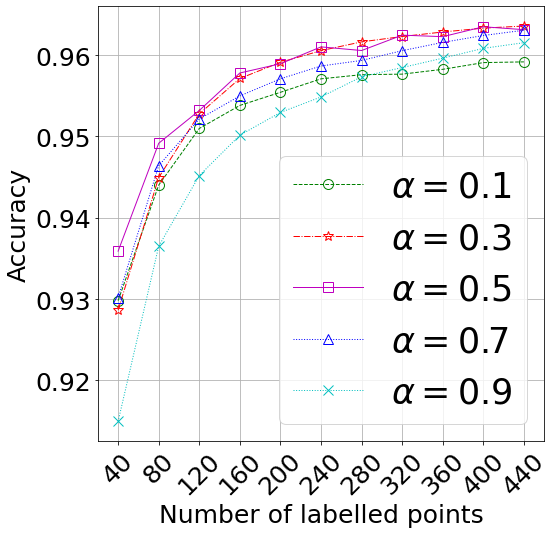

In [174]:
sigma_knn_mean1 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_KNN_alpha_0_1_N_80.npy')
sigma_knn_sd1 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_KNN_alpha_0_1_N_80.npy')

sigma_knn_mean3 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_KNN_alpha_0_3_N_80.npy')
sigma_knn_sd3 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_KNN_alpha_0_3_N_80.npy')

sigma_knn_mean5 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_KNN_alpha_0_5_N_80.npy')
sigma_knn_sd5 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_KNN_alpha_0_5_N_80.npy')

sigma_knn_mean7 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_KNN_alpha_0_7_N_80.npy')
sigma_knn_sd7 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_KNN_alpha_0_7_N_80.npy')

sigma_knn_mean9 = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_KNN_alpha_0_9_N_80.npy')
sigma_knn_sd9 = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_KNN_alpha_0_9_N_80.npy')


number_of_labeled_data = range(40,441,40)
plt.figure(figsize=(8,8))

plt.plot(number_of_labeled_data,sigma_knn_mean1,'go--',linewidth=1, markersize=10, mfc='none') 
plt.plot(number_of_labeled_data,sigma_knn_mean3,'r*-.',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean5,'ms-',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean7,'b^:',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean9,'cx:',linewidth=1, markersize=10, mfc='none')

# plt.fill_between(number_of_labeled_data, (sigma_knn_mean1 - sigma_knn_sd1), (sigma_knn_mean1 + sigma_knn_sd1), alpha=.1, color = 'g')
# plt.fill_between(number_of_labeled_data, (sigma_knn_mean3 - sigma_knn_sd3), (sigma_knn_mean3 + sigma_knn_sd3), alpha=.1, color = 'r')
# plt.fill_between(number_of_labeled_data, (sigma_knn_mean5 - sigma_knn_sd5), (sigma_knn_mean5 + sigma_knn_sd5), alpha=.1, color = 'm')
# plt.fill_between(number_of_labeled_data, (sigma_knn_mean7 - sigma_knn_sd7), (sigma_knn_mean7 + sigma_knn_sd7), alpha=.1, color = 'b')
# plt.fill_between(number_of_labeled_data, (sigma_knn_mean9 - sigma_knn_sd9), (sigma_knn_mean9 + sigma_knn_sd9), alpha=.1, color = 'c')



plt.legend([         
            r'$\alpha = 0.1$',
            r'$\alpha = 0.3$',
            r'$\alpha = 0.5$',
            r'$\alpha = 0.7$',
            r'$\alpha = 0.9$'
           ], loc = 4, fontsize=35)
                 
plt.grid()
plt.xticks(number_of_labeled_data, fontsize = 25, rotation = 45)
plt.yticks(fontsize = 25)
plt.xlabel("Number of labelled points", fontsize = 25)
plt.ylabel("Accuracy", fontsize = 25)
plt.savefig('/home/dsarkar/compute_canada/MNIST/analysis/MNIST5_trained-on-sigma-with-kmeans_comparison_alpha_N_80_test.pdf', bbox_inches = 'tight')

# 400 labeled points

In [13]:
# uniform_is = [uniform_is[2*i+1] for i in range(10)]
# uniform_is_sd = [uniform_is_sd[2*i+1] for i in range(10)]
# uniform_is = np.array(uniform_is)
# uniform_is_sd = np.array(uniform_is_sd)

# uniform_ls = [uniform_ls[2*i+1] for i in range(10)]
# uniform_ls_sd = [uniform_ls_sd[2*i+1] for i in range(10)]
# uniform_ls = np.array(uniform_ls)
# uniform_ls_sd = np.array(uniform_ls_sd)


# random_coreset_is40 = [random_coreset_is40[2*i+1] for i in range(10)]
# random_coreset_is40_sd = [random_coreset_is40_sd[2*i+1] for i in range(10)]
# random_coreset_is40 = np.array(random_coreset_is40)
# random_coreset_is40_sd = np.array(random_coreset_is40_sd)

# random_coreset_ls40 = [random_coreset_ls40[2*i+1] for i in range(10)]
# random_coreset_ls40_sd = [random_coreset_ls40_sd[2*i+1] for i in range(10)]
# random_coreset_ls40 = np.array(random_coreset_ls40)
# random_coreset_ls40_sd = np.array(random_coreset_ls40_sd)

# sensitivity_ls40 = [sensitivity_ls40[2*i+1] for i in range(10)]
# sensitivity_ls40_sd = [sensitivity_ls40_sd[2*i+1] for i in range(10)]
# sensitivity_ls40 = np.array(sensitivity_ls40)
# sensitivity_ls40_sd = np.array(sensitivity_ls40_sd)


uniform_is = uniform_is[:11]
uniform_is_sd = uniform_is_sd[:11]
uniform_ls = uniform_ls[:11]
uniform_ls_sd = uniform_ls_sd[:11]
random_coreset_is40 = random_coreset_is40[:11]
random_coreset_is40_sd = random_coreset_is40_sd[:11]
random_coreset_ls40 = random_coreset_ls40[:11]
random_coreset_ls40_sd = random_coreset_ls40_sd[:11]
sensitivity_ls40 = sensitivity_ls40[:11]
sensitivity_ls40_sd = sensitivity_ls40_sd[:11]

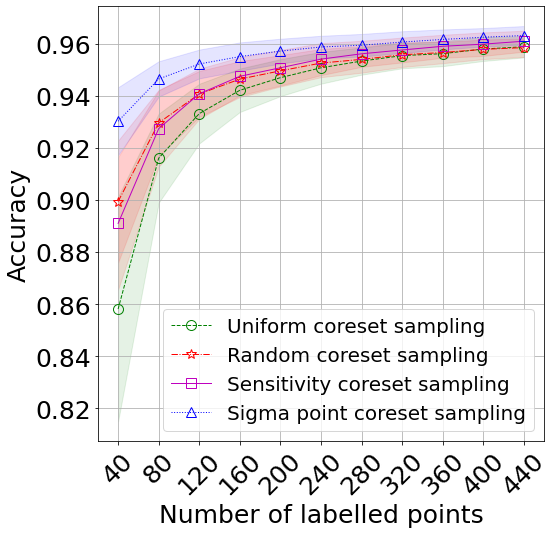

In [14]:
sigma_knn_mean = np.load('/home/dsarkar/compute_canada/MNIST/result/mean_accuracy_MNIST5_sigma_KNN_alpha_0_7_N_80.npy')
sigma_knn_sd = np.load('/home/dsarkar/compute_canada/MNIST/result/sd_accuracy_MNIST5_sigma_KNN_alpha_0_7_N_80.npy')


number_of_labeled_data = range(40,441,40)
plt.figure(figsize=(8,8))

plt.plot(number_of_labeled_data,uniform_ls,'go--',linewidth=1, markersize=10, mfc='none') 
plt.plot(number_of_labeled_data,random_coreset_ls40,'r*-.',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sensitivity_ls40,'ms-',linewidth=1, markersize=10, mfc='none')
plt.plot(number_of_labeled_data,sigma_knn_mean,'b^:',linewidth=1, markersize=10, mfc='none')

plt.fill_between(number_of_labeled_data, (uniform_ls - uniform_ls_sd), (uniform_ls + uniform_ls_sd), alpha=.1, color = 'g')
plt.fill_between(number_of_labeled_data, (random_coreset_ls40 - random_coreset_ls40_sd), (random_coreset_ls40 + random_coreset_ls40_sd), alpha=.1, color = 'r')
plt.fill_between(number_of_labeled_data, (sensitivity_ls40 - sensitivity_ls40_sd), (sensitivity_ls40 + sensitivity_ls40_sd), alpha=.1, color = 'r')
plt.fill_between(number_of_labeled_data, (sigma_knn_mean - sigma_knn_sd), (sigma_knn_mean + sigma_knn_sd), alpha=.1, color = 'b')



plt.legend([         
            'Uniform coreset sampling',
            'Random coreset sampling',
            'Sensitivity coreset sampling',
            'Sigma point coreset sampling' 
           ], loc = 4, fontsize=20)
                 
plt.grid()
plt.xticks(number_of_labeled_data, fontsize = 25, rotation = 45)
plt.yticks(fontsize = 25)
plt.xlabel("Number of labelled points", fontsize = 25)
plt.ylabel("Accuracy", fontsize = 25)
plt.savefig('/home/dsarkar/compute_canada/MNIST/analysis/MNIST5_0_7_N_80_trained-on-sigma-with-kmeans_comparison.pdf', bbox_inches = 'tight')

In [ ]:
number_of_labeled_data = range(40,501,40)
plt.figure(figsize=(20,10))


plt.plot(number_of_labeled_data, uniform_is, marker='o', markersize=10)
plt.plot(number_of_labeled_data, uniform_ls, marker='*', markersize=10)
plt.plot(number_of_labeled_data, random_coreset_is40, marker='X', markersize=10)
plt.plot(number_of_labeled_data, random_coreset_ls40, marker='D', markersize=10) 
plt.plot(number_of_labeled_data, sensitivity_ls40, marker='s', markersize=10) 
plt.plot(number_of_labeled_data,mean_random, marker='^', markersize=10) 


plt.fill_between(number_of_labeled_data, (uniform_is - uniform_is_sd), (uniform_is + uniform_is_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (uniform_ls - uniform_ls_sd), (uniform_ls + uniform_ls_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (random_coreset_is40 - random_coreset_is40_sd), (random_coreset_is40 + random_coreset_is40_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (random_coreset_ls40 - random_coreset_ls40_sd), (random_coreset_ls40 + random_coreset_ls40_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (sensitivity_ls40 - sensitivity_ls40_sd), (sensitivity_ls40 + sensitivity_ls40_sd), alpha=.1)
plt.fill_between(number_of_labeled_data, (mean_random - sd_random), (mean_random + sd_random), alpha=.1)


plt.legend(['input space (uniform)',         
            'latent space (uniform)',
          'input space (Random Coreset)',
            'latent space (Random Coreset)'\
             ,'latent space (Sensitivity Sampling)'\
          ,'latent space (Sigma Point Sampling)' 
           ], loc = 4, fontsize=25)
plt.grid()
plt.xticks(number_of_labeled_data)
plt.xlabel("Number of labelled points")
plt.ylabel("Accuracy")

#plt.title("KNN | alpha= 0.7 | 120 components | z=5")